# Batting/Fielding HOF Predidctor 

Add baseline statistics to compare also. to stats model score table.

In [1]:
import pandas as pd
import numpy as np
import requests
#from rpy2.robjects import r, pandas2ri
#import pyreadr
import matplotlib.pyplot as plt
from pandasql import sqldf
from bs4 import BeautifulSoup
#from html_table_parser import HTMLTableParser
from selenium import webdriver
import time
import datetime
from dateutil.relativedelta import relativedelta
from baseball_scraper import playerid_lookup
from unidecode import unidecode
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
import warnings  
from sklearn.exceptions import UndefinedMetricWarning
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import scipy.stats as stats

Ideas:
Could look into final game field in people df and try to come up with an active field if a player hasn't played over x time (years). will have to look into field to see.

Could also calculate the probability of batters and pitchers year to year to try to see when it is in their careers they get tho the HOF thrshold. could put it up on tableau cool viz

In [2]:
# Setting up function for loading Rdata into python from Github Source

def git_load(Name):
    github_url = f'https://raw.githubusercontent.com/an-izq/Pitcher-HOF-Predictor/main/lahman_1871-2023_csv/lahman_1871-2023_csv/{Name}.csv'
    result = pd.read_csv(github_url, encoding = "ISO-8859-1")
    globals()[f'{Name}_df'] = result
    print(f'{Name}_df Success!')
    
# Setting up function to display the correlation in upper/lower triangle. Inspired by pair.panels in R

def corr_func(x, y, **kwargs):
    corr_value = x.corr(y)
    ax = plt.gca()
    ax.annotate(f'Corr: {corr_value:.2f}', xy=(0.5, 0.5), xycoords=ax.transAxes, ha='center', va='center', fontsize=15)
    
# Setting up function to split lists to equal length

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [3]:
# Calling all Tables from Github
table_names = ['People', 'Pitching', 'Batting', 'Fielding', 'AwardsPlayers', 'AwardsSharePlayers', 'BattingPost', 'FieldingPost', 'Salaries', 'AllstarFull', 'SeriesPost', 'HallOfFame']
table_names

for x in table_names:
    git_load(x)

People_df Success!
Pitching_df Success!
Batting_df Success!
Fielding_df Success!
AwardsPlayers_df Success!
AwardsSharePlayers_df Success!
BattingPost_df Success!
FieldingPost_df Success!
Salaries_df Success!
AllstarFull_df Success!
SeriesPost_df Success!
HallOfFame_df Success!


## People DataFrame

In [4]:
# Looking at People_df
#print(People_df.head(5))
People_df.info()
#People_df.finalGame.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21010 entries, 0 to 21009
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            21010 non-null  int64  
 1   playerID      21010 non-null  object 
 2   birthYear     20904 non-null  float64
 3   birthMonth    20735 non-null  float64
 4   birthDay      20593 non-null  float64
 5   birthCity     20867 non-null  object 
 6   birthCountry  20955 non-null  object 
 7   birthState    20464 non-null  object 
 8   deathYear     10266 non-null  float64
 9   deathMonth    10265 non-null  float64
 10  deathDay      10264 non-null  float64
 11  deathCountry  10264 non-null  object 
 12  deathState    10204 non-null  object 
 13  deathCity     10262 non-null  object 
 14  nameFirst     20976 non-null  object 
 15  nameLast      21010 non-null  object 
 16  nameGiven     20973 non-null  object 
 17  weight        20165 non-null  float64
 18  height        20245 non-nu

In [5]:
# # Creating an active marker. It's going to be dificult as going off of final game will be tough. trying to do based off date will result in injured players becoming retired, doesnt take into account players retired during that period. It's something I wish I had for analysis but not too big of a deal.
# finalgameDT = pd.to_datetime(People_df['finalGame'])
# finalgameDT = finalgameDT
# fgmax = finalgameDT.max()
# fgfilter = fgmax - relativedelta(years = 1, months= 1)
# len(finalgameDT[finalgameDT > fgfilter])
# People_df.loc[People_df['finalGame'] > fgfilter]

## Pitching Dataframe

Bringing in Pitching data to filter out players who were primarily pitchers and did not reach the hall of fame based on their batting abilities as these will skew and add noise to my data and mess up predictions.

In [6]:
# Looking at Pitchting_df
Pitching_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51368 entries, 0 to 51367
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   playerID  51368 non-null  object 
 1   yearID    51368 non-null  int64  
 2   stint     51368 non-null  int64  
 3   teamID    51368 non-null  object 
 4   lgID      51236 non-null  object 
 5   W         51368 non-null  int64  
 6   L         51368 non-null  int64  
 7   G         51368 non-null  int64  
 8   GS        51368 non-null  int64  
 9   CG        51368 non-null  int64  
 10  SHO       51368 non-null  int64  
 11  SV        51368 non-null  int64  
 12  IPouts    51368 non-null  int64  
 13  H         51368 non-null  int64  
 14  ER        51368 non-null  int64  
 15  HR        51368 non-null  int64  
 16  BB        51368 non-null  int64  
 17  SO        51368 non-null  int64  
 18  BAOpp     46924 non-null  float64
 19  ERA       51271 non-null  float64
 20  IBB       36790 non-null  fl

In [7]:
# joining debut into pitching df and then modifying the debut column
q = '''
SELECT
a.*,
b.debut
FROM
    Pitching_df a
LEFT JOIN
    People_df b
        on a.playerID = b.playerID
;
'''
Pitching_debut_df = sqldf(q, locals())
# keeping the first four characters of the 'debut' column since that is the year
Pitching_debut_df['debut'] = Pitching_debut_df['debut'].astype(str).str[:4]
# Printing players who don't have a debut year.... Curious.....
print(Pitching_debut_df.loc[Pitching_debut_df['debut'] == 'None'])
# Replacing the 'None' values with zeroes since int doesn't take Nan/np.nan or None values
Pitching_debut_df.replace({'debut': 'None'}, 0, inplace = True) # {'col' : 'value'}
# Changing debut from str to int
Pitching_debut_df['debut'] = Pitching_debut_df['debut'].astype(int)
# check
Pitching_debut_df.debut.info()

        playerID  yearID  stint teamID lgID  W  L  G  GS  CG  ...  WP  HBP  \
21804  hyndmji01    1886      1    PH4   AA  0  1  1   1   0  ...   2  1.0   
44336  stineha01    1890      1    PH4   AA  0  1  1   1   1  ...   2  0.0   
44944  sulliwi01    1884      1    SLU   UA  1  0  1   1   0  ...   0  NaN   

       BK   BFP  GF   R  SH  SF  GIDP  debut  
21804   0  17.0   0  10 NaN NaN   NaN   None  
44336   0  45.0   0   9 NaN NaN   NaN   None  
44944   0  29.0   0   6 NaN NaN   NaN   None  

[3 rows x 31 columns]
<class 'pandas.core.series.Series'>
RangeIndex: 51368 entries, 0 to 51367
Series name: debut
Non-Null Count  Dtype
--------------  -----
51368 non-null  int64
dtypes: int64(1)
memory usage: 401.4 KB


In [8]:
# keeping all pitchers who have a debut date of greater than or eqaul to 1955
Pitching_1955 = Pitching_debut_df.loc[Pitching_debut_df['debut'] >= 1955]
# getting rid of columns that are not needed
Pitching_1955 = Pitching_1955.drop(columns=['GIDP', 'debut'])
print('The rows of the pitching dataframe is: ' + str(len(Pitching_1955)))

The rows of the pitching dataframe is: 35498


In [9]:
# Grouping all the players together by sum or avg in my population
q = '''
SELECT
    playerID,
    sum(W) as W_tot,
    sum(L) as L_tot,
    sum(G) as G_tot,
    sum(GS) as GS_tot,
    sum(CG) as CG_tot,
    sum(SHO) as SHO_tot,
    sum(SV) as SV_tot,
    sum(IPouts) as IPouts_tot,
    sum(H) as H_tot,
    sum(ER) as ER_tot,
    sum(HR) as HR_tot,
    sum(BB) as BB_tot,
    sum(SO) as SO_tot,
    avg(BAOpp) as BAOpp_avg,
    avg(ERA) as ERA_avg,
    sum(IBB) as IBB_tot,
    sum(WP) as WP_tot,
    sum(HBP) as HBP_tot,
    sum(BK) as BK_tot,
    sum(BFP) as BFP_tot,
    sum(GF) as GF_tot,
    sum(R) as R_tot,
    sum(SH) as SH_tot,
    sum(SF) as SF_tot
FROM
    Pitching_1955
GROUP BY playerID
;
'''
Pitching_1955_player_career = sqldf(q, locals())
print('The population of players careers is: ' + str(len(Pitching_1955_player_career)))
Pitching_1955_player_career.head()

The population of players careers is: 6691


,playerID,W_tot,L_tot,G_tot,GS_tot,CG_tot,SHO_tot,SV_tot,IPouts_tot,H_tot,...,ERA_avg,IBB_tot,WP_tot,HBP_tot,BK_tot,BFP_tot,GF_tot,R_tot,SH_tot,SF_tot
0,aardsda01,16,18,331,0,0,0,69,1011,296,...,5.194444,22.0,12,16.0,1,1475.0,141,169,17.0,11.0
1,aasedo01,66,60,448,91,22,5,82,3328,1085,...,3.493077,45.0,22,7.0,3,4730.0,235,503,50.0,34.0
2,abadfe01,9,29,406,6,0,0,2,1064,343,...,4.222500,11.0,10,12.0,2,1513.0,103,158,7.0,12.0
3,abbotan01,8,6,21,21,0,0,0,328,100,...,3.870000,0.0,1,1.0,1,459.0,0,47,0.0,5.0
4,abbotco01,1,7,45,10,0,0,0,314,112,...,6.213333,0.0,8,9.0,1,481.0,19,74,1.0,5.0


In [10]:
# Setting up list of players who were good two-way players (Pitched and Batted) to preserve their stats (Mostly Shohei Ohtani). This list comes from multiple sources.
twoway = ['ohtansh01', 'ankieri01', 'eibnebr01', 'gosean01', 'kiescbr01', 'lorenmi01', 'mckaybr01', 'smithwi02', 'woodtr01']
Pitchers = Pitching_1955_player_career[~Pitching_1955_player_career['playerID'].isin(twoway)]

# Setting up list to filter out players who are primarily pitchers.
Pitchers = Pitchers.query('G_tot > 50').playerID
len(Pitchers)

3381

## Batting Dataframe

In [11]:
# Looking at Batting_df
Batting_df.info()
Batting_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113799 entries, 0 to 113798
Data columns (total 24 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   playerID   113799 non-null  object 
 1   yearID     113799 non-null  int64  
 2   stint      113799 non-null  int64  
 3   teamID     113799 non-null  object 
 4   lgID       113062 non-null  object 
 5   G          113799 non-null  int64  
 6   G_batting  1615 non-null    float64
 7   AB         113799 non-null  int64  
 8   R          113799 non-null  int64  
 9   H          113799 non-null  int64  
 10  2B         113799 non-null  int64  
 11  3B         113799 non-null  int64  
 12  HR         113799 non-null  int64  
 13  RBI        113043 non-null  float64
 14  SB         111431 non-null  float64
 15  CS         90257 non-null   float64
 16  BB         113799 non-null  int64  
 17  SO         111699 non-null  float64
 18  IBB        77148 non-null   float64
 19  HBP        110983 non-n

,playerID,yearID,stint,teamID,lgID,G,G_batting,AB,R,H,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,G_old
0,aardsda01,2004,1,SFN,NL,11,NaN,0,0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,aardsda01,2006,1,CHN,NL,45,NaN,2,0,0,...,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2,aardsda01,2007,1,CHA,AL,25,NaN,0,0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,aardsda01,2008,1,BOS,AL,47,NaN,1,0,0,...,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
4,aardsda01,2009,1,SEA,AL,73,NaN,0,0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [12]:
# Descriptive stats on Batting_df
Batting_df.describe()

,yearID,stint,G,G_batting,AB,R,H,2B,3B,HR,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,G_old
count,113799.000000,113799.000000,113799.000000,1615.000000,113799.000000,113799.000000,113799.000000,113799.000000,113799.000000,113799.000000,...,111431.000000,90257.000000,113799.000000,111699.000000,77148.000000,110983.000000,107731.000000,77695.000000,88357.000000,0.0
mean,1969.631324,1.080774,50.384213,31.424149,137.415513,18.243218,35.841071,6.140151,1.209975,2.874296,...,2.861161,1.138471,12.685814,20.754940,1.008127,1.066695,2.109625,1.003243,2.844800,NaN
std,40.454440,0.290743,46.744082,48.662969,182.992172,27.892612,51.871387,9.600093,2.553320,6.408657,...,7.506894,2.629624,20.482474,29.199861,2.647541,2.318572,4.082782,1.910713,4.640065,NaN
min,1871.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,1939.000000,1.000000,12.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,1979.000000,1.000000,34.000000,1.000000,44.000000,4.000000,8.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,2.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,2004.000000,1.000000,78.000000,49.500000,220.000000,26.000000,54.000000,9.000000,1.000000,2.000000,...,2.000000,1.000000,17.000000,29.000000,1.000000,1.000000,3.000000,1.000000,4.000000,NaN
max,2023.000000,5.000000,165.000000,162.000000,716.000000,198.000000,262.000000,67.000000,36.000000,73.000000,...,138.000000,42.000000,232.000000,223.000000,120.000000,51.000000,67.000000,19.000000,36.000000,NaN


In [13]:
# First year CS (Caught Stealing was used as a statistic) seeing when it is null
print(Batting_df[Batting_df["CS"].isnull()]["yearID"].min())
print(Batting_df[Batting_df["CS"].isnull()]["yearID"].max())
# range of 1876-1950 partially

# First year IBB (Caught Stealing was used as a statistic) seeing when it is null
print(Batting_df[Batting_df["IBB"].isnull()]["yearID"].min())
print(Batting_df[Batting_df["IBB"].isnull()]["yearID"].max())
# range of 1871-1954 partially

# First year SF (Caught Stealing was used as a statistic) seeing when it is null
print(Batting_df[Batting_df["SF"].isnull()]["yearID"].min())
print(Batting_df[Batting_df["SF"].isnull()]["yearID"].max())
# range of 1871-1953 partially

# First year GIDP (Caught Stealing was used as a statistic) seeing when it is null
print(Batting_df[Batting_df["GIDP"].isnull()]["yearID"].min())
print(Batting_df[Batting_df["GIDP"].isnull()]["yearID"].max())
# range of 1876-1938 partially

1876
1950
1871
1954
1871
1953
1876
1938


In [14]:
# joining debut into Batting df and then modifying the debut column
q = '''
SELECT
a.*,
b.debut
FROM
    Batting_df a
LEFT JOIN
    People_df b
        on a.playerID = b.playerID
;
'''
Batting_debut_df = sqldf(q, locals())
# keeping the first four characters of the 'debut' column since that is the year
Batting_debut_df['debut'] = Batting_debut_df['debut'].astype(str).str[:4]
# Printing players who don't have a debut year.... Curious.....
print(Batting_debut_df.loc[Batting_debut_df['debut'] == 'None'])
# Replacing the 'None' values with zeroes since int doesn't take Nan/np.nan or None values
Batting_debut_df.replace({'debut': 'None'}, 0, inplace = True) # {'col' : 'value'}
# Changing debut from str to int
Batting_debut_df['debut'] = Batting_debut_df['debut'].astype(int)
# check
Batting_debut_df.debut.info()

         playerID  yearID  stint teamID  lgID  G  G_batting  AB  R  H  ...  \
22156   crossjo01    1888      1    LS2    AA  1        NaN   1  0  0  ...   
36654   gilgahu01    1875      1    BR2  None  2        NaN   8  2  2  ...   
48974   hyndmji01    1886      1    PH4    AA  1        NaN   4  0  0  ...   
67033   mckenfr01    1874      1    PH2  None  1        NaN   4  0  0  ...   
98503   stineha01    1890      1    PH4    AA  1        NaN   3  0  0  ...   
99694   sulliwi01    1884      1    SLU    UA  1        NaN   5  0  1  ...   
113454  zeihehe01    1886      1    WS8    NL  6        NaN  21  0  0  ...   

         CS  BB    SO  IBB  HBP  SH  SF  GIDP  G_old  debut  
22156   NaN   0   1.0  NaN  0.0 NaN NaN   NaN   None   None  
36654   0.0   0   0.0  NaN  NaN NaN NaN   0.0   None   None  
48974   NaN   0   NaN  NaN  0.0 NaN NaN   NaN   None   None  
67033   0.0   0   1.0  NaN  NaN NaN NaN   0.0   None   None  
98503   NaN   1   NaN  NaN  0.0 NaN NaN   NaN   None   None  
996

In [15]:
# keeping all Batters who have a debut date of greater than or eqaul to 1955
Batting_1955 = Batting_debut_df.loc[Batting_debut_df['debut'] >= 1955]
# getting rid of columns that are not needed
Batting_1955 = Batting_1955.drop(columns=['GIDP', 'debut', 'G_old', 'G_batting'])
print('The rows of the Batting dataframe is: ' + str(len(Batting_1955)))
Batting_1955.rename(columns={'2B':'DB', '3B':'TB'}, inplace=True) # renaming because sql does not take a column starting with a number, will change back.
Batting_1955.columns

The rows of the Batting dataframe is: 73220


Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       'DB', 'TB', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF'],
      dtype='object')

In [16]:
# Grouping all the players together by sum or avg in my population
q = '''
SELECT
    playerID,
    sum(G) as G_tot,
    sum(AB) as AB_tot,
    sum(R) as R_tot,
    sum(H) as H_tot,
    sum(DB) as DB_tot,
    sum(TB) as TB_tot,
    sum(HR) as HR_tot,
    sum(RBI) as RBI_tot,
    sum(SB) as SB_tot,
    sum(CS) as CS_tot,
    sum(BB) as BB_tot,
    sum(SO) as SO_tot,
    sum(IBB) as IBB_tot,
    sum(HBP) as HBP_tot,
    sum(SH) as SH_tot,
    sum(SF) as SF_tot
FROM
    Batting_1955
GROUP BY playerID
;
'''
Batting_1955_player_career = sqldf(q, locals())
print('The population of players careers is: ' + str(len(Batting_1955_player_career)))
Batting_1955_player_career.rename(columns={'DB_tot':'2B_tot', 'TB_tot':'3B_tot'}, inplace=True) # renaming because sql does not take a column starting with a number, changing back.
Batting_1955_player_career.head()

The population of players careers is: 11935


,playerID,G_tot,AB_tot,R_tot,H_tot,2B_tot,3B_tot,HR_tot,RBI_tot,SB_tot,CS_tot,BB_tot,SO_tot,IBB_tot,HBP_tot,SH_tot,SF_tot
0,aardsda01,331,4,0,0,0,0,0,0.0,0.0,0.0,0,2.0,0.0,0.0,1.0,0.0
1,aaronto01,437,944,102,216,42,6,13,94.0,9.0,8.0,86,145.0,3.0,0.0,9.0,6.0
2,aasedo01,448,5,0,0,0,0,0,0.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0.0
3,abadan01,15,21,1,2,0,0,0,0.0,0.0,1.0,4,5.0,0.0,0.0,0.0,0.0
4,abadfe01,406,9,0,1,0,0,0,0.0,0.0,0.0,0,5.0,0.0,0.0,0.0,0.0


In [17]:
# Filling in SH and SF with zeros where null since it was not a recorded stat until 1970 so BAOpp counted SH and SF as zero for players before that year.
Batting_1955_player_career.fillna({'SH_tot': 0}, inplace=True)
Batting_1955_player_career.fillna({'SF_tot': 0}, inplace=True)

In [18]:
# Calculating career BA_avg by Dividing the total amount of hits (H) by at bats.
Batting_1955_player_career['BA_avg'] = (Batting_1955_player_career['H_tot'] / (Batting_1955_player_career['AB_tot']))
# Pitching_1955_player_career['BA_avg'].query('playerID == "blylebe01"')
Batting_1955_player_career[['playerID', 'BA_avg']].loc[Batting_1955_player_career['playerID'] == 'aaronto01'] # to verify on baseball reference website

,playerID,BA_avg
1,aaronto01,0.228814


In [19]:
# Calculating career OBP_avg by Dividing the total amount of hits (H) by at bats.
Batting_1955_player_career['OBP'] = ((Batting_1955_player_career['H_tot'] + Batting_1955_player_career['BB_tot'] + Batting_1955_player_career['HBP_tot']) / ((Batting_1955_player_career['AB_tot'] + Batting_1955_player_career['BB_tot'] + Batting_1955_player_career['HBP_tot'] + Batting_1955_player_career['SF_tot'])))
# Pitching_1955_player_career['OBP'].query('playerID == "blylebe01"')
Batting_1955_player_career[['playerID', 'OBP']].loc[Batting_1955_player_career['playerID'] == 'aaronto01'] # to verify on baseball reference website

,playerID,OBP
1,aaronto01,0.291506


In [20]:
# Calculating career SLG by Getting the total amount of singles (subtract 2B, 3B, HR totals from H total) and add 2B, 3B, HR totals (multiply the amount of bases reach ed also to each indiv total) and finally divide by the total AB.
Batting_1955_player_career['SLG'] = (((Batting_1955_player_career['H_tot'] - Batting_1955_player_career['2B_tot'] - Batting_1955_player_career['3B_tot'] - Batting_1955_player_career['HR_tot']) + (2 * Batting_1955_player_career['2B_tot'])  + (3 * Batting_1955_player_career['3B_tot']) + (4 * Batting_1955_player_career['HR_tot'])) / (Batting_1955_player_career['AB_tot']))
# Pitching_1955_player_career['SLG'].query('playerID == "blylebe01"')
Batting_1955_player_career[['playerID', 'SLG']].loc[Batting_1955_player_career['playerID'] == 'aaronto01'] # to verify on baseball reference website

,playerID,SLG
1,aaronto01,0.327331


In [21]:
# Calculating career OPS by adding OBP and SLG.
Batting_1955_player_career['OPS'] = (Batting_1955_player_career['OBP'] + Batting_1955_player_career['SLG'])
# Pitching_1955_player_career['OPS'].query('playerID == "blylebe01"')
Batting_1955_player_career[['playerID', 'OPS']].loc[Batting_1955_player_career['playerID'] == 'aaronto01'] # to verify on baseball reference website

,playerID,OPS
1,aaronto01,0.618836


In [22]:
# looking at the info for the new formatted Dataframe
Batting_1955_player_career.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11935 entries, 0 to 11934
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   playerID  11935 non-null  object 
 1   G_tot     11935 non-null  int64  
 2   AB_tot    11935 non-null  int64  
 3   R_tot     11935 non-null  int64  
 4   H_tot     11935 non-null  int64  
 5   2B_tot    11935 non-null  int64  
 6   3B_tot    11935 non-null  int64  
 7   HR_tot    11935 non-null  int64  
 8   RBI_tot   11935 non-null  float64
 9   SB_tot    11935 non-null  float64
 10  CS_tot    11935 non-null  float64
 11  BB_tot    11935 non-null  int64  
 12  SO_tot    11935 non-null  float64
 13  IBB_tot   11935 non-null  float64
 14  HBP_tot   11935 non-null  float64
 15  SH_tot    11935 non-null  float64
 16  SF_tot    11935 non-null  float64
 17  BA_avg    9692 non-null   float64
 18  OBP       9720 non-null   float64
 19  SLG       9692 non-null   float64
 20  OPS       9692 non-null   fl

In [23]:
# Removing pitchers who have had a rare plate appearance but didn't register an AB
pitcher_bat_df = Batting_1955_player_career[Batting_1955_player_career["OBP"].isnull() | Batting_1955_player_career["BA_avg"].isnull()]
print(len(pitcher_bat_df))
Batting_1955_player_career = Batting_1955_player_career[~Batting_1955_player_career.playerID.isin(pitcher_bat_df['playerID'])]

# Removing players who were primarily pitchers
Batting_1955_player_career = Batting_1955_player_career[~Batting_1955_player_career['playerID'].isin(Pitchers)]

Batting_1955_player_career.info()

2243
<class 'pandas.core.frame.DataFrame'>
Index: 6889 entries, 1 to 11933
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   playerID  6889 non-null   object 
 1   G_tot     6889 non-null   int64  
 2   AB_tot    6889 non-null   int64  
 3   R_tot     6889 non-null   int64  
 4   H_tot     6889 non-null   int64  
 5   2B_tot    6889 non-null   int64  
 6   3B_tot    6889 non-null   int64  
 7   HR_tot    6889 non-null   int64  
 8   RBI_tot   6889 non-null   float64
 9   SB_tot    6889 non-null   float64
 10  CS_tot    6889 non-null   float64
 11  BB_tot    6889 non-null   int64  
 12  SO_tot    6889 non-null   float64
 13  IBB_tot   6889 non-null   float64
 14  HBP_tot   6889 non-null   float64
 15  SH_tot    6889 non-null   float64
 16  SF_tot    6889 non-null   float64
 17  BA_avg    6889 non-null   float64
 18  OBP       6889 non-null   float64
 19  SLG       6889 non-null   float64
 20  OPS       6889 non-null   flo

In [24]:
# dropping sacrifice hits and sacrifice flys since they were only used to calculate average BAOpp (Opponent Batting Average)
Batting_1955_player_career = Batting_1955_player_career.drop(columns=['SH_tot', 'SF_tot'])
Batting_1955_player_career.columns

Index(['playerID', 'G_tot', 'AB_tot', 'R_tot', 'H_tot', '2B_tot', '3B_tot',
       'HR_tot', 'RBI_tot', 'SB_tot', 'CS_tot', 'BB_tot', 'SO_tot', 'IBB_tot',
       'HBP_tot', 'BA_avg', 'OBP', 'SLG', 'OPS'],
      dtype='object')

In [25]:
Batting_1955_player_career.describe()

,G_tot,AB_tot,R_tot,H_tot,2B_tot,3B_tot,HR_tot,RBI_tot,SB_tot,CS_tot,BB_tot,SO_tot,IBB_tot,HBP_tot,BA_avg,OBP,SLG,OPS
count,6889.000000,6889.000000,6889.000000,6889.000000,6889.000000,6889.000000,6889.000000,6889.000000,6889.000000,6889.000000,6889.000000,6889.000000,6889.000000,6889.000000,6889.000000,6889.000000,6889.000000,6889.000000
mean,410.867760,1276.057918,168.636087,333.994194,61.195674,7.867470,36.163594,158.901437,23.846857,10.959501,123.788503,229.632603,10.599506,10.747423,0.206999,0.264961,0.305199,0.570160
std,571.119191,2000.702431,287.427068,551.620685,102.985047,15.339234,74.568169,280.691236,64.077816,22.907567,222.506378,349.871369,26.038974,21.228639,0.111886,0.124229,0.177264,0.289488
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,22.000000,2.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.176471,0.239496,0.234043,0.480952
50%,120.000000,270.000000,31.000000,61.000000,11.000000,1.000000,4.000000,27.000000,2.000000,1.000000,22.000000,60.000000,1.000000,2.000000,0.232990,0.295833,0.336449,0.636098
75%,609.000000,1678.000000,201.000000,428.000000,75.000000,9.000000,33.000000,184.000000,16.000000,11.000000,143.000000,313.000000,9.000000,12.000000,0.258972,0.327285,0.400000,0.722222
max,3562.000000,14053.000000,2295.000000,4256.000000,746.000000,166.000000,762.000000,2218.000000,1406.000000,335.000000,2558.000000,2597.000000,688.000000,285.000000,1.000000,1.000000,3.000000,4.000000


Debating on what to do with my population becuase there most definitely are pitchers mixed into this population, who arent dedicated batters but still get a good amount of at bats. Also what to do about the decent sized population (25%) that have at bats below 13. For now I will probably leave them in with the risk on them causing noise and skewing my model. I can comeback and add a pitcher or AB filter later. I'm sure I will get some pitcher that appear as hall of famers with a poor batting career and those will be removed.

In [26]:
# number of batters who have had at least 10 abs
len(Batting_1955_player_career[Batting_1955_player_career['AB_tot'] > 13])

5448

In [27]:
# table to be used in analysis and modeling
Batting_1955_player_career.head(5)

,playerID,G_tot,AB_tot,R_tot,H_tot,2B_tot,3B_tot,HR_tot,RBI_tot,SB_tot,CS_tot,BB_tot,SO_tot,IBB_tot,HBP_tot,BA_avg,OBP,SLG,OPS
1,aaronto01,437,944,102,216,42,6,13,94.0,9.0,8.0,86,145.0,3.0,0.0,0.228814,0.291506,0.327331,0.618836
3,abadan01,15,21,1,2,0,0,0,0.0,0.0,1.0,4,5.0,0.0,0.0,0.095238,0.240000,0.095238,0.335238
6,abbotco01,46,3,0,1,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.333333,0.333333,0.333333,0.666667
8,abbotje01,233,596,82,157,33,2,18,83.0,6.0,5.0,38,91.0,2.0,3.0,0.263423,0.307453,0.416107,0.723561
10,abbotku01,702,2044,273,523,109,23,62,242.0,22.0,11.0,133,571.0,11.0,17.0,0.255871,0.305077,0.422701,0.727778


## Fielding

In [28]:
Fielding_df

,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
0,aardsda01,2004,1,SFN,NL,P,11,0.0,32.0,0,0,0.0,0,NaN,NaN,NaN,NaN,NaN
1,aardsda01,2006,1,CHN,NL,P,45,0.0,159.0,1,5,0.0,1,NaN,NaN,NaN,NaN,NaN
2,aardsda01,2007,1,CHA,AL,P,25,0.0,97.0,2,4,1.0,0,NaN,NaN,NaN,NaN,NaN
3,aardsda01,2008,1,BOS,AL,P,47,0.0,146.0,3,6,0.0,0,NaN,NaN,NaN,NaN,NaN
4,aardsda01,2009,1,SEA,AL,P,73,0.0,214.0,2,5,0.0,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151502,zwilldu01,1915,1,CHF,FL,OF,148,NaN,NaN,356,20,8.0,6,NaN,NaN,NaN,NaN,NaN
151503,zwilldu01,1916,1,CHN,NL,OF,10,NaN,NaN,11,0,0.0,0,NaN,NaN,NaN,NaN,NaN
151504,zychto01,2015,1,SEA,AL,P,13,1.0,55.0,0,3,0.0,0,NaN,NaN,NaN,NaN,NaN
151505,zychto01,2016,1,SEA,AL,P,12,0.0,41.0,0,0,1.0,0,NaN,NaN,NaN,NaN,NaN


In [29]:
# Grouping all the players together by sum or avg in my population
q = '''
SELECT
    playerID,
    sum(GS) as GS_tot,
    sum(InnOuts	) as InnOuts_tot,
    sum(PO) as PO_tot,
    sum(A) as A_tot,
    sum(E) as E_tot,
    sum(DP) as DP_tot,
    sum(PB) as PB_tot,
    sum(WP) as WP_tot,
    sum(SB) as SB_tot,
    sum(CS) as CS_tot,
    sum(ZR) as ZR_tot
FROM
    Fielding_df
GROUP BY playerID
;
'''
Fielding_career_df = sqldf(q, locals())
Fielding_career_df

,playerID,GS_tot,InnOuts_tot,PO_tot,A_tot,E_tot,DP_tot,PB_tot,WP_tot,SB_tot,CS_tot,ZR_tot
0,aardsda01,0.0,1011.0,11,29,3.0,2,NaN,NaN,NaN,NaN,NaN
1,aaronha01,2977.0,78414.0,7436,429,144.0,218,NaN,NaN,NaN,NaN,NaN
2,aaronto01,206.0,6472.0,1317,113,22.0,124,NaN,NaN,NaN,NaN,NaN
3,aasedo01,91.0,3328.0,67,135,13.0,10,NaN,NaN,NaN,NaN,NaN
4,abadan01,4.0,138.0,37,1,1.0,3,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
20524,zupofr01,1.0,114.0,31,1,2.0,0,1.0,1.0,2.0,1.0,0.0
20525,zuvelpa01,136.0,3844.0,267,415,23.0,84,NaN,NaN,NaN,NaN,NaN
20526,zuverge01,31.0,1847.0,45,145,7.0,10,NaN,NaN,NaN,NaN,NaN
20527,zwilldu01,27.0,654.0,755,37,25.0,10,NaN,NaN,NaN,NaN,NaN


In [30]:
# Calculating the Fielding percentage as PO (Put-outs) plus A (Asists) divided by PO plus A plus E (errors)
Fielding_career_df["Fld_pct"] = (Fielding_career_df["PO_tot"] + Fielding_career_df["A_tot"]) / (Fielding_career_df["PO_tot"] + Fielding_career_df["A_tot"] + Fielding_career_df["E_tot"])
Fielding_career_df[['playerID', 'Fld_pct']].loc[Fielding_career_df['playerID'] == 'molinya01']

,playerID,Fld_pct
12694,molinya01,0.994754


In [31]:
# table to be used for analysis and modeling
Fielding_career_df.head(5)

,playerID,GS_tot,InnOuts_tot,PO_tot,A_tot,E_tot,DP_tot,PB_tot,WP_tot,SB_tot,CS_tot,ZR_tot,Fld_pct
0,aardsda01,0.0,1011.0,11,29,3.0,2,NaN,NaN,NaN,NaN,NaN,0.930233
1,aaronha01,2977.0,78414.0,7436,429,144.0,218,NaN,NaN,NaN,NaN,NaN,0.982020
2,aaronto01,206.0,6472.0,1317,113,22.0,124,NaN,NaN,NaN,NaN,NaN,0.984848
3,aasedo01,91.0,3328.0,67,135,13.0,10,NaN,NaN,NaN,NaN,NaN,0.939535
4,abadan01,4.0,138.0,37,1,1.0,3,NaN,NaN,NaN,NaN,NaN,0.974359


## Awards Players Dataframe

In [32]:
# AwardsPlayers_df Exploration
AwardsPlayers_df.info()
#print(AwardsPlayers_df.describe())
AwardsPlayers_df["awardID"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6797 entries, 0 to 6796
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   playerID  6797 non-null   object
 1   awardID   6797 non-null   object
 2   yearID    6797 non-null   int64 
 3   lgID      6793 non-null   object
 4   tie       64 non-null     object
 5   notes     5127 non-null   object
dtypes: int64(1), object(5)
memory usage: 318.7+ KB


array(['Lou Gehrig Memorial Award', 'Most Valuable Player', 'NLCS MVP',
       'Outstanding DH Award', 'Pitching Triple Crown', 'Platinum Glove',
       'TSN All-Star', 'TSN Major League Player of the Year',
       'TSN Pitcher of the Year', 'TSN Reliever of the Year',
       'World Series MVP', 'Reliever of the Year Award', 'Silver Slugger',
       'ALCS MVP', 'All-Star Game MVP', 'Roberto Clemente Award',
       'Rookie of the Year', 'Gold Glove', 'Babe Ruth Award',
       'Comeback Player of the Year', 'Cy Young Award',
       'Hank Aaron Award', 'Hutch Award', 'SIlver Slugger',
       'Baseball Magazine All-Star', 'Triple Crown', 'TSN Guide MVP',
       'TSN Player of the Year', 'TSN Fireman of the Year',
       'Branch Rickey Award'], dtype=object)

In [33]:
# Setting up from population of players those who had awards and only keeping those awards that contribute to a players career without being repetitive (limiting amount of awards).
q = '''
SELECT 
a.playerID,
count(*) as award_count
FROM 
    AwardsPlayers_df a
INNER JOIN
    Batting_1955_player_career b
        on a.playerID = b.playerID
Where awardID in (
                    'Most Valuable Player', 
                    'NLCS MVP',       
                    'Outstanding DH Award', 
                    'Platinum Glove',
                    'World Series MVP', 
                    'Silver Slugger',
                    'ALCS MVP', 
                    'All-Star Game MVP',
                    'Rookie of the Year', 
                    'Gold Glove', 
                    'Babe Ruth Award',
                    'Cy Young Award',
                    'Hank Aaron Award',
                    'SIlver Slugger', 
                    'Triple Crown'
                )
GROUP BY
a.playerID
;
'''

Batting_1955_awards = sqldf(q, locals())

In [34]:
# table to be used in analysis and modeling
Batting_1955_awards

,playerID,award_count
0,abreubo01,2
1,abreujo02,6
2,acunaro01,6
3,ageeto01,3
4,ahmedni01,2
...,...,...
636,younger01,1
637,youngmi02,2
638,yountro01,6
639,zimmery01,3


## Awards Share Players Dataframe

In [35]:
# AwardsSharePlayers_df Exploration
# AwardsSharePlayers_df.info()
print(AwardsSharePlayers_df.describe())
print(AwardsSharePlayers_df['awardID'].unique())
#AwardsSharePlayers_df.query('awardID == "Rookie of the Year"')

            yearID    pointsWon    pointsMax   votesFirst
count  7447.000000  7447.000000  7447.000000  7089.000000
mean   1976.090909    45.030751   271.220491     1.671886
std      29.479465    70.287190   128.890813     5.107104
min    1911.000000     0.000000    16.000000     0.000000
25%    1952.000000     4.000000   140.000000     0.000000
50%    1978.000000    13.000000   336.000000     0.000000
75%    2002.000000    55.000000   392.000000     0.000000
max    2023.000000   448.000000   448.000000    32.000000
['Cy Young Award' 'Most Valuable Player' 'Rookie of the Year']


In [36]:
# Setting up the pointsWon_tot field which just counts all of the points won in any 'Cy Young Award' 'Most Valuable Player' 'Rookie of the Year' award 
q = '''
SELECT 
a.awardID,
a.playerID,
sum(a.pointsWon) as pointsWon_tot
FROM 
    AwardsSharePlayers_df a
INNER JOIN
    Batting_1955_player_career b
        on a.playerID = b.playerID
GROUP BY
a.awardID,
a.playerID
;
'''
AwardsSharePlayers_career_df = sqldf(q, locals())
AwardsSharePlayers_career_df

,awardID,playerID,pointsWon_tot
0,Cy Young Award,ohtansh01,82
1,Cy Young Award,sorokmi01,9
2,Most Valuable Player,abreubo01,69
3,Most Valuable Player,abreujo02,553
4,Most Valuable Player,acunaro01,615
...,...,...,...
1385,Rookie of the Year,youngge02,7
1386,Rookie of the Year,youngmi01,3
1387,Rookie of the Year,zeileto01,4
1388,Rookie of the Year,zimmery01,101


In [37]:
# pivoting the AwardsSharePlayers_career_df table
AwardsSharePlayers_career_df_pivot = AwardsSharePlayers_career_df.pivot(index= 'playerID', columns= 'awardID', values= 'pointsWon_tot')
AwardsSharePlayers_career_df_pivot.reset_index(inplace=True)
AwardsSharePlayers_career_df_pivot = AwardsSharePlayers_career_df_pivot.rename_axis(None, axis=1)
AwardsSharePlayers_career_df_pivot.fillna(0, inplace=True)

# table to be used in analysis and modeling
AwardsSharePlayers_career_df_pivot = AwardsSharePlayers_career_df_pivot.rename(columns={'Cy Young Award': 'CYY_totvotes', 'Most Valuable Player': 'MVP_totvotes', 'Rookie of the Year':'ROY_totvotes'})
AwardsSharePlayers_career_df_pivot

,playerID,CYY_totvotes,MVP_totvotes,ROY_totvotes
0,abreubo01,0.0,69.0,0.0
1,abreujo02,0.0,553.0,150.0
2,ackledu01,0.0,0.0,6.0
3,acunaro01,0.0,615.0,144.0
4,adairje01,0.0,18.0,0.0
...,...,...,...,...
1096,zeileto01,0.0,0.0,4.0
1097,zimmery01,0.0,28.0,101.0
1098,ziskri01,0.0,91.0,0.0
1099,zobribe01,0.0,48.0,0.0


## Batting Post Dataframe

In [38]:
# PitchingPost_df Exploration
#PitchingPost_df.info()

BattingPost_df.rename(columns={'2B':'DB', '3B':'TB'}, inplace=True) # renaming because sql does not take a column starting with a number, will change back.

BattingPost_df.describe()
#PitchingPost_df

,yearID,G,AB,R,H,DB,TB,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,16857.000000,16857.00000,16857.000000,16857.000000,16857.000000,16857.000000,16857.000000,16857.000000,16857.000000,16857.000000,16656.000000,16857.000000,16857.000000,16857.000000,16656.000000,16656.000000,16656.000000,16656.000000
mean,1992.314172,3.03239,7.361452,0.879872,1.772795,0.311384,0.041822,0.197485,0.821321,0.135908,0.059438,0.699353,1.507089,0.073204,0.063761,0.088016,0.045449,0.139229
std,29.966678,1.85110,8.648706,1.483370,2.535343,0.684276,0.218876,0.539580,1.542620,0.536386,0.270778,1.268487,2.041504,0.328924,0.272230,0.336061,0.223586,0.407829
min,1884.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1981.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2002.000000,3.00000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2014.000000,4.00000,14.000000,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2023.000000,15.00000,66.000000,13.000000,21.000000,6.000000,4.000000,6.000000,13.000000,15.000000,5.000000,13.000000,17.000000,7.000000,4.000000,5.000000,3.000000,5.000000


In [39]:
# Setting up from population of players those who had postseason appearances
# q = '''
# SELECT 
# a.*
# FROM 
#     BattingPost_df a
# INNER JOIN
#     Batting_1955_player_career b
#         on a.playerID = b.playerID
# ;
# '''
# Batting_1955_post_player = sqldf(q, locals())

# # dropping players who had null ERA or BAOpp due to limited innings pitched
# drop_players = Batting_1955_post_player['playerID'].loc[Batting_1955_post_player['ERA'].isnull() | Batting_1955_post_player['BAOpp'].isnull()].tolist()
# # drop_players[['playerID','ERA', 'BAOpp']]
# print(drop_players)
# Batting_1955_post_player = Batting_1955_post_player[~Batting_1955_post_player.playerID.isin(drop_players)]
# # Pitching_1955_post_player.info()

# Counting the number of Postseason Series and Postseason years that the player appeared in.
q = '''
SELECT 
    a.playerID,
    sum(G) as G_tot,
    sum(AB) as AB_tot,
    sum(R) as R_tot,
    sum(H) as H_tot,
    sum(DB) as DB_tot,
    sum(TB) as TB_tot,
    sum(HR) as HR_tot,
    sum(RBI) as RBI_tot,
    sum(SB) as SB_tot,
    sum(CS) as CS_tot,
    sum(BB) as BB_tot,
    sum(SO) as SO_tot,
    sum(IBB) as IBB_tot,
    sum(HBP) as HBP_tot,
    sum(SH) as SH_tot,
    sum(SF) as SF_tot,
    count(distinct(a.yearID)) as Post_Years_tot,
    count(*) as Post_Series_tot
FROM 
    BattingPost_df a
INNER JOIN
    Batting_1955_player_career b
        on a.playerID = b.playerID
Group by 1
;
'''

Batting_1955_post_Year_Series = sqldf(q, locals())

Batting_1955_post_Year_Series.rename(columns={'DB_tot':'2B_tot', 'TB_tot':'3B_tot'}, inplace=True) # renaming because sql does not take a column starting with a number, changing back.

Batting_1955_post_Year_Series

,playerID,G_tot,AB_tot,R_tot,H_tot,2B_tot,3B_tot,HR_tot,RBI_tot,SB_tot,CS_tot,BB_tot,SO_tot,IBB_tot,HBP_tot,SH_tot,SF_tot,Post_Years_tot,Post_Series_tot
0,aaronto01,1,1,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,1,1
1,abbotje01,1,1,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,1,1
2,abbotku01,16,32,0,7,2,0,0,0,0,0.0,1,9,0,0.0,0.0,0.0,2,6
3,abreubo01,20,67,9,19,6,0,1,9,2,1.0,12,15,3,0.0,0.0,0.0,4,5
4,abreujo02,13,51,2,15,1,0,1,7,0,0.0,4,8,0,2.0,0.0,0.0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,zimmeje01,4,1,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,2,2
2117,zimmery01,35,117,10,32,7,0,5,17,1,0.0,10,30,0,0.0,0.0,1.0,5,8
2118,ziskri01,6,20,1,8,1,0,0,0,0,0.0,2,5,0,0.0,0.0,0.0,2,2
2119,zobribe01,64,228,34,55,17,1,4,14,1,0.0,21,38,2,1.0,1.0,2.0,8,15


In [40]:
# Filling in SH and SF with zeros where null since it was not a recorded stat until 1970 so BAOpp counted SH and SF as zero for players before that year.
Batting_1955_post_Year_Series.fillna({'SH_tot': 0}, inplace=True)
Batting_1955_post_Year_Series.fillna({'SF_tot': 0}, inplace=True)

In [41]:
# Calculating career BA_avg by Dividing the total amount of hits (H) by at bats.
Batting_1955_post_Year_Series['BA_avg_post'] = (Batting_1955_post_Year_Series['H_tot'] / (Batting_1955_post_Year_Series['AB_tot']))
# Pitching_1955_player_career['BA_avg'].query('playerID == "blylebe01"')
Batting_1955_post_Year_Series[['playerID', 'BA_avg_post']].loc[Batting_1955_post_Year_Series['playerID'] == 'ortizda01'] # to verify on baseball reference website

,playerID,BA_avg_post
1449,ortizda01,0.289474


In [42]:
# Calculating career OBP_avg by Dividing the total amount of hits (H) by at bats.
Batting_1955_post_Year_Series['OBP_post'] = ((Batting_1955_post_Year_Series['H_tot'] + Batting_1955_post_Year_Series['BB_tot'] + Batting_1955_post_Year_Series['HBP_tot']) / ((Batting_1955_post_Year_Series['AB_tot'] + Batting_1955_post_Year_Series['BB_tot'] + Batting_1955_post_Year_Series['HBP_tot'] + Batting_1955_post_Year_Series['SF_tot'])))
# Pitching_1955_player_career['OBP'].query('playerID == "blylebe01"')
Batting_1955_post_Year_Series[['playerID', 'OBP_post']].loc[Batting_1955_post_Year_Series['playerID'] == 'ortizda01'] # to verify on baseball reference website

,playerID,OBP_post
1449,ortizda01,0.403794


In [43]:
# Calculating career SLG by Getting the total amount of singles (subtract 2B, 3B, HR totals from H total) and add 2B, 3B, HR totals (multiply the amount of bases reach ed also to each indiv total) and finally divide by the total AB.
Batting_1955_post_Year_Series['SLG_post'] = (((Batting_1955_post_Year_Series['H_tot'] - Batting_1955_post_Year_Series['2B_tot'] - Batting_1955_post_Year_Series['3B_tot'] - Batting_1955_post_Year_Series['HR_tot']) + (2 * Batting_1955_post_Year_Series['2B_tot'])  + (3 * Batting_1955_post_Year_Series['3B_tot']) + (4 * Batting_1955_post_Year_Series['HR_tot'])) / (Batting_1955_post_Year_Series['AB_tot']))
# Pitching_1955_player_career['SLG'].query('playerID == "blylebe01"')
Batting_1955_post_Year_Series[['playerID', 'SLG_post']].loc[Batting_1955_post_Year_Series['playerID'] == 'ortizda01'] # to verify on baseball reference website

,playerID,SLG_post
1449,ortizda01,0.542763


In [44]:
# Calculating career OPS by adding OBP and SLG.
Batting_1955_post_Year_Series['OPS_post'] = (Batting_1955_post_Year_Series['OBP_post'] + Batting_1955_post_Year_Series['SLG_post'])
# Pitching_1955_player_career['OPS'].query('playerID == "blylebe01"')
Batting_1955_post_Year_Series[['playerID', 'OPS_post']].loc[Batting_1955_post_Year_Series['playerID'] == 'ortizda01'] # to verify on baseball reference website

,playerID,OPS_post
1449,ortizda01,0.946557


In [45]:
# table to be used in analysis and modeling
Batting_1955_post_Year_Series.info()
Batting_1955_post_Year_Series.head(5)
Batting_1955_post_Year_Series.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   playerID         2121 non-null   object 
 1   G_tot            2121 non-null   int64  
 2   AB_tot           2121 non-null   int64  
 3   R_tot            2121 non-null   int64  
 4   H_tot            2121 non-null   int64  
 5   2B_tot           2121 non-null   int64  
 6   3B_tot           2121 non-null   int64  
 7   HR_tot           2121 non-null   int64  
 8   RBI_tot          2121 non-null   int64  
 9   SB_tot           2121 non-null   int64  
 10  CS_tot           2121 non-null   float64
 11  BB_tot           2121 non-null   int64  
 12  SO_tot           2121 non-null   int64  
 13  IBB_tot          2121 non-null   int64  
 14  HBP_tot          2121 non-null   float64
 15  SH_tot           2121 non-null   float64
 16  SF_tot           2121 non-null   float64
 17  Post_Years_tot

Index(['playerID', 'G_tot', 'AB_tot', 'R_tot', 'H_tot', '2B_tot', '3B_tot',
       'HR_tot', 'RBI_tot', 'SB_tot', 'CS_tot', 'BB_tot', 'SO_tot', 'IBB_tot',
       'HBP_tot', 'SH_tot', 'SF_tot', 'Post_Years_tot', 'Post_Series_tot',
       'BA_avg_post', 'OBP_post', 'SLG_post', 'OPS_post'],
      dtype='object')

## Allstar Dataframe

In [46]:
# AllstarFull_df Exploration
AllstarFull_df.info()
print(AllstarFull_df.describe())
AllstarFull_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5673 entries, 0 to 5672
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   playerID     5673 non-null   object 
 1   yearID       5673 non-null   int64  
 2   gameNum      5673 non-null   int64  
 3   gameID       5624 non-null   object 
 4   teamID       5673 non-null   object 
 5   lgID         5673 non-null   object 
 6   GP           5673 non-null   int64  
 7   startingPos  1771 non-null   float64
dtypes: float64(1), int64(3), object(4)
memory usage: 354.7+ KB
            yearID      gameNum           GP  startingPos
count  5673.000000  5673.000000  5673.000000  1771.000000
mean   1980.913802     0.092367     0.781773     5.142292
std      26.069192     0.384282     0.413079     2.668517
min    1933.000000     0.000000     0.000000     1.000000
25%    1960.000000     0.000000     1.000000     3.000000
50%    1981.000000     0.000000     1.000000     5.000000
75% 

,playerID,yearID,gameNum,gameID,teamID,lgID,GP,startingPos
0,kalinal01,1957,0,NLS195707090,DET,AL,1,9.0
1,demaejo01,1957,0,NLS195707090,KC1,AL,0,NaN
2,grimbo01,1957,0,NLS195707090,NYA,AL,1,NaN
3,howarel01,1957,0,NLS195707090,NYA,AL,0,NaN
4,loesbi01,1957,0,NLS195707090,BAL,AL,1,NaN


In [47]:
# Allstar Data prep

q = '''
SELECT
a.playerID,
count(*) as allstar_tot
FROM
    AllstarFull_df a
INNER JOIN     
    Batting_1955_player_career b
        on a.playerID = b.playerID
GROUP BY
a.playerID
;
'''

AllstarFull_player_career = sqldf(q, locals())
# table to be used in analysis and modeling
AllstarFull_player_career.head()

,playerID,allstar_tot
0,abreubo01,2
1,abreujo02,3
2,acunaro01,5
3,ageeto01,2
4,aguilje01,1


## Hall of Fame Dataframe

In [48]:
# HallOfFame_df Exploration
HallOfFame_df.info()
print(HallOfFame_df.describe())
# table to be used in analysis and modeling
HallOfFame_df.head()
HallOfFame_df.loc[HallOfFame_df['playerID'] == 'andersp01']
# Looking at the unique categories within the HOF dataframe. Will only keep 'Player' Category since there may be players who didn't have HOF careers as a player but that did as a manager ('andersp01') or etc.
HallOfFame_df.category.unique()
HallOfFame_df.loc[HallOfFame_df['playerID'] == 'colavro01']
#HallOfFame_df.votedBy.unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6382 entries, 0 to 6381
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   playerID     6382 non-null   object 
 1   yearid       6382 non-null   int64  
 2   votedBy      6382 non-null   object 
 3   ballots      4593 non-null   float64
 4   needed       4436 non-null   float64
 5   votes        4408 non-null   float64
 6   inducted     6368 non-null   object 
 7   category     6382 non-null   object 
 8   needed_note  1115 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 448.9+ KB
            yearid      ballots       needed        votes
count  6382.000000  4593.000000  4436.000000  4408.000000
mean   1977.541210   298.910298   226.569883    51.486615
std      24.957022   145.220121   110.139779    85.670255
min    1936.000000    12.000000     9.000000     0.000000
25%    1955.000000   201.000000   151.000000     2.000000
50%    1978.000000  

,playerID,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note
883,colavro01,1974,BBWAA,365.0,274.0,2.0,N,Player,NaN
884,colavro01,1975,BBWAA,362.0,272.0,1.0,N,Player,NaN
885,colavro01,2003,Veterans - Players,81.0,61.0,7.0,N,Player,NaN
886,colavro01,2005,Veterans - Players,80.0,60.0,4.0,N,Player,NaN
887,colavro01,2007,Veterans - Players,84.0,62.0,5.0,N,Player,NaN
888,colavro01,2009,Veterans - 1943 and Later,NaN,NaN,NaN,Y,Player,Preliminary poll


In [49]:
# SUSPECTS
# marisro01
# munsoth01
# colavro01
# boyerke01
# mayle01
# campabe01
# garvest01

In [50]:

q = '''
SELECT
*
FROM
    HallOfFame_df a
WHERE
    inducted = 'Y'
AND
    category = 'Player'
AND
    needed_note IS NOT NULL
;
'''
HOF_Y_NOTNULL = sqldf(q, locals())
HOF_Y_NOTNULL

,playerID,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note
0,applilu01,1964,Run Off,201.0,NaN,189.0,Y,Player,Player receiving most votes inducted
1,boyerke01,2009,Veterans - 1943 and Later,NaN,NaN,NaN,Y,Player,Preliminary poll
2,campabe01,2009,Veterans - 1943 and Later,NaN,NaN,NaN,Y,Player,Preliminary poll
3,clarkjo01,1963,Veterans,NaN,NaN,NaN,Y,Player,Group A - Holdover from 1962 ballot - two coul...
4,colavro01,2009,Veterans - 1943 and Later,NaN,NaN,NaN,Y,Player,Preliminary poll
5,cuellmi01,2009,Veterans - 1943 and Later,NaN,NaN,NaN,Y,Player,Preliminary poll
6,flickel01,1963,Veterans,NaN,NaN,NaN,Y,Player,Group A - Holdover from 1962 ballot - two coul...
7,garvest01,2009,Veterans - 1943 and Later,NaN,NaN,NaN,Y,Player,Preliminary poll
8,gehrich01,1949,Run Off,187.0,NaN,159.0,Y,Player,1st
9,marisro01,2009,Veterans - 1943 and Later,NaN,NaN,NaN,Y,Player,Preliminary poll


In [51]:
# checking to see with the population of pitchers greater than 1955 how many are in the HOF
q = '''
SELECT
a.*,
b.inducted
FROM
    Batting_1955_player_career a
LEFT JOIN
    HallOfFame_df b
        on a.playerID = b.playerID
;
'''
Batting_1955_hof = sqldf(q, locals())
# number of pitchers after debuting in 1955 to be inducted into the hall of fame.
print(len(Batting_1955_hof.loc[Batting_1955_hof['inducted'] == 'Y', 'playerID'].unique()))
Batting_1955_hof.loc[Batting_1955_hof['inducted'] == 'Y']
#Batting_1955_hof.loc[Batting_1955_hof['playerID'] == 'andersp01']

71


,playerID,G_tot,AB_tot,R_tot,H_tot,2B_tot,3B_tot,HR_tot,RBI_tot,SB_tot,CS_tot,BB_tot,SO_tot,IBB_tot,HBP_tot,BA_avg,OBP,SLG,OPS,inducted
129,alomaro01,2379,9073,1508,2724,504,80,210,1134.0,474.0,114.0,1032,1140.0,62.0,50.0,0.300231,0.371245,0.442852,0.814097,Y
198,andersp01,152,477,42,104,9,3,0,34.0,6.0,9.0,42,53.0,1.0,1.0,0.218029,0.281609,0.249476,0.531085,Y
226,aparilu01,2601,10230,1335,2677,394,92,83,791.0,506.0,136.0,736,742.0,22.0,27.0,0.261681,0.310778,0.342522,0.653300,Y
324,bagweje01,2150,7797,1517,2314,488,32,449,1529.0,202.0,78.0,1401,1558.0,155.0,128.0,0.296781,0.407616,0.540336,0.947952,Y
338,baineha01,2830,9908,1299,2866,488,49,384,1628.0,34.0,34.0,1062,1441.0,187.0,14.0,0.289261,0.355680,0.464675,0.820355,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7218,walkela01,1988,6907,1355,2160,471,62,383,1311.0,230.0,76.0,913,1231.0,117.0,138.0,0.312726,0.400224,0.565224,0.965448,Y
7392,willibi01,2488,9350,1410,2711,434,88,426,1475.0,90.0,49.0,1045,1046.0,182.0,43.0,0.289947,0.361431,0.491872,0.853303,Y
7478,winfida01,2973,11003,1669,3110,540,88,465,1833.0,223.0,96.0,1216,1686.0,172.0,25.0,0.282650,0.352622,0.474507,0.827129,Y
7542,yastrca01,3308,11988,1816,3419,646,59,452,1844.0,168.0,116.0,1845,1393.0,190.0,40.0,0.285202,0.379453,0.462045,0.841499,Y


## Combining/Formatting all DataFrames

In [52]:
# Combination of all tables into one
q = '''
SELECT 
    p.*,
    f.Fld_pct,
    a.award_count,
    b.CYY_totvotes,
    b.MVP_totvotes,
    b.ROY_totvotes,
    --c.W_post_tot,
    --c.L_post_tot,
    --c.G_post_tot,
    --c.GS_post_tot,
    --c.CG_post_tot,
    --c.SHO_post_tot,
    --c.SV_post_tot,
    --c.IPouts_post_tot,
    --c.H_post_tot,
    --c.ER_post_tot,
    --c.HR_post_tot,
    --c.BB_post_tot,
    --c.SO_post_tot,
    --c.BAOpp_post_avg,
    --c.ERA_post_avg,
    --c.IBB_post_tot,
    --c.WP_post_tot,
    --c.HBP_post_tot,
    --c.BK_post_tot,
    --c.BFP_post_tot,
    --c.GF_post_tot,
    --c.R_post_tot,
    c.BA_avg_post,
    c.OPS_post,
    c.Post_Years_tot,
    c.Post_Series_tot,
    d.allstar_tot,
    e.inducted
FROM
    Batting_1955_player_career p
LEFT JOIN
    Batting_1955_awards a
        on p.playerID = a.playerID
LEFT JOIN
    AwardsSharePlayers_career_df_pivot b
        on p.playerID = b.playerID    
LEFT JOIN
    Batting_1955_post_Year_Series c
        on p.playerID = c.playerID   
LEFT JOIN
    AllstarFull_player_career d
        on p.playerID = d.playerID
LEFT JOIN
    (SELECT
        *
        FROM
        HallOfFame_df
        WHERE
        inducted = 'Y'
        AND
        Category = 'Player'
        AND
        needed_note IS NOT 'Preliminary poll') e
        on p.playerID = e.playerID
LEFT JOIN
    Fielding_career_df f
        on p.playerid = f.playerid
;
'''
Batting_Career = sqldf(q, locals())
print(len(Batting_Career))
Batting_Career.info()

6889
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6889 entries, 0 to 6888
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   playerID         6889 non-null   object 
 1   G_tot            6889 non-null   int64  
 2   AB_tot           6889 non-null   int64  
 3   R_tot            6889 non-null   int64  
 4   H_tot            6889 non-null   int64  
 5   2B_tot           6889 non-null   int64  
 6   3B_tot           6889 non-null   int64  
 7   HR_tot           6889 non-null   int64  
 8   RBI_tot          6889 non-null   float64
 9   SB_tot           6889 non-null   float64
 10  CS_tot           6889 non-null   float64
 11  BB_tot           6889 non-null   int64  
 12  SO_tot           6889 non-null   float64
 13  IBB_tot          6889 non-null   float64
 14  HBP_tot          6889 non-null   float64
 15  BA_avg           6889 non-null   float64
 16  OBP              6889 non-null   float64
 17  SLG      

In [53]:
Batting_Career[['playerID', 'H_tot', 'BA_avg']].loc[Batting_Career['BA_avg'].isna()]

,playerID,H_tot,BA_avg


In [54]:
# Looking at Flf_pct NA's trying to get a sense as to why that happens.
#Batting_Career.loc[Batting_Career['Fld_pct'].isna()].describe()

In [55]:
# filling in HOF NA's with N
Batting_Career.fillna({'inducted': 'N'}, inplace=True)
Batting_Career['inducted'] = np.where(Batting_Career['inducted'] == 'Y', 1, 0)
print(len(Batting_Career.loc[Batting_Career['inducted'].isnull()]))

# filling in Allstar, awards NA's with 0 
Batting_Career.fillna({'inducted': 0}, inplace=True)
Batting_Career.fillna({'allstar_tot': 0}, inplace=True)
Batting_Career.fillna({'CYY_totvotes':0}, inplace=True)
Batting_Career.fillna({'MVP_totvotes': 0}, inplace=True)
Batting_Career.fillna({'ROY_totvotes': 0}, inplace=True)
Batting_Career.fillna({'award_count': 0}, inplace=True)
Batting_Career.fillna({'Post_Years_tot': 0}, inplace=True)
Batting_Career.fillna({'BA_avg_post': 0}, inplace=True)
Batting_Career.fillna({'OPS_post': 0}, inplace=True)
Batting_Career.fillna({'Post_Series_tot': 0}, inplace=True)
Batting_Career.fillna({'Fld_pct': 0}, inplace=True)

0


In [56]:
# Creating am accloades_tot column with the sum of award_count, CYY_totvotes, MVP_totvotes, ROY_totVotes, allstar_tot in attempt to reduce the dimensionality of my database. These are all accolades that these pitchers have collected over the years.
Batting_Career['Accolades_tot'] = Batting_Career['award_count'] + Batting_Career['CYY_totvotes'] + Batting_Career['MVP_totvotes'] + Batting_Career['ROY_totvotes'] + Batting_Career['allstar_tot']
cols = Batting_Career.columns.tolist()
cols

['playerID',
 'G_tot',
 'AB_tot',
 'R_tot',
 'H_tot',
 '2B_tot',
 '3B_tot',
 'HR_tot',
 'RBI_tot',
 'SB_tot',
 'CS_tot',
 'BB_tot',
 'SO_tot',
 'IBB_tot',
 'HBP_tot',
 'BA_avg',
 'OBP',
 'SLG',
 'OPS',
 'Fld_pct',
 'award_count',
 'CYY_totvotes',
 'MVP_totvotes',
 'ROY_totvotes',
 'BA_avg_post',
 'OPS_post',
 'Post_Years_tot',
 'Post_Series_tot',
 'allstar_tot',
 'inducted',
 'Accolades_tot']

In [57]:
# Reorganizing the columns 
cols = ['playerID',
 'G_tot',
 'AB_tot',
 'R_tot',
 'H_tot',
 '2B_tot',
 '3B_tot',
 'HR_tot',
 'RBI_tot',
 'SB_tot',
 'CS_tot',
 'BB_tot',
 'SO_tot',
 'IBB_tot',
 'HBP_tot',
 'BA_avg',
 'OBP',
 'SLG',
 'OPS',
 'Fld_pct',
 'award_count',
 'CYY_totvotes',
 'MVP_totvotes',
 'ROY_totvotes',
 'BA_avg_post',
 'OPS_post',
 'Post_Years_tot',
 'Post_Series_tot',
 'allstar_tot',
 'Accolades_tot',
 'inducted']

Batting_Career = Batting_Career[cols]

In [58]:
Batting_Career

,playerID,G_tot,AB_tot,R_tot,H_tot,2B_tot,3B_tot,HR_tot,RBI_tot,SB_tot,...,CYY_totvotes,MVP_totvotes,ROY_totvotes,BA_avg_post,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,Accolades_tot,inducted
0,aaronto01,437,944,102,216,42,6,13,94.0,9.0,...,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0
1,abadan01,15,21,1,2,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
2,abbotco01,46,3,0,1,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
3,abbotje01,233,596,82,157,33,2,18,83.0,6.0,...,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0
4,abbotku01,702,2044,273,523,109,23,62,242.0,22.0,...,0.0,0.0,0.0,0.218750,0.523674,2.0,6.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,zuletju01,79,174,24,43,11,0,9,36.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
6885,zuninmi01,892,2798,326,557,121,5,149,372.0,2.0,...,0.0,1.0,0.0,0.161765,0.536040,2.0,5.0,1.0,2.0,0
6886,zupcibo01,319,795,99,199,47,4,7,80.0,7.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
6887,zupofr01,16,18,3,3,1,0,0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0


In [59]:
Batting_Career.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6889 entries, 0 to 6888
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   playerID         6889 non-null   object 
 1   G_tot            6889 non-null   int64  
 2   AB_tot           6889 non-null   int64  
 3   R_tot            6889 non-null   int64  
 4   H_tot            6889 non-null   int64  
 5   2B_tot           6889 non-null   int64  
 6   3B_tot           6889 non-null   int64  
 7   HR_tot           6889 non-null   int64  
 8   RBI_tot          6889 non-null   float64
 9   SB_tot           6889 non-null   float64
 10  CS_tot           6889 non-null   float64
 11  BB_tot           6889 non-null   int64  
 12  SO_tot           6889 non-null   float64
 13  IBB_tot          6889 non-null   float64
 14  HBP_tot          6889 non-null   float64
 15  BA_avg           6889 non-null   float64
 16  OBP              6889 non-null   float64
 17  SLG           

In [60]:
# Ichiro Suzuki
Batting_Career.loc[Batting_Career.playerID == 'suzukic01','inducted'] = 1

In [61]:
# creating a filter that removes extreme occurances with 'AB_tot', 'BA_avg', 'OBP', 'SLG', and 'OPS' where a batter with a low at bat total who performed well can have high rates of these and won'r make it into the HOF based on their batting ability.
# a filter of 500 min at bats was derived from the average at bats per season for a player AND a high OPS of 0.76, which according to Bill James, in his essay titled "The 96 Families of Hitters" an OPS of .7667 and above is considered to be Above average.
PA = Batting_Career[['playerID', 'AB_tot', 'BA_avg', 'OBP', 'SLG', 'OPS']].query('AB_tot < 500 & OPS > .76').sort_values(by=['OPS'],ascending=False)
PA_OPS_Filter = PA['playerID']

In [62]:
#  Families of Hitters" an OPS of .7667 and above is considered to be Above average.
BA = Batting_Career[['playerID', 'AB_tot', 'BA_avg', 'OBP', 'SLG', 'OPS']].query('AB_tot < 500 & BA_avg > 0.25').sort_values(by=['BA_avg'],ascending=False)
BA_Filter = BA['playerID']

In [63]:
OBP = Batting_Career[['playerID', 'AB_tot', 'BA_avg', 'OBP', 'SLG', 'OPS']].query('AB_tot < 500 & OBP > 0.3').sort_values(by=['OBP'],ascending=False)
OBP_Filter = OBP['playerID']
OBP_Filter

325     banisje01
2374    gowella01
2395     grayda01
4678    paciojo01
4658    overtco01
          ...    
2351    gorbogl01
6114    tackeje01
666     bowenro01
4179    milleda01
1265    colliza01
Name: playerID, Length: 995, dtype: object

In [64]:
SLG = Batting_Career[['playerID', 'AB_tot', 'BA_avg', 'OBP', 'SLG', 'OPS']].query('AB_tot < 500 & SLG > 0.414').sort_values(by=['SLG'],ascending=False)
SLG_Filter = SLG['playerID']
SLG_Filter

953     cammaer01
3573    lindsch02
4364    munnisc01
4926    pindebr01
1781     eddydo01
          ...    
966     campulu01
2125     galljo01
1846    escobal01
3082    johnsbe02
6333    trompch01
Name: playerID, Length: 397, dtype: object

In [65]:
# Applying filter
Batting_Career = Batting_Career[~Batting_Career['playerID'].isin(PA_OPS_Filter)]
Batting_Career = Batting_Career[~Batting_Career['playerID'].isin(BA_Filter)]
Batting_Career = Batting_Career[~Batting_Career['playerID'].isin(OBP_Filter)]
Batting_Career = Batting_Career[~Batting_Career['playerID'].isin(SLG_Filter)]

Batting_Career

,playerID,G_tot,AB_tot,R_tot,H_tot,2B_tot,3B_tot,HR_tot,RBI_tot,SB_tot,...,CYY_totvotes,MVP_totvotes,ROY_totvotes,BA_avg_post,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,Accolades_tot,inducted
0,aaronto01,437,944,102,216,42,6,13,94.0,9.0,...,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0
1,abadan01,15,21,1,2,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
3,abbotje01,233,596,82,157,33,2,18,83.0,6.0,...,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0
4,abbotku01,702,2044,273,523,109,23,62,242.0,22.0,...,0.0,0.0,0.0,0.218750,0.523674,2.0,6.0,0.0,0.0,0
5,abercre01,180,386,65,86,20,2,9,34.0,18.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6882,zoskyed01,44,50,4,8,1,2,0,3.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
6885,zuninmi01,892,2798,326,557,121,5,149,372.0,2.0,...,0.0,1.0,0.0,0.161765,0.536040,2.0,5.0,1.0,2.0,0
6886,zupcibo01,319,795,99,199,47,4,7,80.0,7.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
6887,zupofr01,16,18,3,3,1,0,0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0


In [66]:
Batting_Career.reset_index(drop=True ,inplace=True)

## Exploratory Data Analysis (EDA)

It is being found that certain betters with low ABs are skewing statistics like BAvg, SLG, OBP, and OPS. The lesser the at bats and the more hits one gets in those at bats the higher all those statistics will be.

In [67]:
# Checking for duplicated data

q = '''
SELECT
playerID,
count(*) as num
FROM
Batting_Career 
GROUP BY
playerID
HAVING -- USE HAVING CLAUSES TO filter aggregate functions, because WHERE cannot.
num > 1
;
'''

Batting_Career_counts = sqldf(q, locals())
Batting_Career_counts

,playerID,num


In [68]:
Batting_Career.iloc[:,0:12].describe()


,G_tot,AB_tot,R_tot,H_tot,2B_tot,3B_tot,HR_tot,RBI_tot,SB_tot,CS_tot,BB_tot
count,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000
mean,480.323294,1504.620125,198.977716,394.181929,72.228412,9.285689,42.796309,187.758705,28.176532,12.908426,145.899373
std,601.187754,2117.191352,305.744470,585.585062,109.446430,16.423983,79.999956,299.044253,69.329184,24.607516,237.469056
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,27.000000,2.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,218.000000,542.000000,58.000000,124.000000,21.000000,2.000000,7.000000,51.500000,3.000000,2.000000,38.000000
75%,758.250000,2216.000000,268.250000,560.000000,102.000000,11.000000,46.000000,245.000000,23.000000,15.000000,191.000000
max,3562.000000,14053.000000,2295.000000,4256.000000,746.000000,166.000000,762.000000,2218.000000,1406.000000,335.000000,2558.000000


In [69]:
Batting_Career.iloc[:,12:23].describe()

,SO_tot,IBB_tot,HBP_tot,BA_avg,OBP,SLG,OPS,Fld_pct,award_count,CYY_totvotes,MVP_totvotes
count,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000
mean,269.391191,12.582173,12.610550,0.190764,0.244514,0.283442,0.527956,0.952938,0.394499,0.015843,30.213962
std,370.197293,28.092138,22.765472,0.091778,0.110882,0.148944,0.254992,0.144029,1.676422,1.088425,155.777790
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.000000,0.000000,0.161833,0.210526,0.200000,0.420918,0.967969,0.000000,0.000000,0.000000
50%,109.000000,1.000000,3.000000,0.226615,0.285714,0.328195,0.615280,0.982923,0.000000,0.000000,0.000000
75%,394.250000,12.000000,16.000000,0.254577,0.319234,0.392242,0.710625,0.993185,0.000000,0.000000,0.000000
max,2597.000000,688.000000,285.000000,0.338178,0.444295,0.606885,1.051180,1.000000,30.000000,82.000000,3753.000000


In [70]:
Batting_Career.iloc[:,23:35].describe()

,ROY_totvotes,BA_avg_post,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,Accolades_tot,inducted
count,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000
mean,2.919916,0.075354,0.211548,0.905118,1.463614,0.469185,34.013405,0.010446
std,16.295895,0.139875,0.380619,1.680635,2.955424,1.619173,163.981270,0.101678
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.151086,0.449609,1.000000,2.000000,0.000000,0.000000,0.000000
max,160.000000,1.000000,5.000000,16.000000,33.000000,19.000000,3801.000000,1.000000


### Hall of Fame Players

In [71]:
Batting_HOF = Batting_Career.query('inducted == 1')# and AB_tot > 13')

In [72]:
# There are pitchers within this database. Will have to figure out how to deal with them.
# Bring in Pitching DF and get list of pitcher with X (>25) amount of Games pitched and remove them?
Batting_HOF

,playerID,G_tot,AB_tot,R_tot,H_tot,2B_tot,3B_tot,HR_tot,RBI_tot,SB_tot,...,CYY_totvotes,MVP_totvotes,ROY_totvotes,BA_avg_post,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,Accolades_tot,inducted
85,alomaro01,2379,9073,1508,2724,504,80,210,1134.0,474.0,...,0.0,746.0,11.0,0.313043,0.828595,7.0,11.0,12.0,785.0,1
164,aparilu01,2601,10230,1335,2677,394,92,83,791.0,506.0,...,0.0,398.0,22.0,0.285714,0.651515,2.0,2.0,15.0,445.0,1
240,bagweje01,2150,7797,1517,2314,488,32,449,1529.0,202.0,...,0.0,1197.0,118.0,0.226415,0.685096,6.0,9.0,4.0,1325.0,1
247,baineha01,2830,9908,1299,2866,488,49,384,1628.0,34.0,...,0.0,117.0,0.0,0.323529,0.888182,6.0,8.0,6.0,124.0,1
388,beltrad01,2933,11068,1524,3166,636,38,477,1707.0,121.0,...,0.0,952.0,0.0,0.261261,0.747061,5.0,7.0,4.0,967.0,1
395,benchjo01,2158,7658,1091,2048,381,24,389,1376.0,68.0,...,0.0,928.0,10.0,0.266272,0.861734,6.0,10.0,14.0,967.0,1
444,biggicr01,2850,10876,1844,3060,668,55,291,1175.0,414.0,...,0.0,427.0,0.0,0.233533,0.618435,6.0,9.0,7.0,443.0,1
500,boggswa01,2440,9180,1513,3010,578,61,118,1014.0,24.0,...,0.0,474.0,10.0,0.272727,0.720326,6.0,9.0,12.0,506.0,1
594,brettge01,2707,10349,1583,3154,665,137,317,1596.0,201.0,...,0.0,1253.0,2.0,0.337349,1.023245,7.0,9.0,13.0,1274.0,1
616,brocklo01,2616,10332,1610,3023,486,141,149,900.0,938.0,...,0.0,504.0,0.0,0.390805,1.079085,3.0,3.0,6.0,511.0,1


### Comparing HOF Batters to NON-HOF Batters

In [73]:
# Preparing column list for analysis
column_names = Batting_Career.columns.values.tolist()
del column_names[0]
del column_names[-1]
column_names

['G_tot',
 'AB_tot',
 'R_tot',
 'H_tot',
 '2B_tot',
 '3B_tot',
 'HR_tot',
 'RBI_tot',
 'SB_tot',
 'CS_tot',
 'BB_tot',
 'SO_tot',
 'IBB_tot',
 'HBP_tot',
 'BA_avg',
 'OBP',
 'SLG',
 'OPS',
 'Fld_pct',
 'award_count',
 'CYY_totvotes',
 'MVP_totvotes',
 'ROY_totvotes',
 'BA_avg_post',
 'OPS_post',
 'Post_Years_tot',
 'Post_Series_tot',
 'allstar_tot',
 'Accolades_tot']

In [74]:
# enumerating the column_names for boxplot subplots
for ele in enumerate(column_names):
    print (ele)

(0, 'G_tot')
(1, 'AB_tot')
(2, 'R_tot')
(3, 'H_tot')
(4, '2B_tot')
(5, '3B_tot')
(6, 'HR_tot')
(7, 'RBI_tot')
(8, 'SB_tot')
(9, 'CS_tot')
(10, 'BB_tot')
(11, 'SO_tot')
(12, 'IBB_tot')
(13, 'HBP_tot')
(14, 'BA_avg')
(15, 'OBP')
(16, 'SLG')
(17, 'OPS')
(18, 'Fld_pct')
(19, 'award_count')
(20, 'CYY_totvotes')
(21, 'MVP_totvotes')
(22, 'ROY_totvotes')
(23, 'BA_avg_post')
(24, 'OPS_post')
(25, 'Post_Years_tot')
(26, 'Post_Series_tot')
(27, 'allstar_tot')
(28, 'Accolades_tot')


### Boxplots

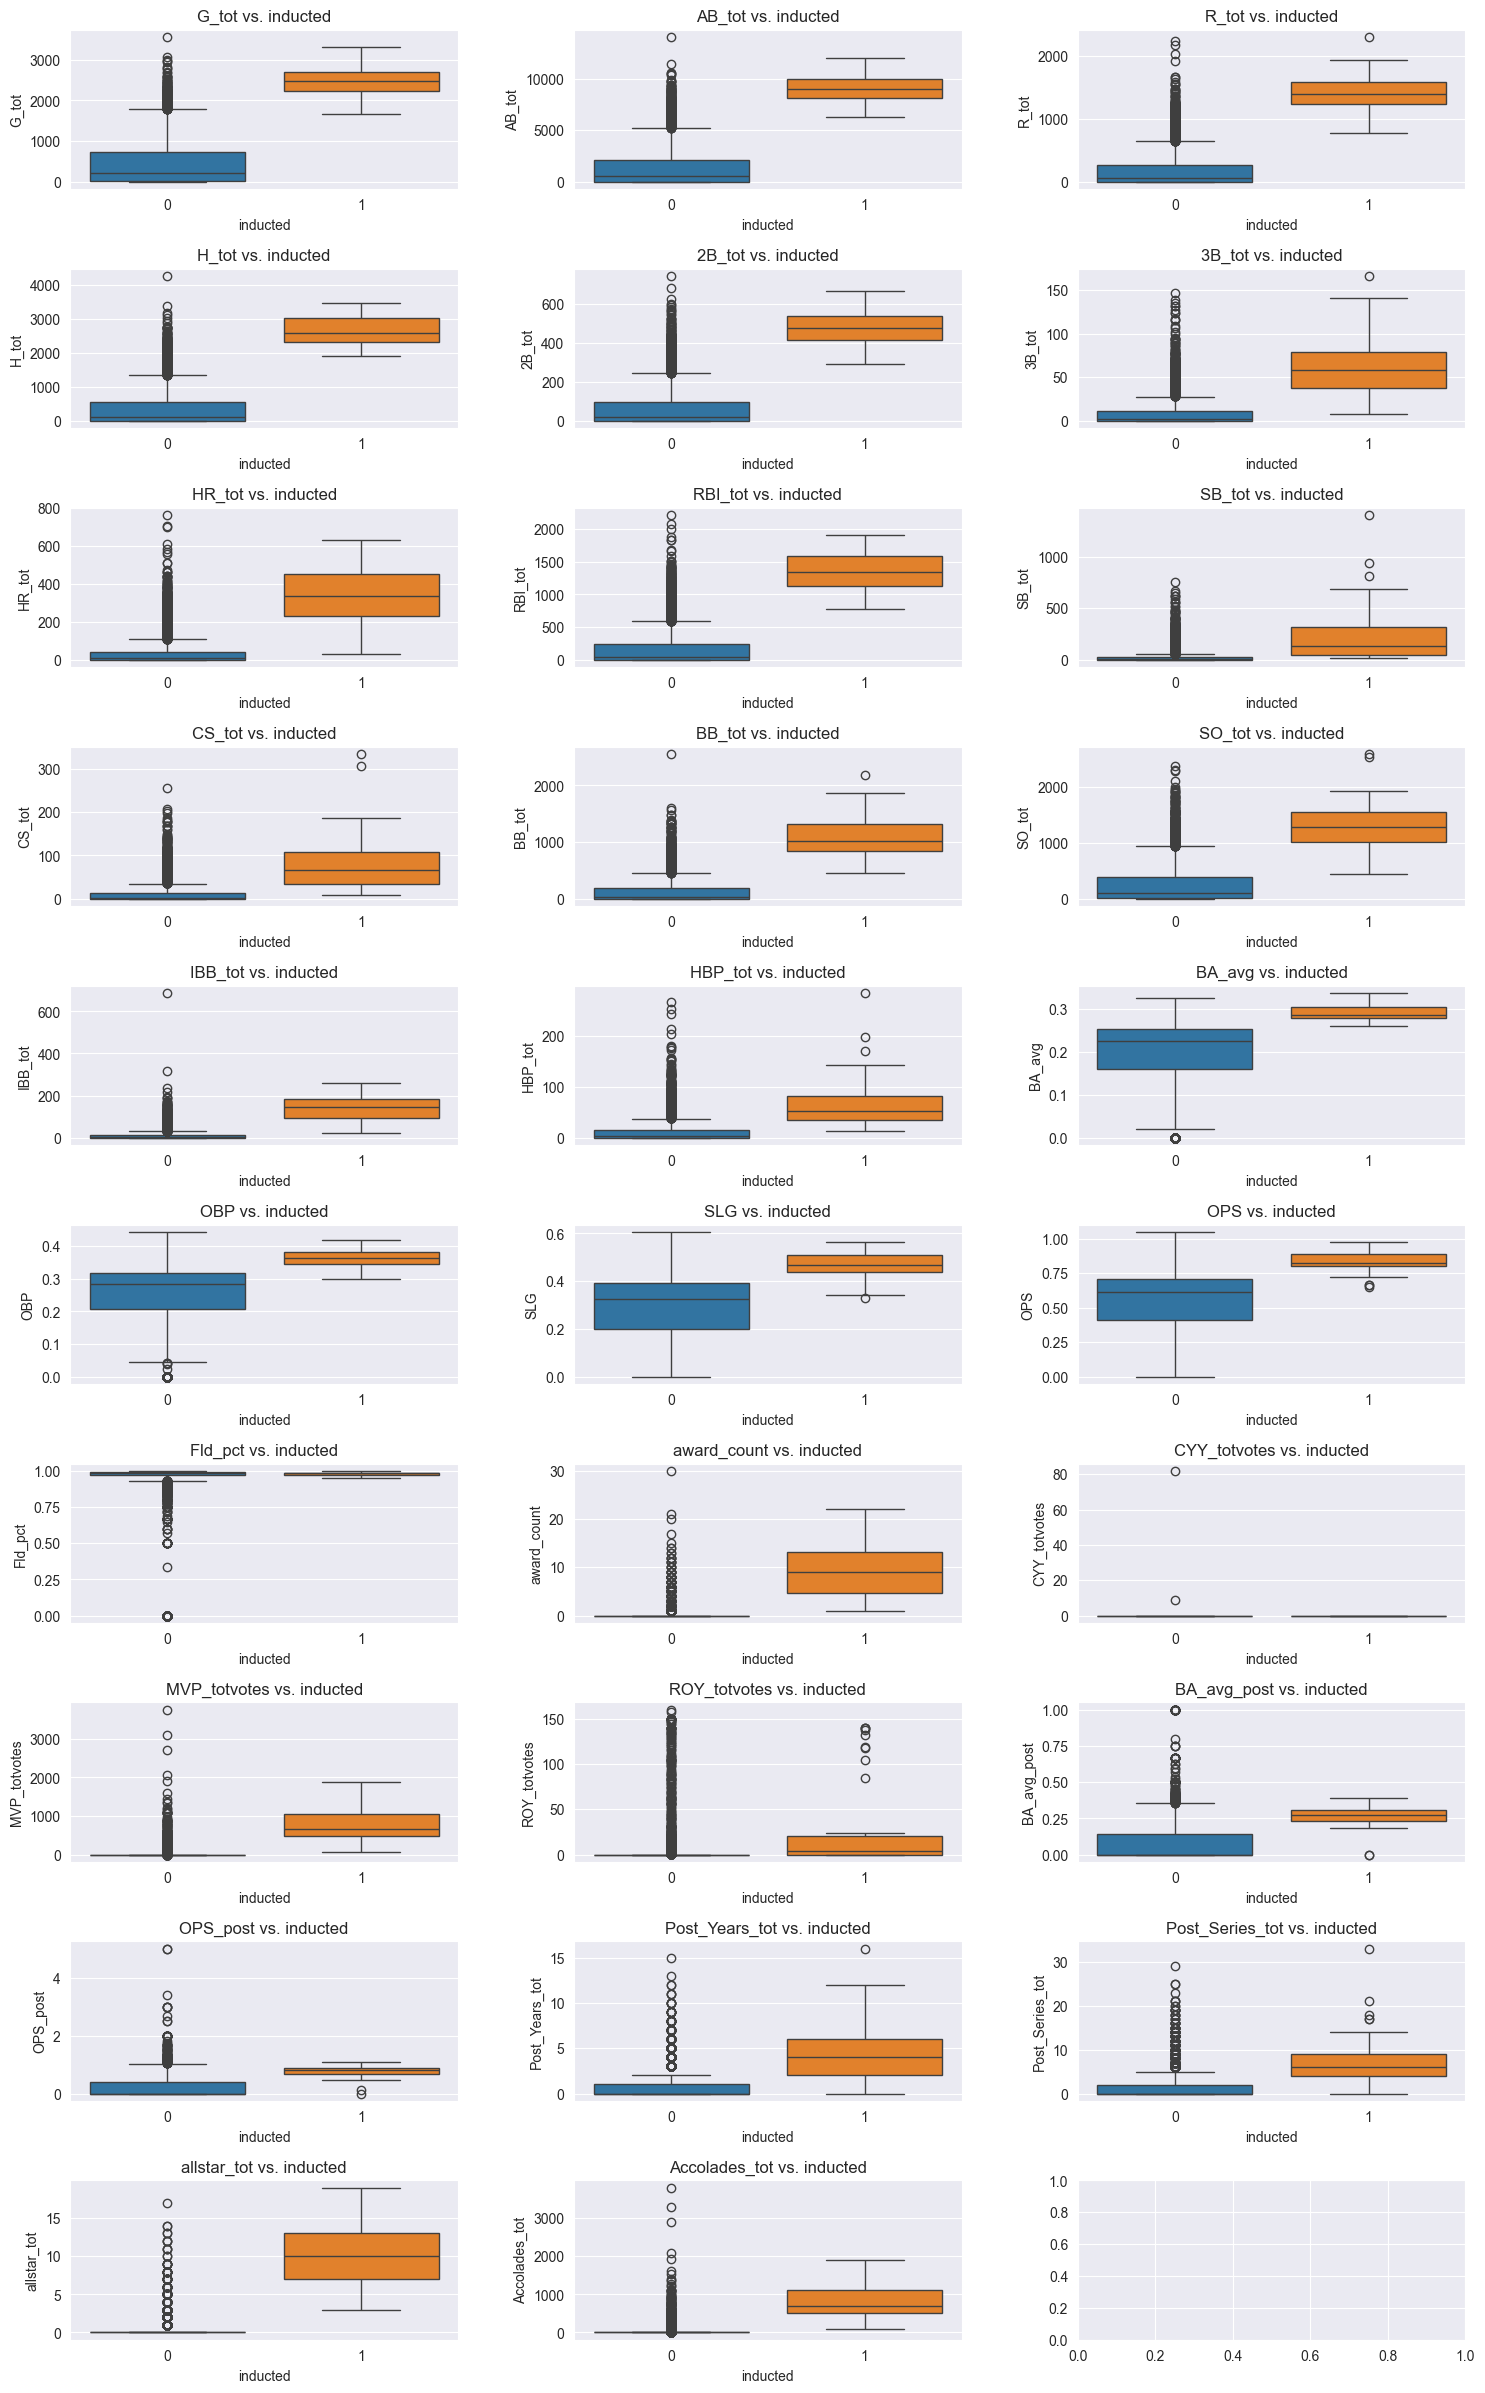

In [75]:
# Setting up box plots
sns.set_style("darkgrid")
fig, axes = plt.subplots(10, 3, figsize=(18, 30))

for i, variable in enumerate(column_names):
    # print (i)
    row = i // 3 # integer divide i by 3 (how many times does 3 go into i (discard the fraction))
                 # ex. 16 // 3 = 5 1/3 (discard the 1/3) = 5
    # print(row)
    col = i % 3 # modulo divide i by 3 times and get remainder (3 goes into )
                # ex. 16 % 3 = 16 - (3 * 5 = 15) = 1   so (row, column) is (5,1)
    # print(col)
    sns.boxplot(ax=axes[row, col], data=Batting_Career, x='inducted', y=variable, hue='inducted', legend=False).set(title= f'{variable} vs. inducted')

plt.subplots_adjust(wspace=0.3, hspace=0.5)
# plt.show()


### Scatterplots

In [76]:
# # setting up the scatterplot column names to be used for combinations
# column_names_scatter = Batting_Career.columns.values.tolist()
# del column_names_scatter[0]
# del column_names_scatter[-1]
# print(len(column_names_scatter))

# # Plotting scatter plots for all variable combinations
# sns.set_style("darkgrid")
# fig, axes = plt.subplots(136, 3, figsize=(20, 500))

# # creating combinations for scatterplot
# column_names_scatter
# combo_list = []
# for pair in itertools.combinations(column_names_scatter, 2):
#     #print(pair)
#     combo_list.append(tuple(pair))
#     #print(combo_list)
# print(len(combo_list))

# # dividing the combo lists into two so plots are neater.
# # combo_list_split = list(split(combo_list, 2))
# # combo_list1 = combo_list_split[0]
# # combo_list2 = combo_list_split[1]
# # combo_list3 = combo_list_split[2]
# # combo_list4 = combo_list_split[3]
# # combo_list5 = combo_list_split[4]
# # combo_list6 = combo_list_split[5]

# # enumerating the combinations for scatterplot subplots

# for i, variable in enumerate(combo_list):
#     # print (i)
#     row = i // 3 # integer divide i by 3 (how many times does 3 go into i (discard the fraction))
#                  # ex. 16 // 3 = 5 1/3 (discard the 1/3) = 5
#     # print(row)
#     col = i % 3 # modulo divide i by 3 times and get remainder (3 goes into )
#                 # ex. 16 % 3 = 16 - (3 * 5 = 15) = 1   so (row, column) is (5,1)
#     # print(col)
    
#     # setting up the x values
#     X_value = combo_list[i][0]
#     # setting up the y values
#     Y_value = combo_list[i][1]
    
#     # the scatter plot with regression line
#     sns.regplot(x = X_value, y = Y_value, data = Batting_Career, ax=axes[row, col], line_kws=dict(color="r"))

# plt.subplots_adjust(wspace=0.3, hspace=0.5)

### Heatmap

<Axes: >

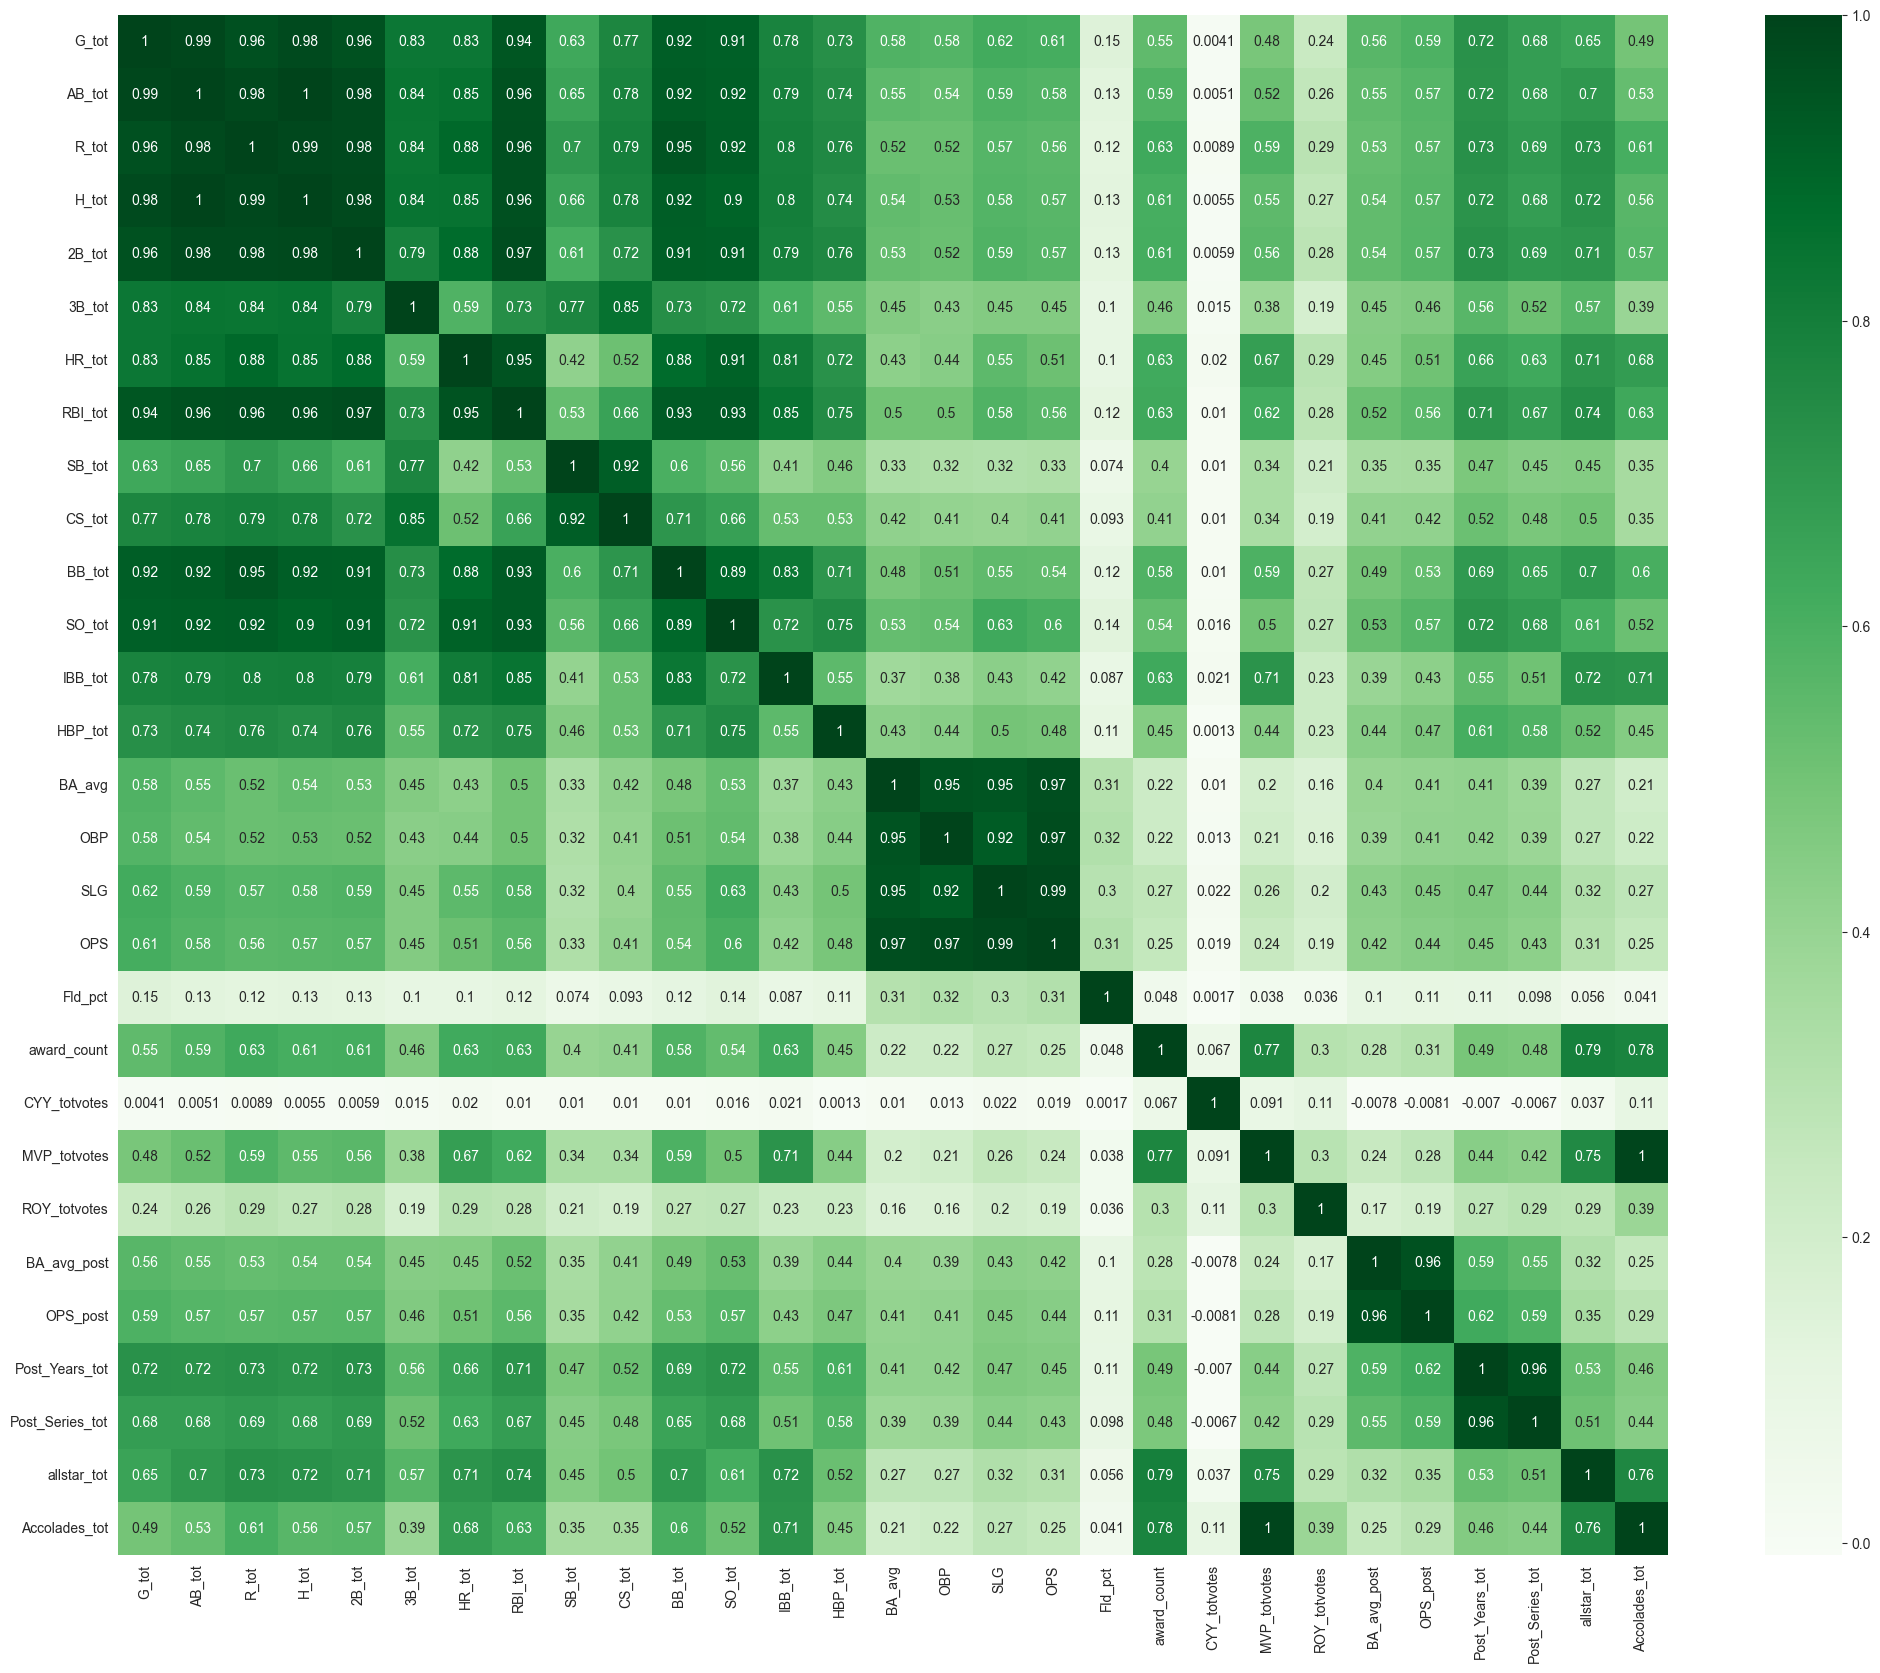

In [77]:
# Heatmap
fig, ax = plt.subplots(figsize=(25,20)) 

matrix = Batting_Career.iloc[:,1:30].corr()

#plotting correlation matrix 
sns.heatmap(matrix, cmap="Greens", annot=True)

In [78]:
np.tril([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], 1) 


array([[ 1,  2,  0],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [79]:
# A good amount of variable combinations have large correlation values and show multicollinearity symptoms.
largest_10 = matrix.where(~np.tril(np.ones(
    matrix.shape, dtype=bool))).stack().nlargest(54)

print(largest_10)

AB_tot          H_tot              0.996359
MVP_totvotes    Accolades_tot      0.995200
G_tot           AB_tot             0.988956
R_tot           H_tot              0.986669
SLG             OPS                0.986194
AB_tot          R_tot              0.983368
H_tot           2B_tot             0.983341
G_tot           H_tot              0.979777
AB_tot          2B_tot             0.979021
R_tot           2B_tot             0.976684
OBP             OPS                0.974947
2B_tot          RBI_tot            0.968675
BA_avg          OPS                0.966843
G_tot           R_tot              0.964211
R_tot           RBI_tot            0.963809
H_tot           RBI_tot            0.961611
G_tot           2B_tot             0.959941
AB_tot          RBI_tot            0.959561
BA_avg_post     OPS_post           0.959475
Post_Years_tot  Post_Series_tot    0.959204
HR_tot          RBI_tot            0.952597
BA_avg          OBP                0.951868
R_tot           BB_tot          

In [80]:
smallest_10 = matrix.where(~np.tril(np.ones(
    matrix.shape, dtype=bool))).stack().nsmallest(5)
print(smallest_10)

CYY_totvotes  OPS_post          -0.008091
              BA_avg_post       -0.007843
              Post_Years_tot    -0.006984
              Post_Series_tot   -0.006722
HBP_tot       CYY_totvotes       0.001282
dtype: float64


### Q-Q Plots

In [81]:
numerical_cols = Batting_Career.iloc[:,1:30].columns
len(numerical_cols)

29

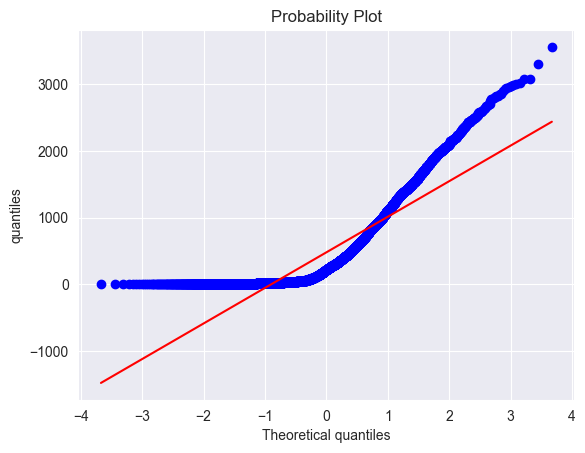

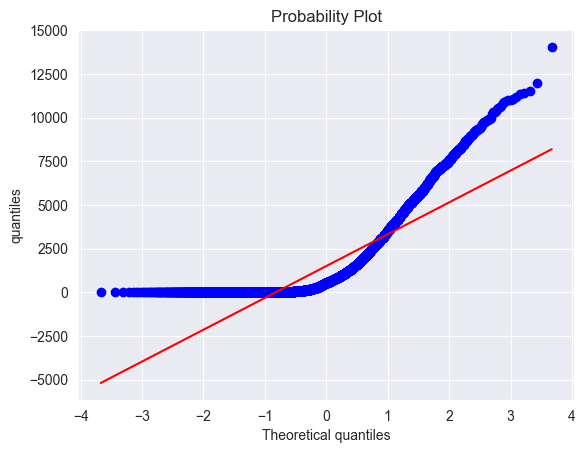

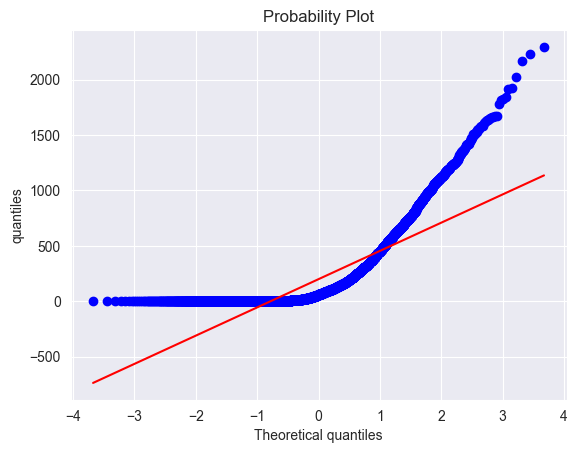

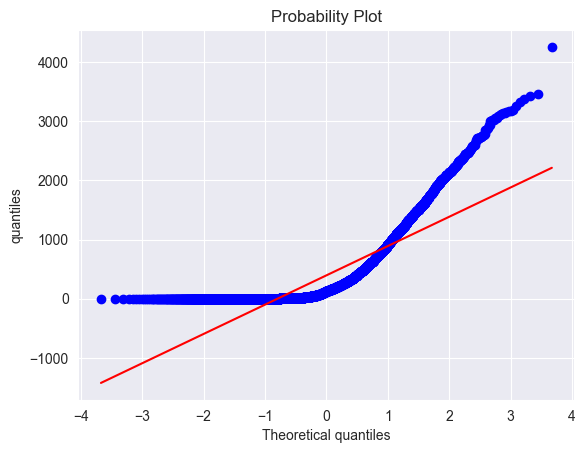

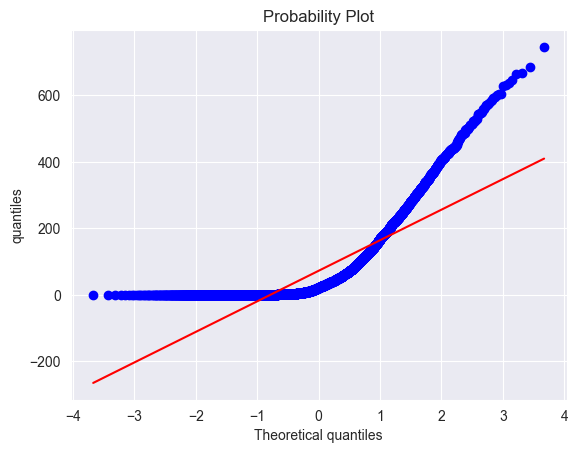

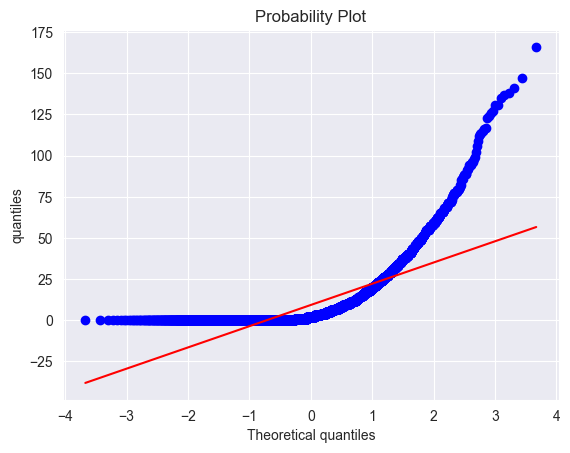

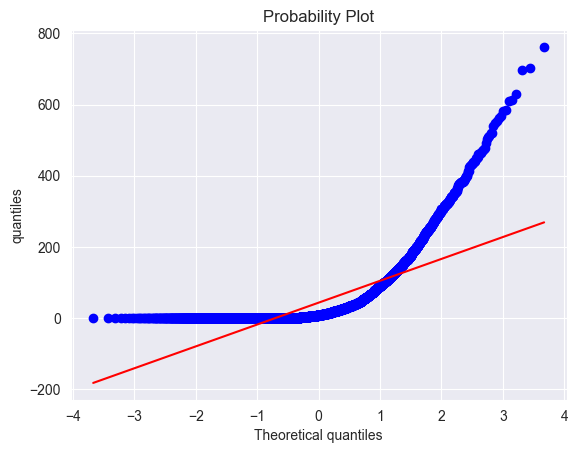

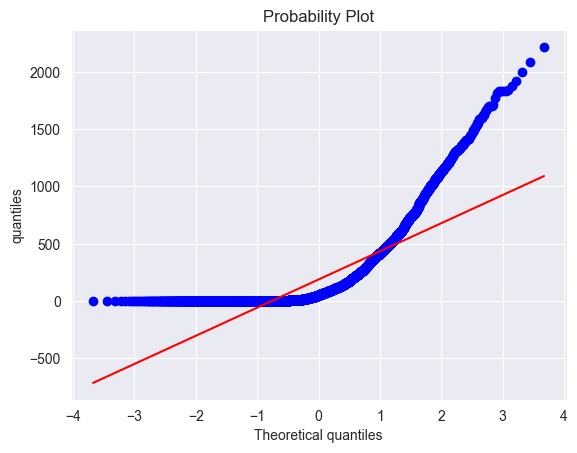

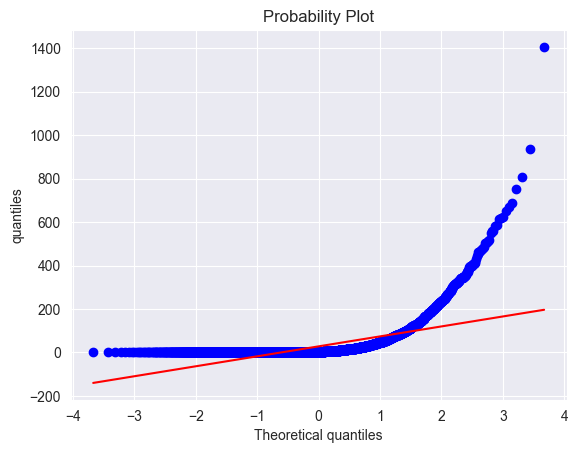

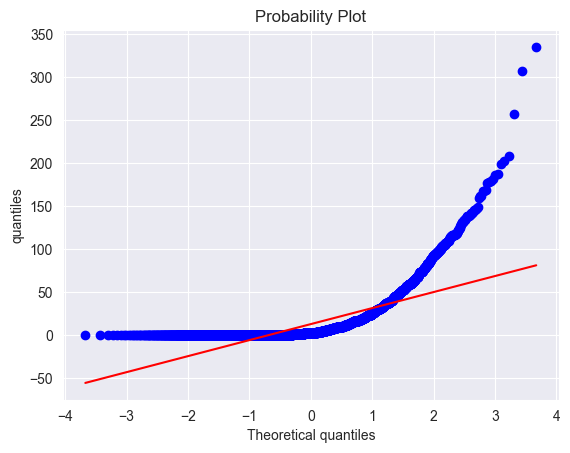

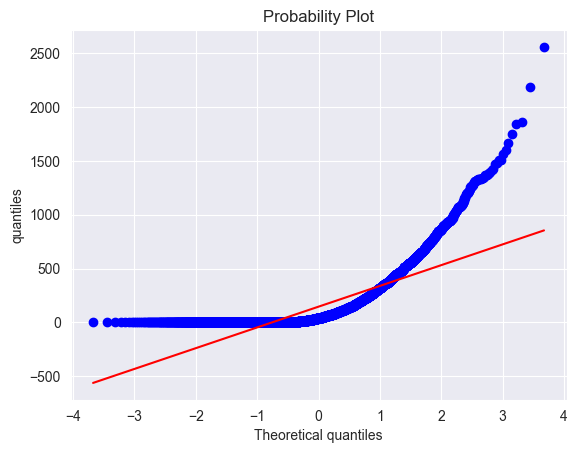

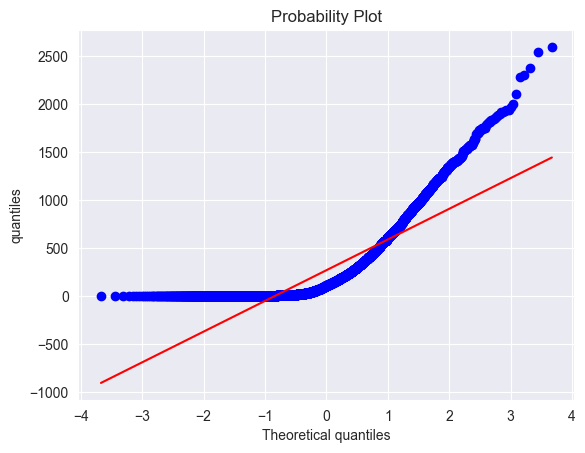

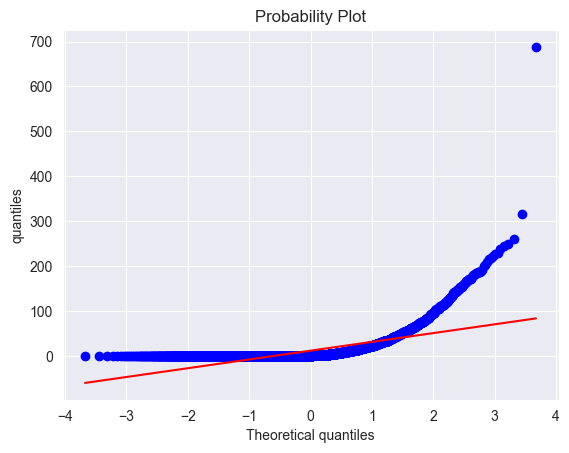

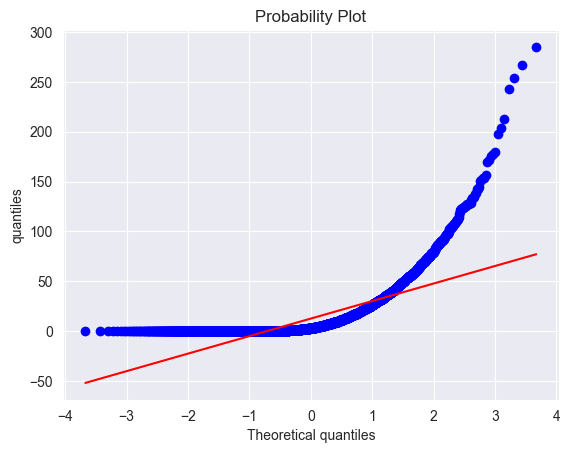

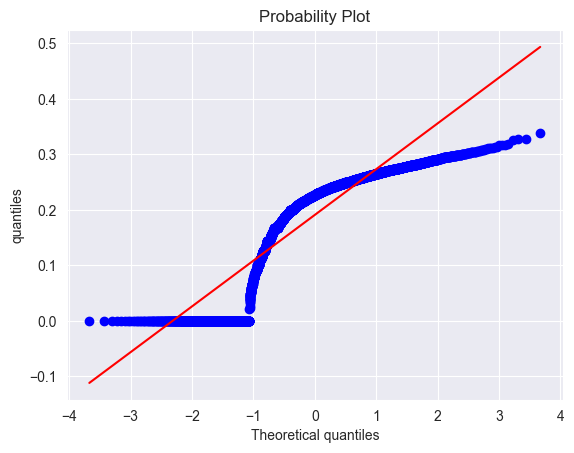

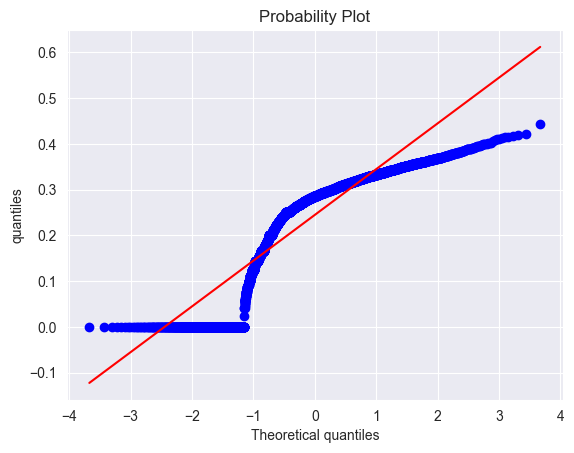

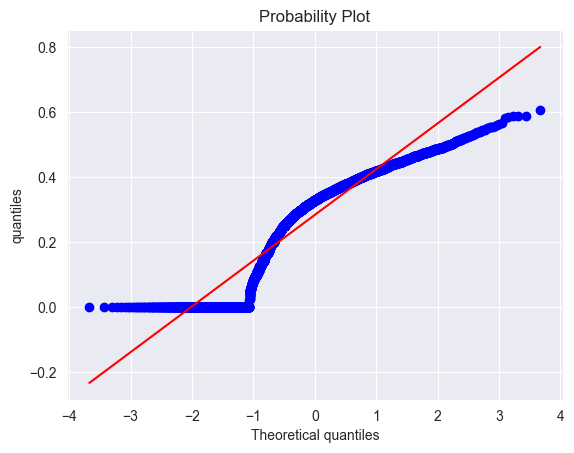

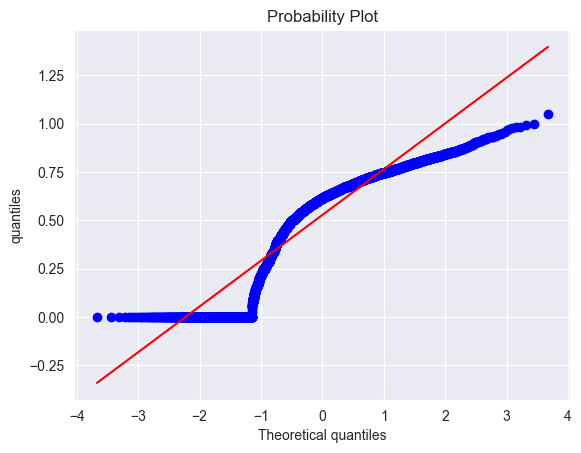

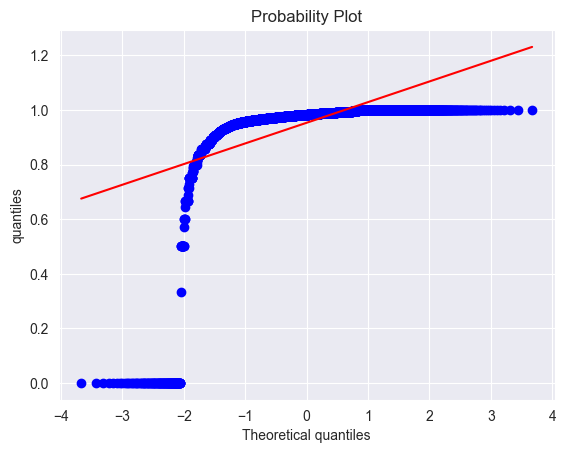

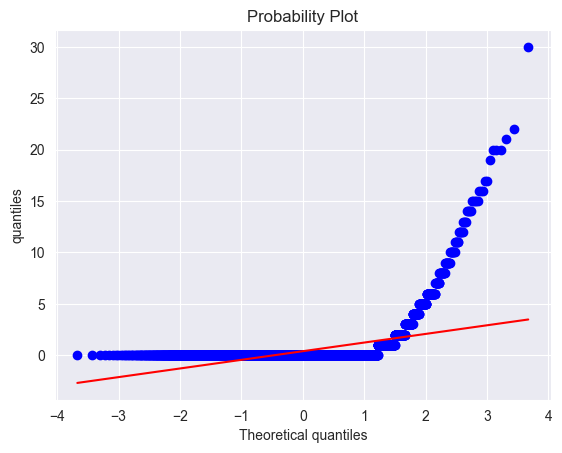

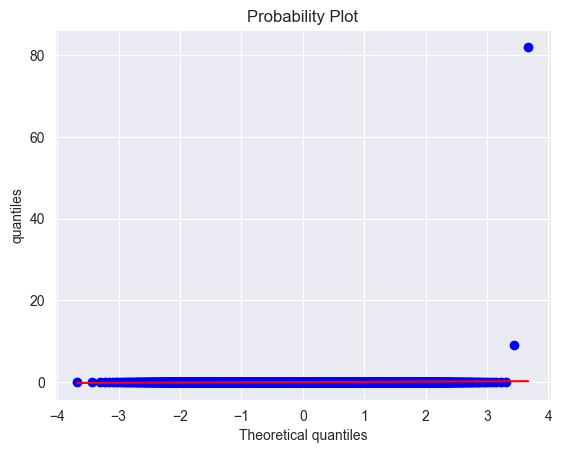

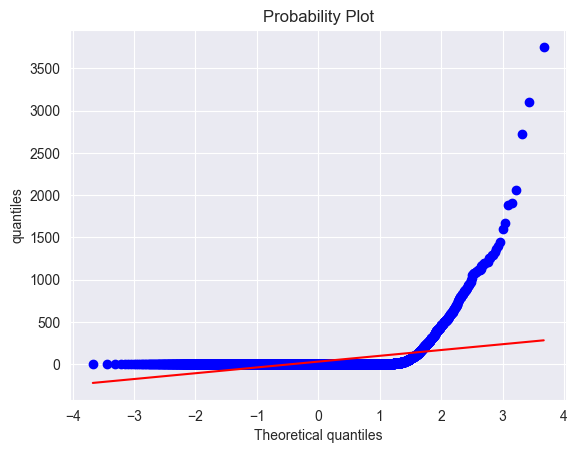

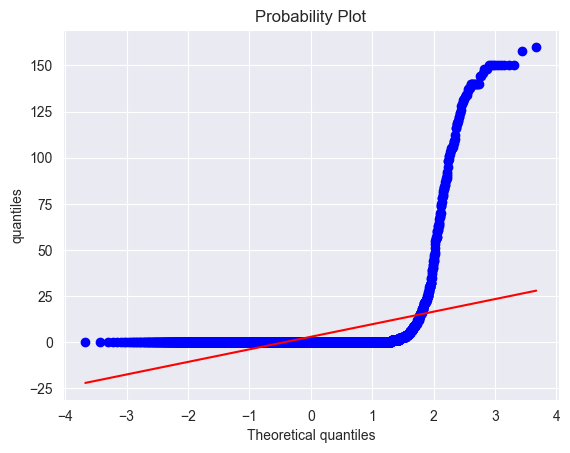

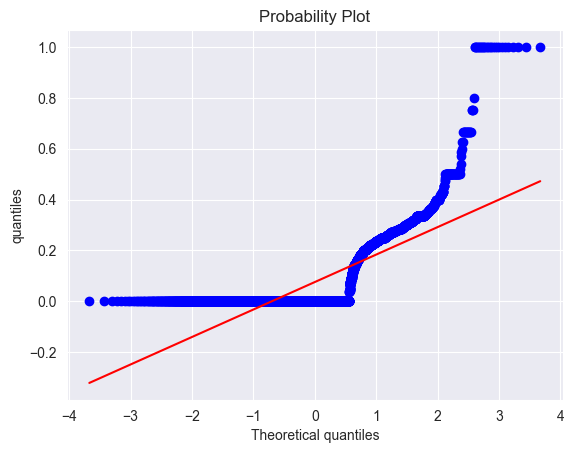

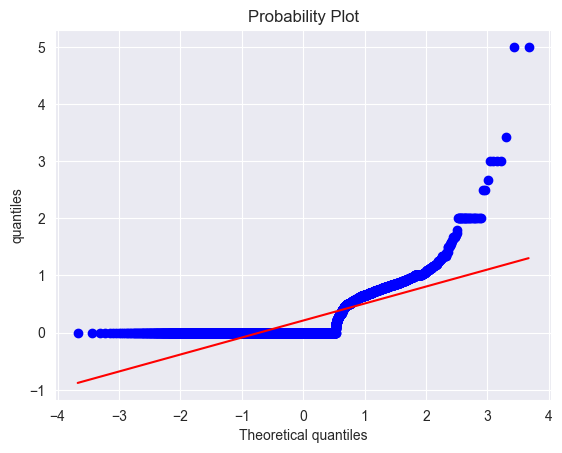

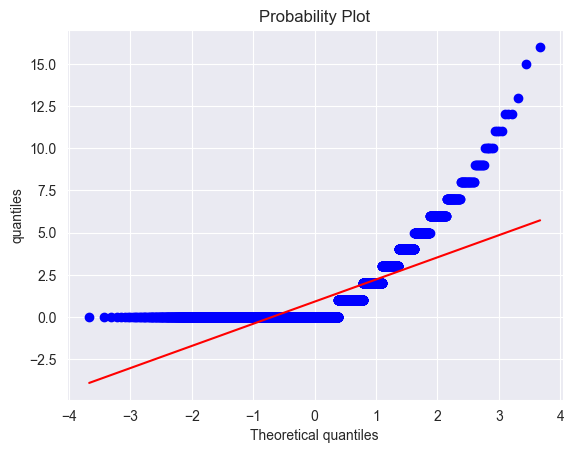

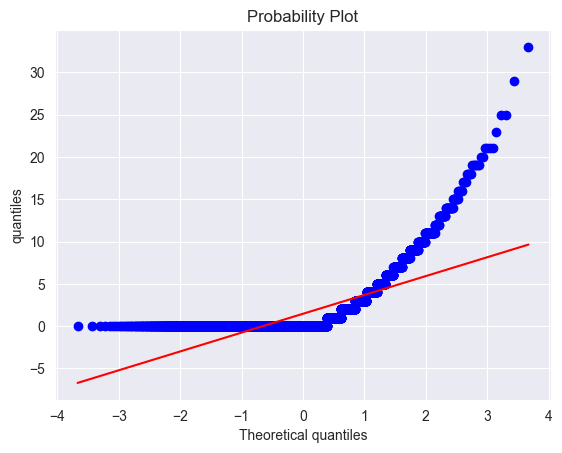

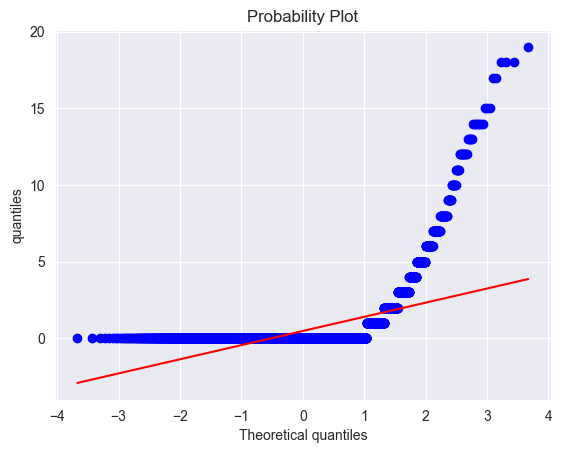

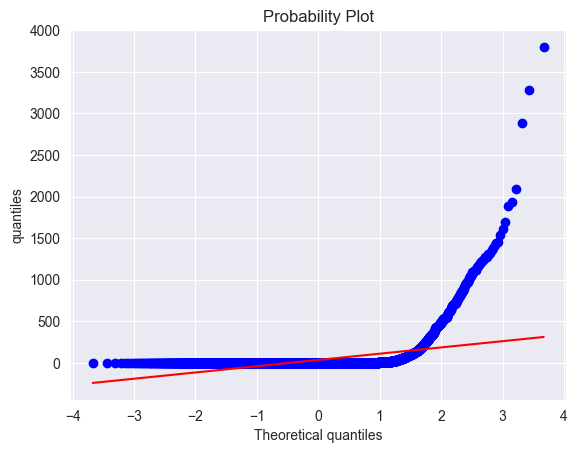

In [82]:
for col in numerical_cols:
    stats.probplot(Batting_Career[col], dist="norm", plot=plt)
    plt.ylabel('quantiles')
    plt.show()

Data is FAR from normal according to Q-Q Plots. Most of our population has a mean of zero and then spirals up. This will mess up some of my classifiers that assume a normal distribution.

Looking at the scatterplots and Heatmaps there are instances in which there is high collinearity present, for example At bats (G) vs. Games (G) both have a positive 0.99 correlation score which makes sense as a player plays more games they get more at bats so both increase hand in hand (Which the same is true for variables like Runs (R), ). A lot of positive multicollinearity present it seems but for certain variables such as CYY_totvotes (Votes for the CY Young award, an award for pitchers, Shohei is the only one with CYY votes in dataframe) and Fld_pct (Fielding percent, measure that reflects the percentage of times a defensive player properly handles a batted or thrown ball) both are the least correlated varaibles when compared to all other variables which make sense since we are comparing pitching and fielding to batting stats.

This will be taken into consideration as I decide on variables I want to test in my various learning models. I will analyze and determine which variables it makes sense to keep and which to remove.

## Hypothesis Testing

I will start by building a logistic model that utilizes all of the columns from my data (my null model) and see how it performs before making changes.

One of the challenges I will face is a class imbalance with my data. In my population only 0.87% (60) of the total 6889 pitchers are in the hall of fame. 

In [83]:
print('Total Batters in dataframe:' + ' ' + str(len(Batting_Career)))
print('Number of Batters in Hall of Fame:' + ' ' + str(len(Batting_Career.loc[Batting_Career['inducted'] == 1])))
print('Number of Batters NOT in Hall of Fame:' + ' ' + str(len(Batting_Career.loc[Batting_Career['inducted'] == 0])))
hof_batters = len(Batting_HOF)
tot_batters = len(Batting_Career)
percent = round(hof_batters/tot_batters * 100, 2)
print('percent of batters in Hall of Fame:' + ' ' + str(percent)+ '%')

Total Batters in dataframe: 5744
Number of Batters in Hall of Fame: 60
Number of Batters NOT in Hall of Fame: 5684
percent of batters in Hall of Fame: 1.04%


In [84]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [85]:
Batting_Career.columns

Index(['playerID', 'G_tot', 'AB_tot', 'R_tot', 'H_tot', '2B_tot', '3B_tot',
       'HR_tot', 'RBI_tot', 'SB_tot', 'CS_tot', 'BB_tot', 'SO_tot', 'IBB_tot',
       'HBP_tot', 'BA_avg', 'OBP', 'SLG', 'OPS', 'Fld_pct', 'award_count',
       'CYY_totvotes', 'MVP_totvotes', 'ROY_totvotes', 'BA_avg_post',
       'OPS_post', 'Post_Years_tot', 'Post_Series_tot', 'allstar_tot',
       'Accolades_tot', 'inducted'],
      dtype='object')

In [86]:
# Setting up columns I want to use to make predictions
X = Batting_Career[[
 'G_tot', 'AB_tot', 'R_tot', 'H_tot', '2B_tot', '3B_tot',
       'HR_tot', 'RBI_tot', 'SB_tot', 'CS_tot', 'BB_tot', 'SO_tot', 'IBB_tot',
       'HBP_tot', 'BA_avg', 'OBP', 'SLG', 'OPS', 'Fld_pct', 'award_count',
       'CYY_totvotes', 'MVP_totvotes', 'ROY_totvotes', 'BA_avg_post',
       'OPS_post', 'Post_Years_tot', 'Post_Series_tot', 'allstar_tot',
       'Accolades_tot']]

# setting up my predicted value
y = Batting_Career['inducted'] # indicator

In [87]:
Batting_Career

,playerID,G_tot,AB_tot,R_tot,H_tot,2B_tot,3B_tot,HR_tot,RBI_tot,SB_tot,...,CYY_totvotes,MVP_totvotes,ROY_totvotes,BA_avg_post,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,Accolades_tot,inducted
0,aaronto01,437,944,102,216,42,6,13,94.0,9.0,...,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0
1,abadan01,15,21,1,2,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
2,abbotje01,233,596,82,157,33,2,18,83.0,6.0,...,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0
3,abbotku01,702,2044,273,523,109,23,62,242.0,22.0,...,0.0,0.0,0.0,0.218750,0.523674,2.0,6.0,0.0,0.0,0
4,abercre01,180,386,65,86,20,2,9,34.0,18.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5739,zoskyed01,44,50,4,8,1,2,0,3.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
5740,zuninmi01,892,2798,326,557,121,5,149,372.0,2.0,...,0.0,1.0,0.0,0.161765,0.536040,2.0,5.0,1.0,2.0,0
5741,zupcibo01,319,795,99,199,47,4,7,80.0,7.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
5742,zupofr01,16,18,3,3,1,0,0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0


Since my data has a huge unbalance between hall of fame ('1') and non hall of fame palyers ('0') I will be using the stratified KFold method to try to balance target variable in both training and validation test as much as possible.

In [88]:
# NULL MODEL (USING ALL MY VARIABLES)
# choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

fold = 0
aucs = []
prec = []
accu = []
tp = 0
fn = 0
fp = 0
y_actu = []
y_pred = []
y_prob = []

val_pop = pd.DataFrame()

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    modelLogReg = LogisticRegression(solver='liblinear',max_iter=1000)
    modelLogReg.fit(X_tr, y_tr)
    pred = modelLogReg.predict(X_val)
    pred_prob = modelLogReg.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    pre_score = precision_score(y_val, pred)

    print(f"======= Fold {fold} ========")
    cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
    print(cfm)
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
    )
    fold += 1
    val_pop = pd.concat([val_pop, X_val])
    y_val = y_val.tolist()
    y_actu.extend(y_val)
    pred = pred.tolist()
    y_pred.extend(pred)
    pred_prob = pred_prob.tolist()
    y_prob.extend(pred_prob)
    aucs.append(auc_score)
    prec.append(pre_score)
    accu.append(acc_score)
    tp = tp + int(cfm[0,0])
    fn = fn + int(cfm[0,1])
    fp = fp + int(cfm[1,0])
oof_auc = np.mean(aucs)
prec_mean = np.mean(prec)
accu_mean = np.mean(acc_score)
val_pop['y_val'] = y_actu
val_pop['y_pred'] = y_pred
val_pop['y_prob'] = y_prob
print(f'Total TP: {tp}, Total FN: {fn}, and Total FP: {fp}')
print(f'Our average accuracy is {accu_mean:0.4f}, average precision is {prec_mean:0.4f}, and out of fold AUC score is {oof_auc:0.4f}')

======= Fold 0 ========
[[   6    6]
 [   4 1133]]
Our accuracy on the validation set is 0.9913, precision is 0.6000, and AUC is 0.9971
======= Fold 1 ========
[[   4    8]
 [   1 1136]]
Our accuracy on the validation set is 0.9922, precision is 0.8000, and AUC is 0.9946
======= Fold 2 ========
[[   5    7]
 [   0 1137]]
Our accuracy on the validation set is 0.9939, precision is 1.0000, and AUC is 0.9937
======= Fold 3 ========
[[   7    5]
 [   1 1136]]
Our accuracy on the validation set is 0.9948, precision is 0.8750, and AUC is 0.9990
======= Fold 4 ========
[[   8    4]
 [  11 1125]]
Our accuracy on the validation set is 0.9869, precision is 0.4211, and AUC is 0.9937
Total TP: 30, Total FN: 30, and Total FP: 17
Our average accuracy is 0.9869, average precision is 0.7392, and out of fold AUC score is 0.9956


In [89]:
# Baseline
accuracy_score(y, np.zeros_like(y)), precision_score(y, np.zeros_like(y)), roc_auc_score(y, np.zeros_like(y))

c:\Users\izquian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.9895543175487466, np.float64(0.0), np.float64(0.5))

We see in the above models with 5 fold CV that while our accuracy and AUC is relatively high, our precision is a little above 0.65. in fact looking at the confusion matrices we see that the accuracy is only high because there are not a lot of positive ('1' Hall of Fame batter). Looking at our baseline even if one guessed the entire dataset to be negative ('0' Non-Hall of Fame pitcher) they would still get a high accuracy score but a poor AUC and precision score. This could be due to a lot of factors with the most probable one being high dimensionality and the presence of collinearity: we are using 29 columns to train our model, some which as proved above are highly correlated to one another. I will use the statsmodel package to get the model summary and look at the model summary to draw findings such as p-value, etc.

### Removing Multicollinearity from dataset

In [90]:
# removing multicollinearity from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x

In [91]:
# Removing highly Collinear columns
removed_df = remove_collinear_features(X, 0.95)

AB_tot | G_tot | 0.99
R_tot | G_tot | 0.96
R_tot | AB_tot | 0.98
H_tot | G_tot | 0.98
H_tot | AB_tot | 1.0
H_tot | R_tot | 0.99
2B_tot | G_tot | 0.96
2B_tot | AB_tot | 0.98
2B_tot | R_tot | 0.98
2B_tot | H_tot | 0.98
RBI_tot | AB_tot | 0.96
RBI_tot | R_tot | 0.96
RBI_tot | H_tot | 0.96
RBI_tot | 2B_tot | 0.97
RBI_tot | HR_tot | 0.95
OBP | BA_avg | 0.95
OPS | BA_avg | 0.97
OPS | OBP | 0.97
OPS | SLG | 0.99
OPS_post | BA_avg_post | 0.96
Post_Series_tot | Post_Years_tot | 0.96
Accolades_tot | MVP_totvotes | 1.0
Removed Columns {'AB_tot', 'RBI_tot', 'R_tot', 'H_tot', 'Post_Series_tot', '2B_tot', 'OPS', 'OPS_post', 'Accolades_tot', 'OBP'}


In [92]:
removed_df

,G_tot,3B_tot,HR_tot,SB_tot,CS_tot,BB_tot,SO_tot,IBB_tot,HBP_tot,BA_avg,SLG,Fld_pct,award_count,CYY_totvotes,MVP_totvotes,ROY_totvotes,BA_avg_post,Post_Years_tot,allstar_tot
0,437,6,13,9.0,8.0,86,145.0,3.0,0.0,0.228814,0.327331,0.984848,0.0,0.0,0.0,0.0,0.000000,1.0,0.0
1,15,0,0,0.0,1.0,4,5.0,0.0,0.0,0.095238,0.095238,0.974359,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,233,2,18,6.0,5.0,38,91.0,2.0,3.0,0.263423,0.416107,0.974110,0.0,0.0,0.0,0.0,0.000000,1.0,0.0
3,702,23,62,22.0,11.0,133,571.0,11.0,17.0,0.255871,0.422701,0.965336,0.0,0.0,0.0,0.0,0.218750,2.0,0.0
4,180,2,9,18.0,8.0,21,123.0,2.0,7.0,0.222798,0.354922,0.978947,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5739,44,2,0,0.0,0.0,1,13.0,0.0,0.0,0.160000,0.260000,0.966667,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5740,892,5,149,2.0,4.0,219,1088.0,1.0,60.0,0.199071,0.405647,0.994895,0.0,0.0,1.0,0.0,0.161765,2.0,1.0
5741,319,4,7,7.0,5.0,57,137.0,3.0,6.0,0.250314,0.345912,0.976789,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5742,16,0,0,0.0,0.0,2,6.0,0.0,0.0,0.166667,0.222222,0.941176,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


### Significant indicators

In [93]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE

# Creating the formula string 
# all_columns = ' + '.join(removed_df.columns)
# formula = "inducted ~ " + all_columns 
# print("Formula: ", formula, "\n")
# print(all_columns)
cols = removed_df.columns
cols

Index(['G_tot', '3B_tot', 'HR_tot', 'SB_tot', 'CS_tot', 'BB_tot', 'SO_tot',
       'IBB_tot', 'HBP_tot', 'BA_avg', 'SLG', 'Fld_pct', 'award_count',
       'CYY_totvotes', 'MVP_totvotes', 'ROY_totvotes', 'BA_avg_post',
       'Post_Years_tot', 'allstar_tot'],
      dtype='object')

In [94]:
# Using RFE on all features in my dataset to select the top 10
full = ['G_tot', 'AB_tot', 'R_tot', 'H_tot', '2B_tot', '3B_tot',
       'HR_tot', 'RBI_tot', 'SB_tot', 'CS_tot', 'BB_tot', 'SO_tot', 'IBB_tot',
       'HBP_tot', 'BA_avg', 'OBP', 'SLG', 'OPS', 'Fld_pct', 'award_count',
       'CYY_totvotes', 'MVP_totvotes', 'ROY_totvotes', 'BA_avg_post',
       'OPS_post', 'Post_Years_tot', 'Post_Series_tot', 'allstar_tot',
       'Accolades_tot']

# Setting up columns I want to use to make predictions
X = Batting_Career[full]

# setting up my predicted value
y = Batting_Career['inducted'] # indicator

# Create a logistic regression model
model = LogisticRegression(solver='liblinear',max_iter = 1000)

# Use RFE to select the top 10 features
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X, y)

# Print the selected features
print(X.columns[rfe.support_])

Index(['BA_avg', 'OBP', 'SLG', 'OPS', 'Fld_pct', 'BA_avg_post', 'OPS_post',
       'Post_Years_tot', 'Post_Series_tot', 'allstar_tot'],
      dtype='object')


In [95]:
# Running Lasso Regression (L1 Regularization)

# Create a logistic regression model with L1 regularization
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X, y)

# Get the coefficients
coefs = pd.Series(model.coef_[0], index=X.columns)

# Select features with non-zero coefficients
selected_features = coefs[coefs != 0].index
print(selected_features)

Index(['G_tot', 'AB_tot', 'R_tot', 'H_tot', '2B_tot', '3B_tot', 'HR_tot',
       'RBI_tot', 'SB_tot', 'CS_tot', 'BB_tot', 'SO_tot', 'IBB_tot', 'HBP_tot',
       'Fld_pct', 'award_count', 'MVP_totvotes', 'ROY_totvotes',
       'Post_Years_tot', 'Post_Series_tot', 'allstar_tot', 'Accolades_tot'],
      dtype='object')


In [96]:
from sklearn.feature_selection import SelectKBest, chi2

# Select top k features based on chi-squared test
k = 10
selector = SelectKBest(chi2, k=k)
selector.fit(X, y)

# Get the selected features
selected_features = X.columns[selector.get_support()]
print(selected_features)


Index(['G_tot', 'AB_tot', 'R_tot', 'H_tot', '2B_tot', 'RBI_tot', 'BB_tot',
       'SO_tot', 'MVP_totvotes', 'Accolades_tot'],
      dtype='object')


In [97]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Create a logistic regression model
model = LogisticRegression(solver='liblinear', max_iter=5000)

# Use FSSearch to select the top 10 features
sfs1 = SFS(model, 
           k_features=29, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='f1',
           cv=0)

sfs1 = sfs1.fit(X, y)


[2025-02-19 10:41:57] Features: 1/29 -- score: 0.5961538461538461
[2025-02-19 10:41:57] Features: 2/29 -- score: 0.6274509803921569
[2025-02-19 10:41:58] Features: 3/29 -- score: 0.6407766990291263
[2025-02-19 10:41:58] Features: 4/29 -- score: 0.6407766990291263
[2025-02-19 10:41:59] Features: 5/29 -- score: 0.6407766990291263
[2025-02-19 10:42:00] Features: 6/29 -- score: 0.6601941747572816
[2025-02-19 10:42:01] Features: 7/29 -- score: 0.6730769230769231
[2025-02-19 10:42:02] Features: 8/29 -- score: 0.6730769230769231
[2025-02-19 10:42:03] Features: 9/29 -- score: 0.6923076923076923
[2025-02-19 10:42:05] Features: 10/29 -- score: 0.7047619047619048
[2025-02-19 10:42:07] Features: 11/29 -- score: 0.7047619047619048
[2025-02-19 10:42:09] Features: 12/29 -- score: 0.7047619047619048
[2025-02-19 10:42:11] Features: 13/29 -- score: 0.7047619047619048
[2025-02-19 10:42:13] Features: 14/29 -- score: 0.7047619047619048
[2025-02-19 10:42:14] Features: 15/29 -- score: 0.7047619047619048
[20

In [98]:
# Setting up columns I want to use to make predictions
X = Batting_Career[full]

# setting up my predicted value
y = Batting_Career['inducted'] # indicator

In [99]:
# Setting up columns I want to use to make predictions
X = Batting_Career[['BA_avg', 'OBP', 'SLG', 'OPS', 'Fld_pct', 'BA_avg_post', 'OPS_post',
       'Post_Years_tot', 'Post_Series_tot', 'allstar_tot']]

# setting up my predicted value
y = Batting_Career['inducted'] # indicator

In [100]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5744 entries, 0 to 5743
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BA_avg           5744 non-null   float64
 1   OBP              5744 non-null   float64
 2   SLG              5744 non-null   float64
 3   OPS              5744 non-null   float64
 4   Fld_pct          5744 non-null   float64
 5   BA_avg_post      5744 non-null   float64
 6   OPS_post         5744 non-null   float64
 7   Post_Years_tot   5744 non-null   float64
 8   Post_Series_tot  5744 non-null   float64
 9   allstar_tot      5744 non-null   float64
dtypes: float64(10)
memory usage: 448.9 KB


In [101]:
# Putting the training predictors and responses into one DataFrame to be input into the model
trainingdata = pd.concat([X,y], axis = 1)

# Build the model
log_reg_1 = sm.Logit(y, X).fit()
log_reg_1.summary()

Optimization terminated successfully.
         Current function value: 0.034006
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               inducted   No. Observations:                 5744
Model:                          Logit   Df Residuals:                     5735
Method:                           MLE   Df Model:                            8
Date:                Wed, 19 Feb 2025   Pseudo R-squ.:                  0.4141
Time:                        10:42:38   Log-Likelihood:                -195.33
converged:                       True   LL-Null:                       -333.38
Covariance Type:            nonrobust   LLR p-value:                 4.969e-55
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
BA_avg             -3.9995      6.728     -0.594      0.552     -17.187       9.188
OBP                -7.6673   1.43e+07  -5.37e-07      1.000    -2.8e+07     2.8e+07
SLG                 7.2279   1.43e+07   5.06e-07      1.000    -2.8e+07     2.8e+07
OPS                -0.4394   1.43e+07  -3.08e-08      1.000    -2.8e+07     2.8e+07
Fld_pct            -6.8444      0.686     -9.978      0.000      -8.189      -5.500
BA_avg_post         2.3910      2.331      1.026      0.305      -2.177       6.959
OPS_post            0.6533      0.763      0.857      0.392      -0.842       2.148
Post_Years_tot      0.2185      0.211      1.036      0.300      -0.195       0.632
Post_Series_tot    -0.1580      0.111     -1.423      0.155      -0.376       0.060
allstar_tot         0.6816      0.060     11.303      0.000       0.563       0.800
===================================================================================
"""

Looking at the Regression result we see that it has fit and sucessfully converged. The Pseudo R-squared has a value of just under 0.5 which tells us that the model isn't doing an amazing job at explaining the variablility in the outcome variable, but it also is not high enough to have fear for overfitting. The P-value for the likelihood ratio test suggests that the fitted model provides a better fit than the null model. Looking at the variables we see that mostly all of these seem significant, even the ones with relatively high p-values seem to have significant coefficients that can help the model make its predictions.

A quasi-separation message is received suggesting that there could possibly be complete quasi-separation which means one or more predictor variables (or combinations of predictors) can perfectly separate the outcome variable. In other words, you can perfectly predict the outcome for some subset of observations based purely on the predictor variables, if all observations with a certain combination of predictor values have the same outcome (either all 0 or all 1). This is not surprising as stated earlier the biggest challenge of this exercise was going to be the severe class imbalance having 60/6889 (0.87%) of the batting population actually be in the hall of fame. So what is most likely happening here is that there is a certain combination of predictor variables that have the same outcome 1 (Hall of Fame) and there is not a lot of variability within that Hall of Fame class.

In [102]:
# Setting up table to record all probabilities for the different models
player_probs = pd.DataFrame()

### Logistic Regression with Variables I believe are significant in making predictions

From looking at my exploratory data analysis comparing my target ('1') population to the rest of my population ('0') and combing through my target population I came to a couple conclusions that I will use in my forcasting:

1. Closers (Pitchers who come in at the end of the game for 1-2 innings to finish the game and have significantly less innings pitched and thus lower stat totals in general) will be kept since my population is already small for my target population (~0.46%). I will explain further in the second point.
    
2. Since Closers have a different function than Starting Pitchers (more meant to finish games where its close rather than start a game and pitch multiple innings). because this If I include a lot of total values from games in my data it will skew and add noise to my data.

3. Since I've come to the conclusion that total stats will only add noise to my data. I have chosen to use average BAOpp and ERA

In [103]:
# Setting up my scoring dataframe to compare all models with their performance metrics
model_score_table = pd.DataFrame(index=range(9))
model_score_table['Model'] = ''
model_score_table['roc_auc'] = ''
model_score_table['accuracy'] = ''
model_score_table['precision'] = ''
model_score_table['TPR'] = ''
model_score_table['FPR'] = ''
model_score_table['TP'] = ''
model_score_table['FN'] = ''
model_score_table['FP'] = ''
model_score_table['TN'] = ''
model_score_table

,Model,roc_auc,accuracy,precision,TPR,FPR,TP,FN,FP,TN
0,,,,,,,,,,
1,,,,,,,,,,
2,,,,,,,,,,
3,,,,,,,,,,
4,,,,,,,,,,
5,,,,,,,,,,
6,,,,,,,,,,
7,,,,,,,,,,
8,,,,,,,,,,


In [104]:
# Setting up columns I want to use to make predictions
X = Batting_Career[['H_tot', 'SB_tot', 'CS_tot', 'BA_avg', 'OBP', 'SLG', 'OPS', 'Fld_pct', 'Accolades_tot', 'OPS_post', 'Post_Years_tot', 'Post_Series_tot', 'allstar_tot']]

# setting up my predicted value
y = Batting_Career['inducted'] # indicator

In [105]:
# choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

fold = 0
aucs = []
prec = []
accu = []
tp = 0
fn = 0
fp = 0
y_actu = []
y_pred = []
y_prob = []

val_pop = pd.DataFrame()

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    modelLogReg = LogisticRegression(solver='liblinear',max_iter=1000)
    modelLogReg.fit(X_tr, y_tr)
    pred = modelLogReg.predict(X_val)
    pred_prob = modelLogReg.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    pre_score = precision_score(y_val, pred)

    print(f"======= Fold {fold} ========")
    cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
    print(cfm)
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
    )
    fold += 1
    val_pop = pd.concat([val_pop, X_val])
    y_val = y_val.tolist()
    y_actu.extend(y_val)
    pred = pred.tolist()
    y_pred.extend(pred)
    pred_prob = pred_prob.tolist()
    y_prob.extend(pred_prob)
    aucs.append(auc_score)
    prec.append(pre_score)
    accu.append(acc_score)
    tp = tp + int(cfm[0,0])
    fn = fn + int(cfm[0,1])
    fp = fp + int(cfm[1,0])
    tn = fp + int(cfm[1,1])
oof_auc = np.mean(aucs)
prec_mean = np.mean(prec)
accu_mean = np.mean(acc_score)
val_pop['y_val'] = y_actu
val_pop['y_pred'] = y_pred
val_pop['y_prob'] = y_prob
tpr = tp/(tp+fn)
fpr = fp/(tn+fp)
print(f'Total TP: {tp}, Total FN: {fn}, and Total FP: {fp}')
print(f'Our average accuracy is {accu_mean:0.4f}, average precision is {prec_mean:0.4f}, and out of fold AUC score is {oof_auc:0.4f}')
print(f'TPR is {tpr:0.4f} and FPR is {fpr:0.4f}')
model_score_table.iloc[0,0] = 'Logistic Regression'
model_score_table.iloc[0,1] = oof_auc
model_score_table.iloc[0,2] = accu_mean
model_score_table.iloc[0,3] = prec_mean
model_score_table.iloc[0,4] = tpr
model_score_table.iloc[0,5] = fpr
model_score_table.iloc[0,6] = tp
model_score_table.iloc[0,7] = fn
model_score_table.iloc[0,8] = fp
model_score_table.iloc[0,9] = tn


======= Fold 0 ========
[[   6    6]
 [   1 1136]]
Our accuracy on the validation set is 0.9939, precision is 0.8571, and AUC is 0.9960
======= Fold 1 ========
[[   4    8]
 [   1 1136]]
Our accuracy on the validation set is 0.9922, precision is 0.8000, and AUC is 0.9957
======= Fold 2 ========
[[   6    6]
 [   0 1137]]
Our accuracy on the validation set is 0.9948, precision is 1.0000, and AUC is 0.9979
======= Fold 3 ========
[[   7    5]
 [   0 1137]]
Our accuracy on the validation set is 0.9956, precision is 1.0000, and AUC is 0.9997
======= Fold 4 ========
[[   9    3]
 [   9 1127]]
Our accuracy on the validation set is 0.9895, precision is 0.5000, and AUC is 0.9944
Total TP: 32, Total FN: 28, and Total FP: 11
Our average accuracy is 0.9895, average precision is 0.8314, and out of fold AUC score is 0.9967
TPR is 0.5333 and FPR is 0.0096


#### Logistic Regression Predictions

In [106]:
val_pop = val_pop.join(Batting_Career['playerID'])
cols = val_pop.columns.tolist()
new_cols = [cols[-1]] + cols[:-1]
val_pop = val_pop[new_cols]
val_pop.head(5)

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
0,aaronto01,216,9.0,8.0,0.228814,0.291506,0.327331,0.618836,0.984848,0.0,0.000000,1.0,1.0,0.0,0,0,0.000377
1,abadan01,2,0.0,1.0,0.095238,0.240000,0.095238,0.335238,0.974359,0.0,0.000000,0.0,0.0,0.0,0,0,0.000406
2,abbotje01,157,6.0,5.0,0.263423,0.307453,0.416107,0.723561,0.974110,0.0,0.000000,1.0,1.0,0.0,0,0,0.000291
8,abregjo01,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.875000,0.0,0.000000,0.0,0.0,0.0,0,0,0.001011
9,abreubo01,2470,400.0,128.0,0.291274,0.394977,0.474764,0.869741,0.982456,73.0,0.810316,4.0,5.0,2.0,0,0,0.079768


In [107]:
player_probs['playerID'] = val_pop['playerID']
player_probs['LOR_REG_y_prob'] = val_pop['y_prob']
player_probs

,playerID,LOR_REG_y_prob
0,aaronto01,0.000377
1,abadan01,0.000406
2,abbotje01,0.000291
8,abregjo01,0.001011
9,abreubo01,0.079768
...,...,...
5735,zipfebu01,0.000170
5737,zobribe01,0.001068
5739,zoskyed01,0.000257
5741,zupcibo01,0.000235


In [108]:
# False positives
Falsepositives = val_pop.query('y_val == 0 and y_pred ==1')
val_pop.query('y_val == 0 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
5246,torrejo01,2342,23.0,29.0,0.297435,0.364816,0.452121,0.816937,0.987498,483.0,0.000000,0.0,0.0,9.0,0,1,0.573199
4182,pujolal01,3384,117.0,43.0,0.296296,0.374233,0.543823,0.918056,0.992503,3285.0,0.994591,10.0,20.0,12.0,0,1,0.601823
389,beltrca01,2725,312.0,49.0,0.278972,0.350495,0.486384,0.836879,0.986049,481.0,1.021067,7.0,15.0,9.0,0,1,0.830343
509,bondsba01,2935,514.0,141.0,0.298060,0.444295,0.606885,1.051180,0.983579,3801.0,0.936004,7.0,9.0,14.0,0,1,0.998380
561,boyerke01,2143,105.0,77.0,0.287458,0.348564,0.461838,0.810402,0.957100,479.0,0.722861,1.0,1.0,13.0,0,1,0.790894
758,cabremi01,3174,40.0,21.0,0.306489,0.382156,0.518347,0.900503,0.987746,1938.0,0.884595,5.0,11.0,13.0,0,1,0.991992
3282,mattido01,2153,14.0,9.0,0.307440,0.358329,0.471369,0.829698,0.995601,890.0,1.148333,1.0,1.0,6.0,0,1,0.598744
4425,rodrial01,3115,329.0,76.0,0.294814,0.379706,0.550161,0.929867,0.972979,2091.0,0.821576,12.0,19.0,14.0,0,1,0.988760
4508,rosepe01,4256,198.0,149.0,0.302853,0.375134,0.409308,0.784442,0.986651,1211.0,0.828258,8.0,14.0,17.0,0,1,0.994252
4980,staubru01,2716,47.0,33.0,0.279424,0.362481,0.430556,0.793037,0.980320,144.0,1.095970,1.0,2.0,6.0,0,1,0.656119


In [109]:
# False Negatives
val_pop.query('y_val == 1 and y_pred ==0')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
851,cartega01,2092,39.0,42.0,0.262451,0.334743,0.438715,0.773458,0.990768,679.0,0.786414,3.0,5.0,11.0,1,0,0.413904
3217,martied01,2247,49.0,30.0,0.311521,0.417802,0.515458,0.933260,0.951555,408.0,0.872677,4.0,7.0,7.0,1,0,0.211756
4177,puckeki01,2304,134.0,76.0,0.318056,0.359887,0.476670,0.836558,0.988879,1048.0,0.897194,2.0,4.0,10.0,1,0,0.314485
4344,riceji01,2452,58.0,34.0,0.298116,0.351928,0.502006,0.853934,0.980036,1215.0,0.678697,2.0,3.0,8.0,1,0,0.430792
4468,rolensc01,2077,118.0,49.0,0.280752,0.364330,0.490403,0.854733,0.967624,413.0,0.677773,5.0,9.0,7.0,1,0,0.116799
5446,walkela01,2160,230.0,76.0,0.312726,0.400224,0.565224,0.965448,0.986576,643.0,0.860000,3.0,6.0,5.0,1,0,0.059968
240,bagweje01,2314,202.0,78.0,0.296781,0.407616,0.540336,0.947952,0.993344,1325.0,0.685096,6.0,9.0,4.0,1,0,0.025197
388,beltrad01,3166,121.0,42.0,0.286050,0.339303,0.479671,0.818975,0.959600,967.0,0.747061,5.0,7.0,4.0,1,0,0.413507
3337,mccovwi01,2211,26.0,22.0,0.269733,0.374445,0.514701,0.889145,0.986568,549.0,1.101420,2.0,2.0,6.0,1,0,0.226396
4089,piazzmi01,2127,17.0,20.0,0.307770,0.376501,0.545218,0.921719,0.989222,1457.0,0.759085,5.0,8.0,12.0,1,0,0.435681


In [110]:
# True Positives
val_pop.query('y_val == 1 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
85,alomaro01,2724,474.0,114.0,0.300231,0.371245,0.442852,0.814097,0.983634,785.0,0.828595,7.0,11.0,12.0,1,1,0.857847
2232,henderi01,3055,1406.0,335.0,0.278715,0.401247,0.418575,0.819822,0.979080,980.0,0.830754,8.0,14.0,10.0,1,1,0.716296
3595,morgajo02,2517,689.0,162.0,0.271316,0.392091,0.427078,0.819169,0.981113,1044.0,0.670794,7.0,11.0,10.0,1,1,0.584835
4607,sandbry01,2386,344.0,107.0,0.284556,0.343855,0.451640,0.795495,0.988743,698.0,1.097547,2.0,2.0,10.0,1,1,0.631676
4796,simmote01,2472,21.0,33.0,0.284793,0.347943,0.436982,0.784925,0.985684,236.0,0.635344,2.0,3.0,8.0,1,1,0.533832
5695,yastrca01,3419,168.0,116.0,0.285202,0.379453,0.462045,0.841499,0.988103,702.0,1.047368,2.0,3.0,18.0,1,1,0.992316
916,cepedor01,2351,142.0,80.0,0.296581,0.349902,0.499432,0.849335,0.988962,546.0,0.609574,4.0,4.0,13.0,1,1,0.763580
1006,clemero01,3000,83.0,46.0,0.317326,0.359277,0.475143,0.834420,0.972200,839.0,0.802580,4.0,5.0,17.0,1,1,0.992025
2884,larkiba01,2340,379.0,77.0,0.294822,0.370527,0.444374,0.814901,0.974603,439.0,0.862225,2.0,4.0,12.0,1,1,0.919106
5639,winfida01,3110,223.0,96.0,0.282650,0.352622,0.474507,0.827129,0.981991,857.0,0.640981,2.0,5.0,12.0,1,1,0.909602


next steps: figrue out significant indicators using regression table. keep playing with indicators

Maybe move onto PCA.

### Logistic Regression L1 Regularization

In [111]:
# Setting up columns I want to use to make predictions
X = Batting_Career[full]

# setting up my predicted value
y = Batting_Career['inducted'] # indicator

In [112]:
# Setting up Score table to see how different C (Regularization) numbers score (Inverse C=1/Lambda(Regularization))
nums = [0.01,0.1,1,10,100]

logregf1_score_table = pd.DataFrame(nums, columns=['Components'])
logregf1_score_table['TP'] = ''
logregf1_score_table['FN'] = ''
logregf1_score_table['FP'] = ''
logregf1_score_table['Accuracy'] = ''
logregf1_score_table['Precision'] = ''
logregf1_score_table['AUC'] = ''
logregf1_score_table

,Components,TP,FN,FP,Accuracy,Precision,AUC
0,0.01,,,,,,
1,0.10,,,,,,
2,1.00,,,,,,
3,10.00,,,,,,
4,100.00,,,,,,


In [113]:
# choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

fold = 0
aucs = []
prec = []
accu = []
tp = 0
fn = 0
fp = 0
y_actu = []
y_pred = []
y_prob = []

val_pop = pd.DataFrame()

h=0
for i in nums:
    c=i
    for train_idx, val_idx in skf.split(X, y):
        X_tr = X.loc[train_idx]
        y_tr = y.loc[train_idx]
        
        X_val = X.loc[val_idx]
        y_val = y.loc[val_idx]

        # Fit Model on Train
        modelLogReg = LogisticRegression(C=c, penalty='l1', solver='liblinear', max_iter=1000)
        modelLogReg.fit(X_tr, y_tr)
        pred = modelLogReg.predict(X_val)
        pred_prob = modelLogReg.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
        acc_score = accuracy_score(y_val, pred)
        auc_score = roc_auc_score(y_val, pred_prob)
        pre_score = precision_score(y_val, pred)

        # print(f"======= Fold {fold} ========")
        cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
        # print(cfm)
        # print(
        #     f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
        # )
        fold += 1
        val_pop = pd.concat([val_pop, X_val])
        y_val = y_val.tolist()
        y_actu.extend(y_val)
        pred = pred.tolist()
        y_pred.extend(pred)
        pred_prob = pred_prob.tolist()
        y_prob.extend(pred_prob)
        aucs.append(auc_score)
        prec.append(pre_score)
        accu.append(acc_score)
        tp = tp + int(cfm[0,0])
        fn = fn + int(cfm[0,1])
        fp = fp + int(cfm[1,0])
        tn = fp + int(cfm[1,1])
        oof_auc = np.mean(aucs)
        prec_mean = np.mean(prec)
        accu_mean = np.mean(acc_score)
        logregf1_score_table.iloc[h,1] = tp
        logregf1_score_table.iloc[h,2] = fn
        logregf1_score_table.iloc[h,3] = fp
        logregf1_score_table.iloc[h,4] = accu_mean
        logregf1_score_table.iloc[h,5] = prec_mean
        logregf1_score_table.iloc[h,6] = oof_auc
    h+=1
logregf1_score_table

,Components,TP,FN,FP,Accuracy,Precision,AUC
0,0.01,20,40,16,0.986063,0.59619,0.837514
1,0.10,52,68,32,0.986063,0.698323,0.916374
2,1.00,85,95,48,0.986934,0.726952,0.942964
3,10.00,119,121,66,0.987805,0.725571,0.956259
4,100.00,153,147,84,0.988676,0.723293,0.964248


Using C = 1 since that yields the highest precision

In [114]:
# choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

fold = 0
aucs = []
prec = []
accu = []
tp = 0
fn = 0
fp = 0
y_actu = []
y_pred = []
y_prob = []

val_pop = pd.DataFrame()

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    modelLogReg = LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter=1000)
    modelLogReg.fit(X_tr, y_tr)
    pred = modelLogReg.predict(X_val)
    pred_prob = modelLogReg.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    pre_score = precision_score(y_val, pred)

    print(f"======= Fold {fold} ========")
    cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
    print(cfm)
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
    )
    fold += 1
    val_pop = pd.concat([val_pop, X_val])
    y_val = y_val.tolist()
    y_actu.extend(y_val)
    pred = pred.tolist()
    y_pred.extend(pred)
    pred_prob = pred_prob.tolist()
    y_prob.extend(pred_prob)
    aucs.append(auc_score)
    prec.append(pre_score)
    accu.append(acc_score)
    tp = tp + int(cfm[0,0])
    fn = fn + int(cfm[0,1])
    fp = fp + int(cfm[1,0])
    tn = fp + int(cfm[1,1])
oof_auc = np.mean(aucs)
prec_mean = np.mean(prec)
accu_mean = np.mean(acc_score)
val_pop['y_val'] = y_actu
val_pop['y_pred'] = y_pred
val_pop['y_prob'] = y_prob
tpr = tp/(tp+fn)
fpr = fp/(tn+fp)
print(f'Total TP: {tp}, Total FN: {fn}, and Total FP: {fp}')
print(f'Our average accuracy is {accu_mean:0.4f}, average precision is {prec_mean:0.4f}, and out of fold AUC score is {oof_auc:0.4f}')
print(f'TPR is {tpr:0.4f} and FPR is {fpr:0.4f}')
model_score_table.iloc[0,0] = 'Logistic Regression'
model_score_table.iloc[0,1] = oof_auc
model_score_table.iloc[0,2] = accu_mean
model_score_table.iloc[0,3] = prec_mean
model_score_table.iloc[0,4] = tpr
model_score_table.iloc[0,5] = fpr
model_score_table.iloc[0,6] = tp
model_score_table.iloc[0,7] = fn
model_score_table.iloc[0,8] = fp
model_score_table.iloc[0,9] = tn


======= Fold 0 ========
[[   6    6]
 [   4 1133]]
Our accuracy on the validation set is 0.9913, precision is 0.6000, and AUC is 0.9972
======= Fold 1 ========
[[   4    8]
 [   0 1137]]
Our accuracy on the validation set is 0.9930, precision is 1.0000, and AUC is 0.9957
======= Fold 2 ========
[[   6    6]
 [   0 1137]]
Our accuracy on the validation set is 0.9948, precision is 1.0000, and AUC is 0.9946
======= Fold 3 ========
[[   9    3]
 [   1 1136]]
Our accuracy on the validation set is 0.9965, precision is 0.9000, and AUC is 0.9990
======= Fold 4 ========
[[   8    4]
 [  11 1125]]
Our accuracy on the validation set is 0.9869, precision is 0.4211, and AUC is 0.9942
Total TP: 33, Total FN: 27, and Total FP: 16
Our average accuracy is 0.9869, average precision is 0.7842, and out of fold AUC score is 0.9961
TPR is 0.5500 and FPR is 0.0138


#### Logistic Regression Predictions

In [115]:
val_pop = val_pop.join(Batting_Career['playerID'])
cols = val_pop.columns.tolist()
new_cols = [cols[-1]] + cols[:-1]
val_pop = val_pop[new_cols]
val_pop.head(5)

,playerID,G_tot,AB_tot,R_tot,H_tot,2B_tot,3B_tot,HR_tot,RBI_tot,SB_tot,...,ROY_totvotes,BA_avg_post,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,Accolades_tot,y_val,y_pred,y_prob
0,aaronto01,437,944,102,216,42,6,13,94.0,9.0,...,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0,0,0.000054
1,abadan01,15,21,1,2,0,0,0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0,0,0.000049
2,abbotje01,233,596,82,157,33,2,18,83.0,6.0,...,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0,0,0.000062
8,abregjo01,6,9,0,0,0,0,0,1.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0,0,0.000058
9,abreubo01,2425,8480,1453,2470,574,59,288,1363.0,400.0,...,0.0,0.283582,0.810316,4.0,5.0,2.0,73.0,0,1,0.668870


In [116]:
player_probs['playerID'] = val_pop['playerID']
player_probs['LOR_REG_L1_y_prob'] = val_pop['y_prob']
player_probs

,playerID,LOR_REG_y_prob,LOR_REG_L1_y_prob
0,aaronto01,0.000377,0.000054
1,abadan01,0.000406,0.000049
2,abbotje01,0.000291,0.000062
8,abregjo01,0.001011,0.000058
9,abreubo01,0.079768,0.668870
...,...,...,...
5735,zipfebu01,0.000170,0.000017
5737,zobribe01,0.001068,0.000157
5739,zoskyed01,0.000257,0.000015
5741,zupcibo01,0.000235,0.000018


In [117]:
# False positives
Falsepositives = val_pop.query('y_val == 0 and y_pred ==1')
val_pop.query('y_val == 0 and y_pred ==1')

,playerID,G_tot,AB_tot,R_tot,H_tot,2B_tot,3B_tot,HR_tot,RBI_tot,SB_tot,...,ROY_totvotes,BA_avg_post,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,Accolades_tot,y_val,y_pred,y_prob
9,abreubo01,2425,8480,1453,2470,574,59,288,1363.0,400.0,...,0.0,0.283582,0.810316,4.0,5.0,2.0,73.0,0,1,0.668870
4231,ramirma02,2302,8244,1544,2574,547,20,555,1831.0,38.0,...,44.0,0.285366,0.937412,11.0,23.0,12.0,1275.0,0,1,0.665448
4754,sheffga01,2576,9217,1636,2689,467,27,509,1676.0,253.0,...,0.0,0.248447,0.798506,6.0,9.0,9.0,992.0,0,1,0.569015
5246,torrejo01,2209,7874,996,2342,344,59,252,1185.0,23.0,...,5.0,0.000000,0.000000,0.0,0.0,9.0,483.0,0,1,0.727217
3371,mcgwima01,1874,6187,1167,1626,252,6,583,1414.0,12.0,...,140.0,0.217054,0.668837,6.0,10.0,12.0,957.0,0,1,0.624181
389,beltrca01,2586,9768,1582,2725,565,78,435,1587.0,312.0,...,133.0,0.306977,1.021067,7.0,15.0,9.0,481.0,0,1,0.925382
509,bondsba01,2986,9847,2227,2935,601,77,762,1996.0,514.0,...,4.0,0.245033,0.936004,7.0,9.0,14.0,3801.0,0,1,1.000000
561,boyerke01,2034,7455,1104,2143,318,68,282,1141.0,105.0,...,0.0,0.222222,0.722861,1.0,1.0,13.0,479.0,0,1,0.865975
758,cabremi01,2797,10356,1551,3174,627,17,511,1881.0,40.0,...,3.0,0.278049,0.884595,5.0,11.0,13.0,1938.0,0,1,0.996641
1888,goldspa01,1774,6520,1134,1909,413,22,340,1122.0,158.0,...,0.0,0.260870,0.909420,6.0,8.0,8.0,1387.0,0,1,0.679793


In [118]:
# False Negatives
val_pop.query('y_val == 1 and y_pred ==0')

,playerID,G_tot,AB_tot,R_tot,H_tot,2B_tot,3B_tot,HR_tot,RBI_tot,SB_tot,...,ROY_totvotes,BA_avg_post,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,Accolades_tot,y_val,y_pred,y_prob
851,cartega01,2296,7971,1025,2092,371,31,324,1225.0,39.0,...,9.0,0.279661,0.786414,3.0,5.0,11.0,679.0,1,0,0.210346
4177,puckeki01,1783,7244,1071,2304,414,57,207,1085.0,134.0,...,23.0,0.309278,0.897194,2.0,4.0,10.0,1048.0,1,0,0.375426
4344,riceji01,2089,8225,1249,2452,373,79,382,1451.0,58.0,...,0.0,0.225352,0.678697,2.0,3.0,8.0,1215.0,1,0,0.319266
4468,rolensc01,2038,7398,1211,2077,517,43,316,1287.0,118.0,...,140.0,0.219858,0.677773,5.0,9.0,7.0,413.0,1,0,0.278691
4796,simmote01,2456,8680,1074,2472,483,47,248,1389.0,21.0,...,0.0,0.186441,0.635344,2.0,3.0,8.0,236.0,1,0,0.498775
5446,walkela01,1988,6907,1355,2160,471,62,383,1311.0,230.0,...,1.0,0.230000,0.860000,3.0,6.0,5.0,643.0,1,0,0.184855
240,bagweje01,2150,7797,1517,2314,488,32,449,1529.0,202.0,...,118.0,0.226415,0.685096,6.0,9.0,4.0,1325.0,1,0,0.047576
388,beltrad01,2933,11068,1524,3166,636,38,477,1707.0,121.0,...,0.0,0.261261,0.747061,5.0,7.0,4.0,967.0,1,0,0.215983
3337,mccovwi01,2588,8197,1229,2211,353,46,521,1555.0,26.0,...,24.0,0.310345,1.101420,2.0,2.0,6.0,549.0,1,0,0.254273
4089,piazzmi01,1912,6911,1048,2127,344,8,427,1335.0,17.0,...,140.0,0.241667,0.759085,5.0,8.0,12.0,1457.0,1,0,0.469072


In [119]:
# True Positives
val_pop.query('y_val == 1 and y_pred ==1')

,playerID,G_tot,AB_tot,R_tot,H_tot,2B_tot,3B_tot,HR_tot,RBI_tot,SB_tot,...,ROY_totvotes,BA_avg_post,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,Accolades_tot,y_val,y_pred,y_prob
85,alomaro01,2379,9073,1508,2724,504,80,210,1134.0,474.0,...,11.0,0.313043,0.828595,7.0,11.0,12.0,785.0,1,1,0.918624
2232,henderi01,3081,10961,2295,3055,510,66,297,1115.0,1406.0,...,0.0,0.283784,0.830754,8.0,14.0,10.0,980.0,1,1,0.873720
3217,martied01,2055,7213,1219,2247,514,15,309,1261.0,49.0,...,0.0,0.265625,0.872677,4.0,7.0,7.0,408.0,1,1,0.578198
3595,morgajo02,2649,9277,1650,2517,449,96,268,1133.0,689.0,...,4.0,0.182320,0.670794,7.0,11.0,10.0,1044.0,1,1,0.691821
4607,sandbry01,2164,8385,1318,2386,403,76,282,1061.0,344.0,...,9.0,0.384615,1.097547,2.0,2.0,10.0,698.0,1,1,0.654513
5695,yastrca01,3308,11988,1816,3419,646,59,452,1844.0,168.0,...,0.0,0.369231,1.047368,2.0,3.0,18.0,702.0,1,1,0.998667
916,cepedor01,2124,7927,1131,2351,417,27,379,1365.0,142.0,...,21.0,0.206897,0.609574,4.0,4.0,13.0,546.0,1,1,0.859747
1006,clemero01,2433,9454,1416,3000,440,166,240,1305.0,83.0,...,0.0,0.317757,0.802580,4.0,5.0,17.0,839.0,1,1,0.998276
2884,larkiba01,2180,7937,1329,2340,441,76,198,960.0,379.0,...,1.0,0.338028,0.862225,2.0,4.0,12.0,439.0,1,1,0.955114
5639,winfida01,2973,11003,1669,3110,540,88,465,1833.0,223.0,...,0.0,0.207921,0.640981,2.0,5.0,12.0,857.0,1,1,0.976266


In [120]:
# predict() gives a 1 or 0 
# predict_proba() gives probability

In [121]:
# predicting non-hall of famers array of zeros against the original data. and auc for the same.
# see how model scores on hold out and just guessing all zeros. for both accuracy and auc.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
# if split too small test sample might not actually have enough test samples to predict it.
# imbalanced? use stratified kfold.
# give random state so able to compare experiments.

In [122]:
# StratifiedKFold() wil automatically try to balance target variable in both training and validation test. important in imbalance validation set. stratified equally balance.

Why is BA, OPS, OBP, negative still??? check for more outliers

### Principal Component Analysis (PCA)

Overview. “The central idea of principal component analysis (PCA) is to reduce the dimensionality of a data set consisting of a large number of interrelated variables, while retaining as much as possible of the variation present in the data set” (Jolliffe 2002).

This could actually really help out my data due to the number of all my variables in my data set......

In [123]:
Batting_Career.columns

Index(['playerID', 'G_tot', 'AB_tot', 'R_tot', 'H_tot', '2B_tot', '3B_tot',
       'HR_tot', 'RBI_tot', 'SB_tot', 'CS_tot', 'BB_tot', 'SO_tot', 'IBB_tot',
       'HBP_tot', 'BA_avg', 'OBP', 'SLG', 'OPS', 'Fld_pct', 'award_count',
       'CYY_totvotes', 'MVP_totvotes', 'ROY_totvotes', 'BA_avg_post',
       'OPS_post', 'Post_Years_tot', 'Post_Series_tot', 'allstar_tot',
       'Accolades_tot', 'inducted'],
      dtype='object')

In [124]:
# Prepping data for PCA
Pitching_scale = Batting_Career.drop(columns=['playerID', 'inducted'])
#Pitching_scale.columns.values.tolist()

# Scaling all the data for PCA Transformation
scaler = StandardScaler()
scaler.fit(Pitching_scale)
scaled_data = scaler.transform(Pitching_scale)
#print(scaled_data)

# Setting up PCA
pca = PCA()
pca.fit(scaled_data) # finding components
x_pca = pca.transform(scaled_data) # rotating and dimensionality reduction

In [125]:
scaled_data.shape

(5744, 29)

In [126]:
x_pca.shape

(5744, 29)

In [127]:
pca.explained_variance_ratio_

array([5.70818341e-01, 1.02707381e-01, 6.18462758e-02, 4.98951434e-02,
       3.76831223e-02, 3.15415328e-02, 2.93359078e-02, 2.79731665e-02,
       2.28405836e-02, 1.47410777e-02, 1.23716619e-02, 7.93178931e-03,
       6.38880076e-03, 5.97107045e-03, 4.10923462e-03, 3.25864794e-03,
       2.04594819e-03, 1.75421506e-03, 1.61892084e-03, 1.32231278e-03,
       1.27209584e-03, 1.13541417e-03, 8.29992693e-04, 2.83263607e-04,
       1.96711159e-04, 9.46850227e-05, 3.27036220e-05, 2.37722102e-17,
       0.00000000e+00])

   Label   Eigenvalues
0    PC1  1.655661e+01
1    PC2  2.979033e+00
2    PC3  1.793854e+00
3    PC4  1.447211e+00
4    PC5  1.093001e+00
5    PC6  9.148637e-01
6    PC7  8.508895e-01
7    PC8  8.113631e-01
8    PC9  6.624923e-01
9   PC10  4.275657e-01
10  PC11  3.588407e-01
11  PC12  2.300619e-01
12  PC13  1.853075e-01
13  PC14  1.731912e-01
14  PC15  1.191886e-01
15  PC16  9.451725e-02
16  PC17  5.934283e-02
17  PC18  5.088109e-02
18  PC19  4.695688e-02
19  PC20  3.835375e-02
20  PC21  3.689720e-02
21  PC22  3.293274e-02
22  PC23  2.407398e-02
23  PC24  8.216075e-03
24  PC25  5.705617e-03
25  PC26  2.746344e-03
26  PC27  9.485702e-04
27  PC28  6.895141e-16
28  PC29  0.000000e+00


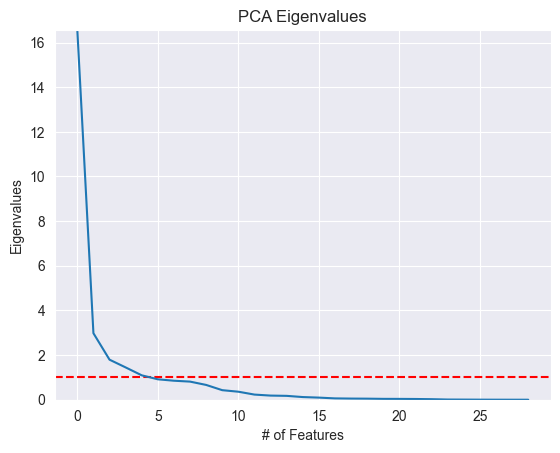

In [128]:
# PCA Eigenvalues
variance = pca.explained_variance_

# setting up table for Eigen Values
labels = ['PC' + str(x) for x in range(1, len(pca.explained_variance_)+1)]
d = {'Label': labels, 'Eigenvalues': variance}
eigenvalues = pd.DataFrame(d)
print(eigenvalues)

# setting up plot for Eigen Values
plt.ylabel('Eigenvalues')
plt.xlabel('# of Features')
plt.title('PCA Eigenvalues')
plt.ylim(0,max(pca.explained_variance_))
plt.axhline(y=1, color='r', linestyle='--')
plt.plot(pca.explained_variance_)

Here I have four components that have eigenvalues greater than 1 and according to Kaiser rule, drop components which eigenvalues are less than 1 (when data is standardized), I am keeping four components while dropping the rest.

   label  cummulative_variance
0    PC1                  57.1
1    PC2                  67.4
2    PC3                  73.6
3    PC4                  78.6
4    PC5                  82.4
5    PC6                  85.6
6    PC7                  88.5
7    PC8                  91.3
8    PC9                  93.6
9   PC10                  95.1
10  PC11                  96.3
11  PC12                  97.1
12  PC13                  97.7
13  PC14                  98.3
14  PC15                  98.7
15  PC16                  99.0
16  PC17                  99.2
17  PC18                  99.4
18  PC19                  99.6
19  PC20                  99.7
20  PC21                  99.8
21  PC22                  99.9
22  PC23                 100.0
23  PC24                 100.0
24  PC25                 100.0
25  PC26                 100.0
26  PC27                 100.0
27  PC28                 100.0
28  PC29                 100.0


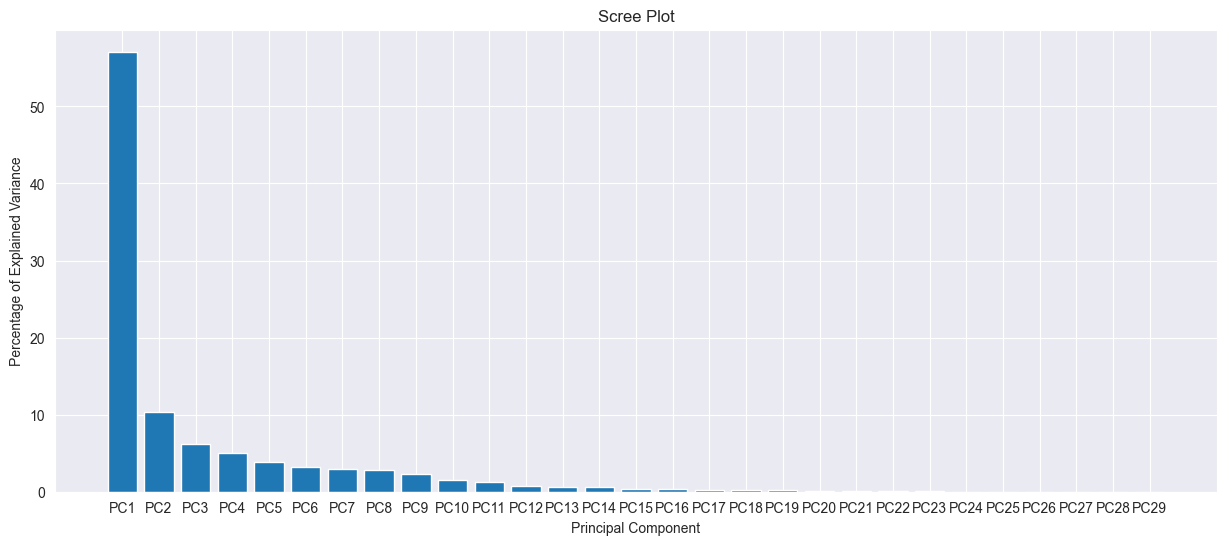

In [129]:
# Setting up Scree Plot
plt.figure(figsize=(15,6))

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
#print(per_var)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

# setting up table for  cummulative variance
cumm_per_ver = per_var.cumsum()
d = {'label':labels, 'cummulative_variance': cumm_per_ver}
explained_var = pd.DataFrame(d)
print(explained_var)

# Setting up bar plot for the variance
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

My scree plot also says that 85% of the variance is explained in the first six components.

In [130]:
# Setting up my PCA dataframe based on how many components I want to use.
n=29
pca = PCA(n_components=n)
x_pca = pca.fit_transform(scaled_data)
cols = []

for i in range(1,n+1):
    pccol = f'principal component {i}'
    cols.append(pccol)


pcadf = pd.DataFrame(data = x_pca
             , columns = cols)
pcadf

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 20,principal component 21,principal component 22,principal component 23,principal component 24,principal component 25,principal component 26,principal component 27,principal component 28,principal component 29
0,-0.986540,0.910249,0.568478,-0.439560,-0.013628,-0.106454,-0.119369,0.108421,0.483367,-0.384442,...,0.168000,-0.063086,-0.018705,-0.047274,0.105900,-0.021214,0.022705,-0.003755,-1.453349e-14,-1.760468e-14
1,-2.866482,-0.760065,0.079439,-0.066778,0.036022,-0.299207,0.297047,0.141891,0.012714,-0.001771,...,0.008714,0.020404,-0.172626,0.031059,-0.012313,-0.008700,-0.013660,0.004336,-4.430464e-15,7.514115e-15
2,-1.055704,1.488248,1.096788,-0.339485,-0.015818,-0.074094,-0.370465,-0.049242,0.645037,-0.166096,...,0.164486,-0.075330,-0.044384,0.054144,-0.012081,-0.011057,0.025238,-0.006151,-9.579124e-15,-7.446141e-15
3,1.760736,1.578683,-0.471765,1.181808,0.010037,0.144876,-0.041997,0.021877,0.631731,-0.259080,...,-0.674540,0.045171,-0.034080,-0.048189,0.041456,-0.051950,0.036905,0.007174,-6.303966e-15,9.956605e-15
4,-1.563643,0.944173,0.799426,-0.585992,0.069640,-0.162728,-0.166571,-0.153480,0.179887,0.215239,...,-0.034745,0.007770,-0.088364,0.033056,-0.006097,-0.039833,0.045797,-0.014832,-2.145851e-14,-8.473097e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5739,-2.563932,-0.178232,0.398538,-0.159212,0.034995,-0.216964,0.086264,-0.010208,0.078535,-0.025239,...,-0.017522,-0.009354,-0.003394,0.008363,-0.012801,0.015405,0.002484,-0.000631,4.826020e-15,-1.145625e-15
5740,2.523561,0.868393,-0.250383,1.414981,-1.034690,1.063514,0.281627,1.257354,0.178516,1.518401,...,-0.366491,0.170364,-0.093607,-0.195027,0.018484,-0.068907,-0.056391,-0.040970,-2.387708e-14,-4.273984e-15
5741,-1.196899,1.138330,0.872302,-0.663422,-0.075045,-0.001352,-0.181251,-0.141327,0.103077,0.007834,...,-0.031033,0.027488,0.047277,0.063239,0.051474,-0.019111,0.041089,-0.017021,-2.249934e-14,-1.838184e-14
5742,-2.518322,0.053020,0.549649,-0.175158,0.039238,-0.146746,-0.111564,-0.154823,0.160478,-0.014584,...,-0.005362,0.005063,-0.029335,0.052414,-0.023175,-0.001549,-0.008173,-0.000429,-2.223896e-15,4.044668e-15


In [131]:
# Setting up Score table to see how different component numbers score
nums = []

for i in range(1,n+1):
    num = i
    nums.append(num)

pca_score_table = pd.DataFrame(nums, columns=['Components'])
pca_score_table['TP'] = ''
pca_score_table['FN'] = ''
pca_score_table['FP'] = ''
pca_score_table['Accuracy'] = ''
pca_score_table['Precision'] = ''
pca_score_table['AUC'] = ''
pca_score_table

,Components,TP,FN,FP,Accuracy,Precision,AUC
0,1,,,,,,
1,2,,,,,,
2,3,,,,,,
3,4,,,,,,
4,5,,,,,,
5,6,,,,,,
6,7,,,,,,
7,8,,,,,,
8,9,,,,,,
9,10,,,,,,


In [132]:
# For loops with the first for loop setting the number of components to be used in the iterations from 1 to 28, second one is perfoming loops with the differenet number of folds.

# setting up my predicted value
y = Batting_Career['inducted'] # indicator

# choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

for i in range(1,n+1):

    # Setting up columns I want to use to make predictions
    X = pcadf.iloc[:,0:i]

    fold = 0
    aucs = []
    prec = []
    accu = []
    tp = 0
    fn = 0
    fp = 0
    y_actu = []
    y_pred = []
    y_prob = []

    val_pop = pd.DataFrame()

    for train_idx, val_idx in skf.split(X, y):
        X_tr = X.loc[train_idx]
        y_tr = y.loc[train_idx]
        
        X_val = X.loc[val_idx]
        y_val = y.loc[val_idx]

        # Fit Model on Train
        modelLogReg = LogisticRegression(solver='liblinear',max_iter=1000, random_state=142)
        modelLogReg.fit(X_tr, y_tr)
        pred = modelLogReg.predict(X_val)
        pred_prob = modelLogReg.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
        acc_score = accuracy_score(y_val, pred)
        auc_score = roc_auc_score(y_val, pred_prob)
        pre_score = precision_score(y_val, pred)
        
    #     print(f"======= Fold {fold} ========")
        cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
    #     print(cfm)
    #     print(
    #         f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
    #     )
        fold += 1
        val_pop = pd.concat([val_pop, X_val])
        y_val = y_val.tolist()
        y_actu.extend(y_val)
        pred = pred.tolist()
        y_pred.extend(pred)
        pred_prob = pred_prob.tolist()
        y_prob.extend(pred_prob)
        aucs.append(auc_score)
        prec.append(pre_score)
        accu.append(acc_score)
        tp = tp + int(cfm[0,0])
        fn = fn + int(cfm[0,1])
        fp = fp + int(cfm[1,0])
        oof_auc = np.mean(aucs)
        prec_mean = np.mean(prec)
        accu_mean = np.mean(acc_score)
    pca_score_table.iloc[i-1,1] = tp
    pca_score_table.iloc[i-1,2] = fn
    pca_score_table.iloc[i-1,3] = fp
    pca_score_table.iloc[i-1,4] = accu_mean
    pca_score_table.iloc[i-1,5] = prec_mean
    pca_score_table.iloc[i-1,6] = oof_auc
    # val_pop['y_val'] = y_actu
    # val_pop['y_pred'] = y_pred
    # val_pop['y_prob'] = y_prob
    # print(f'Total TP: {tp}, Total FN: {fn}, and Total FP: {fp}')
    # print(f'Our average accuracy is {accu_mean:0.4f}, average precision is {prec_mean:0.4f}, and out of fold AUC score is {oof_auc:0.4f}')
pca_score_table['apc'] = pca_score_table['Accuracy'] + pca_score_table['Precision'] + pca_score_table['AUC']
pca_score_table

,Components,TP,FN,FP,Accuracy,Precision,AUC,apc
0,1,23,37,9,0.990418,0.791026,0.995587,2.77703
1,2,24,36,10,0.990418,0.8,0.995792,2.78621
2,3,26,34,10,0.991289,0.779167,0.995689,2.766145
3,4,28,32,12,0.99216,0.739076,0.996027,2.727262
4,5,26,34,13,0.990418,0.725882,0.996158,2.712459
5,6,26,34,13,0.990418,0.725882,0.996173,2.712474
6,7,26,34,13,0.990418,0.725882,0.996115,2.712415
7,8,26,34,13,0.990418,0.725882,0.996158,2.712459
8,9,26,34,12,0.991289,0.735357,0.996789,2.723435
9,10,28,32,12,0.991289,0.759206,0.996496,2.746991


In [177]:
# Setting up columns I want to use to make predictions
X = pcadf.iloc[:,0:6]

# setting up my predicted value
y = Batting_Career['inducted'] # indicator

In [178]:
# choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

fold = 0
aucs = []
prec = []
accu = []
tp = 0
fn = 0
fp = 0
y_actu = []
y_pred = []
y_prob = []

val_pop = pd.DataFrame()

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    modelLogReg = LogisticRegression(solver='liblinear',max_iter=1000)
    modelLogReg.fit(X_tr, y_tr)
    pred = modelLogReg.predict(X_val)
    pred_prob = modelLogReg.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    pre_score = precision_score(y_val, pred)

    print(f"======= Fold {fold} ========")
    cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
    print(cfm)
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
    )
    fold += 1
    val_pop = pd.concat([val_pop, X_val])
    y_val = y_val.tolist()
    y_actu.extend(y_val)
    pred = pred.tolist()
    y_pred.extend(pred)
    pred_prob = pred_prob.tolist()
    y_prob.extend(pred_prob)
    aucs.append(auc_score)
    prec.append(pre_score)
    accu.append(acc_score)
    tp = tp + int(cfm[0,0])
    fn = fn + int(cfm[0,1])
    fp = fp + int(cfm[1,0])
    tn = fp + int(cfm[1,1])
oof_auc = np.mean(aucs)
prec_mean = np.mean(prec)
accu_mean = np.mean(acc_score)
val_pop['y_val'] = y_actu
val_pop['y_pred'] = y_pred
val_pop['y_prob'] = y_prob
tpr = tp/(tp+fn)
fpr = fp/(tn+fp)
print(f'Total TP: {tp}, Total FN: {fn}, and Total FP: {fp}')
print(f'Our average accuracy is {accu_mean:0.4f}, average precision is {prec_mean:0.4f}, and out of fold AUC score is {oof_auc:0.4f}')
print(f'TPR is {tpr:0.4f} and FPR is {fpr:0.4f}')
model_score_table.iloc[1,0] = 'PCA Logistic Regression'
model_score_table.iloc[1,1] = oof_auc
model_score_table.iloc[1,2] = accu_mean
model_score_table.iloc[1,3] = prec_mean
model_score_table.iloc[1,4] = tpr
model_score_table.iloc[1,5] = fpr
model_score_table.iloc[1,6] = tp
model_score_table.iloc[1,7] = fn
model_score_table.iloc[1,8] = fp
model_score_table.iloc[1,9] = tn

======= Fold 0 ========
[[   4    8]
 [   2 1135]]
Our accuracy on the validation set is 0.9913, precision is 0.6667, and AUC is 0.9941
======= Fold 1 ========
[[   5    7]
 [   1 1136]]
Our accuracy on the validation set is 0.9930, precision is 0.8333, and AUC is 0.9981
======= Fold 2 ========
[[   4    8]
 [   1 1136]]
Our accuracy on the validation set is 0.9922, precision is 0.8000, and AUC is 0.9971
======= Fold 3 ========
[[   4    8]
 [   1 1136]]
Our accuracy on the validation set is 0.9922, precision is 0.8000, and AUC is 0.9971
======= Fold 4 ========
[[   9    3]
 [   8 1128]]
Our accuracy on the validation set is 0.9904, precision is 0.5294, and AUC is 0.9944
Total TP: 26, Total FN: 34, and Total FP: 13
Our average accuracy is 0.9904, average precision is 0.7259, and out of fold AUC score is 0.9962
TPR is 0.4333 and FPR is 0.0113


#### PCA Predictions

In [179]:
val_pop = val_pop.join(Batting_Career['playerID'])
cols = val_pop.columns.tolist()
new_cols = [cols[-1]] + cols[:-1]
val_pop = val_pop[new_cols]
val_pop.head(5)

,playerID,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,y_val,y_pred,y_prob
0,aaronto01,-0.986540,0.910249,0.568478,-0.439560,-0.013628,-0.106454,0,0,0.000961
1,abadan01,-2.866482,-0.760065,0.079439,-0.066778,0.036022,-0.299207,0,0,0.000863
2,abbotje01,-1.055704,1.488248,1.096788,-0.339485,-0.015818,-0.074094,0,0,0.000724
8,abregjo01,-3.725133,-2.894178,-1.148562,0.345394,-0.080789,0.035736,0,0,0.001392
9,abreubo01,13.765729,-0.129614,-4.413460,-3.241338,-0.152274,0.710819,0,0,0.294380


In [180]:
player_probs = player_probs.join(val_pop['y_prob'])
player_probs.rename(columns={'y_prob':'PCA_y_prob'}, inplace=True)

In [181]:
# False positives
pcaFP = val_pop.query('y_val == 0 and y_pred ==1')
Falsepositives = pd.concat([Falsepositives,pcaFP])
val_pop.query('y_val == 0 and y_pred ==1')

,playerID,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,y_val,y_pred,y_prob
4231,ramirma02,20.884490,-7.816034,6.792857,4.087025,-2.148053,-0.400617,0,1,0.613472
4754,sheffga01,17.788262,-5.252811,2.126474,-0.870218,-1.780106,0.185317,0,1,0.656761
4182,pujolal01,28.335969,-17.255935,16.398397,4.546187,1.407689,-4.394608,0,1,0.980969
4919,sosasa01,16.767030,-6.050292,3.405141,-2.137905,-1.635135,-0.110490,0,1,0.689623
3937,parkeda01,16.339292,-6.008104,2.531450,-1.635804,-0.819155,-1.011006,0,1,0.561234
173,arenano01,12.244251,-7.264892,7.782860,0.233993,-0.768987,-2.454074,0,1,0.612011
509,bondsba01,35.327441,-23.132775,18.360304,-3.285398,-1.765786,-6.490917,0,1,1.000000
758,cabremi01,21.143532,-10.750285,9.852748,1.288984,-3.550921,-0.643423,0,1,0.988930
1888,goldspa01,15.031771,-6.848033,6.487037,1.085360,-0.850080,-2.033392,0,1,0.635875
3654,murphda05,13.498441,-5.323070,3.489997,-2.008927,-1.505389,-0.413439,0,1,0.683177


In [182]:
# False Negatives
val_pop.query('y_val == 1 and y_pred ==0')

,playerID,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,y_val,y_pred,y_prob
851,cartega01,12.664642,-5.011475,3.571377,0.208235,-1.559078,-0.419290,1,0,0.186910
3217,martied01,12.633349,-1.984161,1.728503,0.613638,-2.672647,1.600355,1,0,0.124217
4177,puckeki01,13.475394,-6.006236,4.718425,-0.740231,0.950288,-2.899212,1,0,0.198381
4344,riceji01,13.566735,-5.030087,4.229292,-1.119722,-1.565822,-0.144653,1,0,0.288872
4468,rolensc01,13.882213,-3.381869,2.193307,1.233607,2.447918,-0.660398,1,0,0.087826
4607,sandbry01,14.647894,-5.457009,1.328757,-2.320811,1.746230,-3.335006,1,0,0.366296
4796,simmote01,10.954359,-1.981234,0.539539,-1.401916,-2.871042,1.832783,1,0,0.152228
5446,walkela01,14.887601,-3.447485,1.700442,-1.437129,-0.945573,-0.258173,1,0,0.329578
240,bagweje01,17.698535,-6.012735,5.167327,0.661427,1.568669,-1.060499,1,0,0.391847
916,cepedor01,13.431459,-3.662224,1.954837,-1.138225,-1.492985,0.407116,1,0,0.237148


In [183]:
# True Positives
val_pop.query('y_val == 1 and y_pred ==1')

,playerID,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,y_val,y_pred,y_prob
85,alomaro01,17.231931,-6.061624,0.404866,-1.998875,2.438004,-4.121460,1,1,0.561903
2232,henderi01,23.617728,-5.856370,-7.759978,-8.518848,7.074286,-6.893177,1,1,0.979135
3595,morgajo02,18.573283,-6.300088,-1.202458,-4.556428,3.162109,-4.414209,1,1,0.810934
5695,yastrca01,19.795304,-6.738011,1.861334,-2.873210,-2.307381,-0.084270,1,1,0.909864
388,beltrad01,16.738999,-5.480750,3.003452,-0.038611,-2.521217,0.863126,1,1,0.515433
1006,clemero01,17.181507,-7.012793,3.130514,-2.364331,-0.425065,-2.293365,1,1,0.724011
5180,thomafr04,17.315660,-7.871923,8.870966,0.442857,-3.333715,0.294138,1,1,0.602239
5639,winfida01,18.521930,-7.142502,2.631762,-3.523557,-1.409450,-0.898283,1,1,0.864256
5721,yountro01,15.419216,-3.387262,-1.781947,-3.514271,0.292411,-0.628979,1,1,0.501931
444,biggicr01,18.318598,-3.483337,-2.697189,-2.465400,-0.739019,0.475718,1,1,0.714032


Maybe move on to KNN explore how that works see different tuning parameters and what not.

### K-nearest neighbor (K-NN)

In [231]:
# Setting up columns I want to use to make predictions
X = Batting_Career[['H_tot', 'SB_tot', 'CS_tot', 'BA_avg', 'OBP', 'SLG', 'OPS', 'Fld_pct', 'Accolades_tot', 'OPS_post', 'Post_Years_tot', 'Post_Series_tot', 'allstar_tot']]

# setting up my predicted value
y = Batting_Career['inducted'] # indicator

In [232]:
# Setting up Score table to see how different component numbers score
nums = []
n=20

for i in range(1,n+1):
    num = i
    nums.append(num)

knn_score_table = pd.DataFrame(nums, columns=['Neighbors'])
knn_score_table['TP'] = ''
knn_score_table['FN'] = ''
knn_score_table['FP'] = ''
knn_score_table['Accuracy'] = ''
knn_score_table['Precision'] = ''
knn_score_table['roc_auc'] = ''
#knn_score_table

In [233]:
# Suppressing the UndefinedMetricWarning for this cell  
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UndefinedMetricWarning)

    # For loops with the first for loop setting the number of nearest neighbors to be used in the iterations from 1 to 10, second one is perfoming loops with the differenet number of folds.
    # setting up my predicted value
    y = Batting_Career['inducted'] # indicator

    # choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)


    for i in range(1,n+1):
        fold = 0
        aucs = []
        prec = []
        accu = []
        tp = 0
        fn = 0
        fp = 0
        y_actu = []
        y_pred = []
        y_prob = []
        val_pop = pd.DataFrame()

        for train_idx, val_idx in skf.split(X, y):
            X_tr = X.loc[train_idx]
            y_tr = y.loc[train_idx]
            
            X_val = X.loc[val_idx]
            y_val = y.loc[val_idx]

            # Fit Model on Train
            knn = KNeighborsClassifier(n_neighbors=i)
            knn.fit(X_tr, y_tr)
            pred = knn.predict(X_val)
            pred_prob = knn.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
            acc_score = accuracy_score(y_val, pred)
            auc_score = roc_auc_score(y_val, pred_prob)
            pre_score = precision_score(y_val, pred)
            #     print(f"======= Fold {fold} ========")
            cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
            # print(cfm)
            #     print(
            #         f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
            #     )
            fold += 1
            val_pop = pd.concat([val_pop, X_val])
            y_val = y_val.tolist()
            y_actu.extend(y_val)
            pred = pred.tolist()
            y_pred.extend(pred)
            pred_prob = pred_prob.tolist()
            y_prob.extend(pred_prob)
            aucs.append(auc_score)
            prec.append(pre_score)
            accu.append(acc_score)
            tp = tp + int(cfm[0,0])
            fn = fn + int(cfm[0,1])
            fp = fp + int(cfm[1,0])
            oof_auc = np.mean(aucs)
            prec_mean = np.mean(prec)
            accu_mean = np.mean(acc_score)
            knn_score_table.iloc[i-1,1] = tp
            knn_score_table.iloc[i-1,2] = fn
            knn_score_table.iloc[i-1,3] = fp
            knn_score_table.iloc[i-1,4] = accu_mean
            knn_score_table.iloc[i-1,5] = prec_mean
            knn_score_table.iloc[i-1,6] = oof_auc
        # val_pop['y_val'] = y_actu
        # val_pop['y_pred'] = y_pred
        # val_pop['y_prob'] = y_prob
        # print(f'Total TP: {tp}, Total FN: {fn}, and Total FP: {fp}')
        # print(f'Our average accuracy is {accu_mean:0.4f}, average precision is {prec_mean:0.4f}, and out of fold AUC score is {oof_auc:0.4f}')
    knn_score_table['apc'] = knn_score_table['Accuracy'] + knn_score_table['Precision'] + knn_score_table['roc_auc']
knn_score_table

,Neighbors,TP,FN,FP,Accuracy,Precision,roc_auc,apc
0,1,35,25,19,0.991289,0.650684,0.789995,2.431968
1,2,23,37,10,0.989547,0.729762,0.880467,2.599776
2,3,33,27,22,0.987805,0.618571,0.913309,2.519685
3,4,28,32,13,0.989547,0.696883,0.921429,2.60786
4,5,36,24,25,0.988676,0.600513,0.929712,2.5189
5,6,30,30,17,0.989547,0.653788,0.937942,2.581277
6,7,34,26,19,0.988676,0.645781,0.954646,2.589103
7,8,32,28,17,0.989547,0.673248,0.954858,2.617653
8,9,35,25,22,0.991289,0.623883,0.963419,2.578591
9,10,32,28,15,0.99216,0.693939,0.963668,2.649768


In [234]:
# choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

fold = 0
aucs = []
prec = []
accu = []
tp = 0
fn = 0
fp = 0
y_actu = []
y_pred = []
y_prob = []

val_pop = pd.DataFrame()

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_tr, y_tr)
    pred = knn.predict(X_val)
    pred_prob = knn.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    pre_score = precision_score(y_val, pred)

    print(f"======= Fold {fold} ========")
    cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
    print(cfm)
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
    )
    fold += 1
    val_pop = pd.concat([val_pop, X_val])
    y_val = y_val.tolist()
    y_actu.extend(y_val)
    pred = pred.tolist()
    y_pred.extend(pred)
    pred_prob = pred_prob.tolist()
    y_prob.extend(pred_prob)
    aucs.append(auc_score)
    prec.append(pre_score)
    accu.append(acc_score)
    tp = tp + int(cfm[0,0])
    fn = fn + int(cfm[0,1])
    fp = fp + int(cfm[1,0])
    tn = fp + int(cfm[1,1])
oof_auc = np.mean(aucs)
prec_mean = np.mean(prec)
accu_mean = np.mean(acc_score)
val_pop['y_val'] = y_actu
val_pop['y_pred'] = y_pred
val_pop['y_prob'] = y_prob
tpr = tp/(tp+fn)
fpr = fp/(tn+fp)
print(f'Total TP: {tp}, Total FN: {fn}, and Total FP: {fp}')
print(f'Our average accuracy is {accu_mean:0.4f}, average precision is {prec_mean:0.4f}, and out of fold AUC score is {oof_auc:0.4f}')
print(f'TPR is {tpr:0.4f} and FPR is {fpr:0.4f}')
model_score_table.iloc[2,0] = 'K-NN'
model_score_table.iloc[2,1] = oof_auc
model_score_table.iloc[2,2] = accu_mean
model_score_table.iloc[2,3] = prec_mean
model_score_table.iloc[2,4] = tpr
model_score_table.iloc[2,5] = fpr
model_score_table.iloc[2,6] = tp
model_score_table.iloc[2,7] = fn
model_score_table.iloc[2,8] = fp
model_score_table.iloc[2,9] = tn

======= Fold 0 ========
[[   6    6]
 [   6 1131]]
Our accuracy on the validation set is 0.9896, precision is 0.5000, and AUC is 0.8712
======= Fold 1 ========
[[  10    2]
 [   3 1134]]
Our accuracy on the validation set is 0.9956, precision is 0.7692, and AUC is 0.9562
======= Fold 2 ========
[[   9    3]
 [   6 1131]]
Our accuracy on the validation set is 0.9922, precision is 0.6000, and AUC is 0.9558
======= Fold 3 ========
[[   4    8]
 [   2 1135]]
Our accuracy on the validation set is 0.9913, precision is 0.6667, and AUC is 0.9137
======= Fold 4 ========
[[   7    5]
 [   8 1128]]
Our accuracy on the validation set is 0.9887, precision is 0.4667, and AUC is 0.9518
Total TP: 36, Total FN: 24, and Total FP: 25
Our average accuracy is 0.9887, average precision is 0.6005, and out of fold AUC score is 0.9297
TPR is 0.6000 and FPR is 0.0212


#### K-NN Predictions

In [235]:
val_pop = val_pop.join(Batting_Career['playerID'])
cols = val_pop.columns.tolist()
new_cols = [cols[-1]] + cols[:-1]
val_pop = val_pop[new_cols]
val_pop.head(5)


,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
0,aaronto01,216,9.0,8.0,0.228814,0.291506,0.327331,0.618836,0.984848,0.0,0.000000,1.0,1.0,0.0,0,0,0.0
1,abadan01,2,0.0,1.0,0.095238,0.240000,0.095238,0.335238,0.974359,0.0,0.000000,0.0,0.0,0.0,0,0,0.0
2,abbotje01,157,6.0,5.0,0.263423,0.307453,0.416107,0.723561,0.974110,0.0,0.000000,1.0,1.0,0.0,0,0,0.0
8,abregjo01,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.875000,0.0,0.000000,0.0,0.0,0.0,0,0,0.0
9,abreubo01,2470,400.0,128.0,0.291274,0.394977,0.474764,0.869741,0.982456,73.0,0.810316,4.0,5.0,2.0,0,0,0.0


In [236]:
player_probs = player_probs.join(val_pop['y_prob'])
player_probs.rename(columns={'y_prob':'KNN_y_prob'}, inplace=True)

In [237]:
# False positives
knnFP = val_pop.query('y_val == 0 and y_pred ==1')
Falsepositives = pd.concat([Falsepositives,knnFP])
val_pop.query('y_val == 0 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
1750,galaran01,2333,128.0,81.0,0.288167,0.347056,0.498765,0.845820,0.991109,549.0,0.547049,4.0,5.0,5.0,0,1,0.8
1807,garvest01,2599,83.0,62.0,0.294171,0.329376,0.446067,0.775442,0.993680,849.0,0.910419,5.0,11.0,10.0,0,1,0.6
2713,kentje01,2461,94.0,60.0,0.289598,0.355516,0.499647,0.855163,0.978487,711.0,0.840426,7.0,11.0,5.0,0,1,0.8
4231,ramirma02,2574,38.0,33.0,0.312227,0.410561,0.585395,0.995956,0.978006,1275.0,0.937412,11.0,23.0,12.0,0,1,1.0
4754,sheffga01,2689,253.0,104.0,0.291744,0.393033,0.513942,0.906975,0.963508,992.0,0.798506,6.0,9.0,9.0,0,1,0.6
5246,torrejo01,2342,23.0,29.0,0.297435,0.364816,0.452121,0.816937,0.987498,483.0,0.000000,0.0,0.0,9.0,0,1,0.6
2272,hernake01,2182,98.0,63.0,0.296065,0.384408,0.436092,0.820501,0.994166,721.0,0.728540,3.0,5.0,5.0,0,1,0.6
3921,palmera01,3020,97.0,40.0,0.288388,0.370709,0.514515,0.885224,0.993953,474.0,0.758912,3.0,5.0,4.0,0,1,0.8
5140,tejadmi01,2407,85.0,38.0,0.285392,0.335730,0.455537,0.791267,0.971170,561.0,0.571170,4.0,4.0,6.0,0,1,0.6
134,anderga01,2529,80.0,47.0,0.292708,0.323658,0.461111,0.784769,0.988609,326.0,0.660792,5.0,8.0,3.0,0,1,0.6


In [238]:
# False Negatives
val_pop.query('y_val == 1 and y_pred ==0')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
851,cartega01,2092,39.0,42.0,0.262451,0.334743,0.438715,0.773458,0.990768,679.0,0.786414,3.0,5.0,11.0,1,0,0.2
3217,martied01,2247,49.0,30.0,0.311521,0.417802,0.515458,0.933260,0.951555,408.0,0.872677,4.0,7.0,7.0,1,0,0.4
4177,puckeki01,2304,134.0,76.0,0.318056,0.359887,0.476670,0.836558,0.988879,1048.0,0.897194,2.0,4.0,10.0,1,0,0.4
4468,rolensc01,2077,118.0,49.0,0.280752,0.364330,0.490403,0.854733,0.967624,413.0,0.677773,5.0,9.0,7.0,1,0,0.0
4796,simmote01,2472,21.0,33.0,0.284793,0.347943,0.436982,0.784925,0.985684,236.0,0.635344,2.0,3.0,8.0,1,0,0.0
5446,walkela01,2160,230.0,76.0,0.312726,0.400224,0.565224,0.965448,0.986576,643.0,0.860000,3.0,6.0,5.0,1,0,0.0
2884,larkiba01,2340,379.0,77.0,0.294822,0.370527,0.444374,0.814901,0.974603,439.0,0.862225,2.0,4.0,12.0,1,0,0.2
3337,mccovwi01,2211,26.0,22.0,0.269733,0.374445,0.514701,0.889145,0.986568,549.0,1.101420,2.0,2.0,6.0,1,0,0.0
3829,olivato01,1917,86.0,55.0,0.304237,0.353095,0.476432,0.829528,0.975244,598.0,0.927858,3.0,3.0,8.0,1,0,0.0
4038,perezto01,2732,49.0,33.0,0.279403,0.340951,0.463489,0.804440,0.986522,312.0,0.668912,6.0,11.0,7.0,1,0,0.4


In [239]:
# True Positives
val_pop.query('y_val == 1 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
85,alomaro01,2724,474.0,114.0,0.300231,0.371245,0.442852,0.814097,0.983634,785.0,0.828595,7.0,11.0,12.0,1,1,0.8
2232,henderi01,3055,1406.0,335.0,0.278715,0.401247,0.418575,0.819822,0.979080,980.0,0.830754,8.0,14.0,10.0,1,1,1.0
3595,morgajo02,2517,689.0,162.0,0.271316,0.392091,0.427078,0.819169,0.981113,1044.0,0.670794,7.0,11.0,10.0,1,1,0.6
4344,riceji01,2452,58.0,34.0,0.298116,0.351928,0.502006,0.853934,0.980036,1215.0,0.678697,2.0,3.0,8.0,1,1,0.8
4607,sandbry01,2386,344.0,107.0,0.284556,0.343855,0.451640,0.795495,0.988743,698.0,1.097547,2.0,2.0,10.0,1,1,0.8
5695,yastrca01,3419,168.0,116.0,0.285202,0.379453,0.462045,0.841499,0.988103,702.0,1.047368,2.0,3.0,18.0,1,1,1.0
240,bagweje01,2314,202.0,78.0,0.296781,0.407616,0.540336,0.947952,0.993344,1325.0,0.685096,6.0,9.0,4.0,1,1,0.8
388,beltrad01,3166,121.0,42.0,0.286050,0.339303,0.479671,0.818975,0.959600,967.0,0.747061,5.0,7.0,4.0,1,1,1.0
916,cepedor01,2351,142.0,80.0,0.296581,0.349902,0.499432,0.849335,0.988962,546.0,0.609574,4.0,4.0,13.0,1,1,0.6
1006,clemero01,3000,83.0,46.0,0.317326,0.359277,0.475143,0.834420,0.972200,839.0,0.802580,4.0,5.0,17.0,1,1,1.0


### Support Vector Machines

Using Support Vector Machine Classification. Going to try linear, polynomial, and rbf kernels, tune and see how they perform.

#### Linear SVC Tuning

In [149]:
# Setting up SVC to perform GridSearchCV.
# param# Setting up SVC to perform GridSearchCV.
# param_grid and grid_search
# using accuracy
# param_grid = {'C': [0.1, 1, 10, 100]}
# grid_search = GridSearchCV(SVC(kernel='linear', random_state=142), param_grid, cv=5, verbose=4, scoring='accuracy')

# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# print(f'Best Parameters: {best_params}')

In [150]:
# Setting up SVC to perform GridSearchCV.
# param_grid and grid_search
# using precision
param_grid = {'C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(kernel='linear', random_state=142), param_grid, cv=5, verbose=4, scoring='precision')

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............................C=0.1;, score=0.733 total time=   5.6s
[CV 2/5] END .............................C=0.1;, score=1.000 total time=   7.0s
[CV 3/5] END .............................C=0.1;, score=1.000 total time=   5.5s
[CV 4/5] END .............................C=0.1;, score=0.600 total time=   2.3s
[CV 5/5] END .............................C=0.1;, score=0.667 total time=   4.5s
[CV 1/5] END ...............................C=1;, score=0.733 total time=  26.1s
[CV 2/5] END ...............................C=1;, score=0.900 total time=  27.7s
[CV 3/5] END ...............................C=1;, score=1.000 total time=  29.3s
[CV 4/5] END ...............................C=1;, score=0.538 total time=   9.6s
[CV 5/5] END ...............................C=1;, score=0.600 total time=  18.9s
[CV 1/5] END ..............................C=10;, score=0.692 total time=  43.9s
[CV 2/5] END ..............................C=10;,

In [151]:
# Setting up SVC to perform GridSearchCV.
# param_grid and grid_search
# using roc_auc
param_grid = {'C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(kernel='linear', random_state=142), param_grid, cv=5, verbose=4, scoring='roc_auc')

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............................C=0.1;, score=0.996 total time=   6.3s
[CV 2/5] END .............................C=0.1;, score=0.999 total time=   7.9s
[CV 3/5] END .............................C=0.1;, score=0.998 total time=   7.4s
[CV 4/5] END .............................C=0.1;, score=0.996 total time=   2.7s
[CV 5/5] END .............................C=0.1;, score=0.995 total time=   5.7s
[CV 1/5] END ...............................C=1;, score=0.996 total time=  30.9s
[CV 2/5] END ...............................C=1;, score=0.999 total time=  20.0s
[CV 3/5] END ...............................C=1;, score=0.998 total time=  24.5s
[CV 4/5] END ...............................C=1;, score=0.995 total time=   9.5s
[CV 5/5] END ...............................C=1;, score=0.995 total time=  20.9s
[CV 1/5] END ..............................C=10;, score=0.995 total time=  29.2s
[CV 2/5] END ..............................C=10;,

I ran GridSearchCV on three different scoring metrics on my Linear SVC that I have been using to evaluate my models so far. While Accuracy and Precision both reach the same conclusion of the best parameter being C = 1. But When I run GridSearchCV with the roc_auc scoring metric the conclusion it reaches is C = 0.1. Taking into consideration the massive class imbalance present in my data population, I will be choosing roc_auc for my scoring metric for my Linear SVC model as it considers both the true positive rate and false positive rate.

#### Polynomial SVC Tuning

In [152]:
# Setting up SVC to perform GridSearchCV.
# Setting up SVC to perform GridSearchCV.
# param_grid and grid_search
# using accuracy
# param_grid = {'C': [0.1, 1, 10, 100],
#               'degree': [1, 2, 3]}
# grid_search = GridSearchCV(SVC(kernel='poly', random_state=142), param_grid, cv=5, verbose=4, scoring='accuracy')

# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# print(f'Best Parameters: {best_params}')

In [153]:
# Setting up SVC to perform GridSearchCV.
# param_grid and grid_search
# using precision
param_grid = {'C': [0.1, 1, 10, 100],
              'degree': [1, 2, 3]}
grid_search = GridSearchCV(SVC(kernel='poly', random_state=142), param_grid, cv=5, verbose=4, scoring='precision')

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...................C=0.1, degree=1;, score=0.778 total time=   0.0s
[CV 2/5] END ...................C=0.1, degree=1;, score=1.000 total time=   0.0s
[CV 3/5] END ...................C=0.1, degree=1;, score=1.000 total time=   0.0s
[CV 4/5] END ...................C=0.1, degree=1;, score=0.333 total time=   0.0s
[CV 5/5] END ...................C=0.1, degree=1;, score=1.000 total time=   0.0s
[CV 1/5] END ...................C=0.1, degree=2;, score=0.778 total time=   0.0s
[CV 2/5] END ...................C=0.1, degree=2;, score=1.000 total time=   0.0s
[CV 3/5] END ...................C=0.1, degree=2;, score=1.000 total time=   0.0s
[CV 4/5] END ...................C=0.1, degree=2;, score=0.417 total time=   0.0s
[CV 5/5] END ...................C=0.1, degree=2;, score=0.800 total time=   0.0s
[CV 1/5] END ...................C=0.1, degree=3;, score=0.727 total time=   0.0s
[CV 2/5] END ...................C=0.1, degree=3;

In [154]:
# Setting up SVC to perform GridSearchCV.
# param_grid and grid_search
# using roc_auc
param_grid = {'C': [0.1, 1, 10, 100, 200, 300, 500, 600],
              'degree': [1, 2, 3]}
grid_search = GridSearchCV(SVC(kernel='poly', random_state=142), param_grid, cv=5, verbose=4, scoring='roc_auc')

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END ...................C=0.1, degree=1;, score=0.997 total time=   0.0s
[CV 2/5] END ...................C=0.1, degree=1;, score=0.999 total time=   0.0s
[CV 3/5] END ...................C=0.1, degree=1;, score=0.996 total time=   0.0s
[CV 4/5] END ...................C=0.1, degree=1;, score=0.993 total time=   0.0s
[CV 5/5] END ...................C=0.1, degree=1;, score=0.997 total time=   0.0s
[CV 1/5] END ...................C=0.1, degree=2;, score=0.998 total time=   0.0s
[CV 2/5] END ...................C=0.1, degree=2;, score=1.000 total time=   0.0s
[CV 3/5] END ...................C=0.1, degree=2;, score=0.995 total time=   0.0s
[CV 4/5] END ...................C=0.1, degree=2;, score=0.994 total time=   0.0s
[CV 5/5] END ...................C=0.1, degree=2;, score=0.997 total time=   0.0s
[CV 1/5] END ...................C=0.1, degree=3;, score=0.997 total time=   0.0s
[CV 2/5] END ...................C=0.1, degree=3

Ran GridSearchCV on three different scoring metrics for the Polynomial Kernel SVC evaluating the C (Regularization Parameter) and degree of the polynomial. Interestingly using the roc_auc scoring metric GridSearch settles on a linear model with a different C of 200, this must be due to sensitivity in the different hyperparameters. The parameters recommended by the roc_auc will be used. 

#### Radial SVC Tuning

In [155]:
# Setting up SVC to perform GridSearchCV.
# Setting up SVC to perform GridSearchCV.
# param_grid and grid_search
# using accuracy
# param_grid = {'C': [0.1, 1, 10, 100],
#               'gamma': [10, 5, 1, 0.1, 0.001]}
# grid_search = GridSearchCV(SVC(kernel='rbf', random_state=142), param_grid, cv=5, verbose=4, scoring='accuracy')

# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# print(f'Best Parameters: {best_params}')

In [156]:
# Setting up SVC to perform GridSearchCV.
# param_grid and grid_search
# using precision

import warnings  
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.simplefilter("ignore", UndefinedMetricWarning)

    param_grid = {'C': [0.1, 1, 10, 100],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
    grid_search = GridSearchCV(SVC(kernel='rbf', random_state=142), param_grid, cv=5, verbose=4, scoring='precision')

    grid_search.fit(X, y)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print(f'Best Parameters: {best_params}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.000 total time=   1.3s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.000 total time=   1.4s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.000 total time=   1.3s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.000 total time=   1.4s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.000 total time=   1.6s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.000 total time=   1.2s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.000 total time=   1.1s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.000 total time=   1.2s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.000 total time=   1.0s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.000 total time=   1.1s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.000 total time=   0.7s
[CV 2/5] END .................C=0.1, gamma=0.01

In [157]:
# Setting up SVC to perform GridSearchCV.
# param_grid and grid_search
# using roc_auc
import warnings  
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.simplefilter("ignore", UndefinedMetricWarning)

    param_grid = {'C': [0.1, 1, 10, 100],
                'gamma': [100, 50, 25, 10]}
    grid_search = GridSearchCV(SVC(kernel='rbf', random_state=142), param_grid, cv=5, verbose=4, scoring='roc_auc')

    grid_search.fit(X, y)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print(f'Best Parameters: {best_params}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ..................C=0.1, gamma=100;, score=0.677 total time=   1.8s
[CV 2/5] END ..................C=0.1, gamma=100;, score=0.682 total time=   1.5s
[CV 3/5] END ..................C=0.1, gamma=100;, score=0.696 total time=   1.5s
[CV 4/5] END ..................C=0.1, gamma=100;, score=0.695 total time=   1.5s
[CV 5/5] END ..................C=0.1, gamma=100;, score=0.686 total time=   1.5s
[CV 1/5] END ...................C=0.1, gamma=50;, score=0.678 total time=   1.5s
[CV 2/5] END ...................C=0.1, gamma=50;, score=0.682 total time=   1.4s
[CV 3/5] END ...................C=0.1, gamma=50;, score=0.696 total time=   1.4s
[CV 4/5] END ...................C=0.1, gamma=50;, score=0.695 total time=   1.4s
[CV 5/5] END ...................C=0.1, gamma=50;, score=0.686 total time=   1.5s
[CV 1/5] END ...................C=0.1, gamma=25;, score=0.712 total time=   1.4s
[CV 2/5] END ...................C=0.1, gamma=25;

Ran GridSearchCV on three different scoring metrics for the Radial Kernel evaluating the C (Regularization Parameter) and Gamma. The parameters recommended by the roc_auc will be used which are C = 0.1 and Gamma = 0.001.

#### Linear SVC Predictions

In [158]:
# choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

fold = 0
aucs = []
prec = []
accu = []
tp = 0
fn = 0
fp = 0
y_actu = []
y_pred = []
y_prob = []

val_pop = pd.DataFrame()

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    linesvc = SVC(kernel='linear', random_state=142, C=0.1, probability=True)
    linesvc.fit(X_tr, y_tr)
    pred = linesvc.predict(X_val)
    pred_prob = linesvc.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    pre_score = precision_score(y_val, pred)

    print(f"======= Fold {fold} ========")
    cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
    print(cfm)
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
    )
    fold += 1
    val_pop = pd.concat([val_pop, X_val])
    y_val = y_val.tolist()
    y_actu.extend(y_val)
    pred = pred.tolist()
    y_pred.extend(pred)
    pred_prob = pred_prob.tolist()
    y_prob.extend(pred_prob)
    aucs.append(auc_score)
    prec.append(pre_score)
    accu.append(acc_score)
    tp = tp + int(cfm[0,0])
    fn = fn + int(cfm[0,1])
    fp = fp + int(cfm[1,0])
    tn = fp + int(cfm[1,1])
oof_auc = np.mean(aucs)
prec_mean = np.mean(prec)
accu_mean = np.mean(acc_score)
val_pop['y_val'] = y_actu
val_pop['y_pred'] = y_pred
val_pop['y_prob'] = y_prob
tpr = tp/(tp+fn)
fpr = fp/(tn+fp)
print(f'Total TP: {tp}, Total FN: {fn}, and Total FP: {fp}')
print(f'Our average accuracy is {accu_mean:0.4f}, average precision is {prec_mean:0.4f}, and out of fold AUC score is {oof_auc:0.4f}')
print(f'TPR is {tpr:0.4f} and FPR is {fpr:0.4f}')

======= Fold 0 ========
[[   6    6]
 [   1 1136]]
Our accuracy on the validation set is 0.9939, precision is 0.8571, and AUC is 0.9958
======= Fold 1 ========
[[   4    8]
 [   1 1136]]
Our accuracy on the validation set is 0.9922, precision is 0.8000, and AUC is 0.9962
======= Fold 2 ========
[[   7    5]
 [   1 1136]]
Our accuracy on the validation set is 0.9948, precision is 0.8750, and AUC is 0.9983
======= Fold 3 ========
[[   7    5]
 [   0 1137]]
Our accuracy on the validation set is 0.9956, precision is 1.0000, and AUC is 0.9998
======= Fold 4 ========
[[   9    3]
 [   9 1127]]
Our accuracy on the validation set is 0.9895, precision is 0.5000, and AUC is 0.9948
Total TP: 33, Total FN: 27, and Total FP: 12
Our average accuracy is 0.9895, average precision is 0.8064, and out of fold AUC score is 0.9970
TPR is 0.5500 and FPR is 0.0104


In [159]:
val_pop = val_pop.join(Batting_Career['playerID'])
cols = val_pop.columns.tolist()
new_cols = [cols[-1]] + cols[:-1]
val_pop = val_pop[new_cols]
val_pop.head(5)


,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
0,aaronto01,216,9.0,8.0,0.228814,0.291506,0.327331,0.618836,0.984848,0.0,0.000000,1.0,1.0,0.0,0,0,0.000302
1,abadan01,2,0.0,1.0,0.095238,0.240000,0.095238,0.335238,0.974359,0.0,0.000000,0.0,0.0,0.0,0,0,0.000179
2,abbotje01,157,6.0,5.0,0.263423,0.307453,0.416107,0.723561,0.974110,0.0,0.000000,1.0,1.0,0.0,0,0,0.000276
8,abregjo01,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.875000,0.0,0.000000,0.0,0.0,0.0,0,0,0.000173
9,abreubo01,2470,400.0,128.0,0.291274,0.394977,0.474764,0.869741,0.982456,73.0,0.810316,4.0,5.0,2.0,0,0,0.111583


In [160]:
# False positives
val_pop.query('y_val == 0 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
5246,torrejo01,2342,23.0,29.0,0.297435,0.364816,0.452121,0.816937,0.987498,483.0,0.000000,0.0,0.0,9.0,0,1,0.383473
4182,pujolal01,3384,117.0,43.0,0.296296,0.374233,0.543823,0.918056,0.992503,3285.0,0.994591,10.0,20.0,12.0,0,1,0.525292
3830,oliveal01,2743,84.0,64.0,0.303127,0.344227,0.451210,0.795437,0.986452,440.0,0.699204,6.0,7.0,7.0,0,1,0.461743
389,beltrca01,2725,312.0,49.0,0.278972,0.350495,0.486384,0.836879,0.986049,481.0,1.021067,7.0,15.0,9.0,0,1,0.702338
509,bondsba01,2935,514.0,141.0,0.298060,0.444295,0.606885,1.051180,0.983579,3801.0,0.936004,7.0,9.0,14.0,0,1,0.992177
561,boyerke01,2143,105.0,77.0,0.287458,0.348564,0.461838,0.810402,0.957100,479.0,0.722861,1.0,1.0,13.0,0,1,0.585835
758,cabremi01,3174,40.0,21.0,0.306489,0.382156,0.518347,0.900503,0.987746,1938.0,0.884595,5.0,11.0,13.0,0,1,0.982434
3282,mattido01,2153,14.0,9.0,0.307440,0.358329,0.471369,0.829698,0.995601,890.0,1.148333,1.0,1.0,6.0,0,1,0.481585
4425,rodrial01,3115,329.0,76.0,0.294814,0.379706,0.550161,0.929867,0.972979,2091.0,0.821576,12.0,19.0,14.0,0,1,0.972986
4508,rosepe01,4256,198.0,149.0,0.302853,0.375134,0.409308,0.784442,0.986651,1211.0,0.828258,8.0,14.0,17.0,0,1,0.996102


In [161]:
player_probs = player_probs.join(val_pop['y_prob'])
player_probs.rename(columns={'y_prob':'LINE_SVM_y_prob'}, inplace=True)

In [162]:
# False Negatives
val_pop.query('y_val == 1 and y_pred ==0')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
851,cartega01,2092,39.0,42.0,0.262451,0.334743,0.438715,0.773458,0.990768,679.0,0.786414,3.0,5.0,11.0,1,0,0.292925
3217,martied01,2247,49.0,30.0,0.311521,0.417802,0.515458,0.933260,0.951555,408.0,0.872677,4.0,7.0,7.0,1,0,0.200533
4177,puckeki01,2304,134.0,76.0,0.318056,0.359887,0.476670,0.836558,0.988879,1048.0,0.897194,2.0,4.0,10.0,1,0,0.241533
4344,riceji01,2452,58.0,34.0,0.298116,0.351928,0.502006,0.853934,0.980036,1215.0,0.678697,2.0,3.0,8.0,1,0,0.263244
4468,rolensc01,2077,118.0,49.0,0.280752,0.364330,0.490403,0.854733,0.967624,413.0,0.677773,5.0,9.0,7.0,1,0,0.115562
5446,walkela01,2160,230.0,76.0,0.312726,0.400224,0.565224,0.965448,0.986576,643.0,0.860000,3.0,6.0,5.0,1,0,0.077281
240,bagweje01,2314,202.0,78.0,0.296781,0.407616,0.540336,0.947952,0.993344,1325.0,0.685096,6.0,9.0,4.0,1,0,0.045243
388,beltrad01,3166,121.0,42.0,0.286050,0.339303,0.479671,0.818975,0.959600,967.0,0.747061,5.0,7.0,4.0,1,0,0.370449
3337,mccovwi01,2211,26.0,22.0,0.269733,0.374445,0.514701,0.889145,0.986568,549.0,1.101420,2.0,2.0,6.0,1,0,0.181280
4089,piazzmi01,2127,17.0,20.0,0.307770,0.376501,0.545218,0.921719,0.989222,1457.0,0.759085,5.0,8.0,12.0,1,0,0.308974


In [163]:
# True Positives
val_pop.query('y_val == 1 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
85,alomaro01,2724,474.0,114.0,0.300231,0.371245,0.442852,0.814097,0.983634,785.0,0.828595,7.0,11.0,12.0,1,1,0.803890
2232,henderi01,3055,1406.0,335.0,0.278715,0.401247,0.418575,0.819822,0.979080,980.0,0.830754,8.0,14.0,10.0,1,1,0.796482
3595,morgajo02,2517,689.0,162.0,0.271316,0.392091,0.427078,0.819169,0.981113,1044.0,0.670794,7.0,11.0,10.0,1,1,0.522115
4607,sandbry01,2386,344.0,107.0,0.284556,0.343855,0.451640,0.795495,0.988743,698.0,1.097547,2.0,2.0,10.0,1,1,0.517810
4796,simmote01,2472,21.0,33.0,0.284793,0.347943,0.436982,0.784925,0.985684,236.0,0.635344,2.0,3.0,8.0,1,1,0.417352
5695,yastrca01,3419,168.0,116.0,0.285202,0.379453,0.462045,0.841499,0.988103,702.0,1.047368,2.0,3.0,18.0,1,1,0.984976
916,cepedor01,2351,142.0,80.0,0.296581,0.349902,0.499432,0.849335,0.988962,546.0,0.609574,4.0,4.0,13.0,1,1,0.668525
1006,clemero01,3000,83.0,46.0,0.317326,0.359277,0.475143,0.834420,0.972200,839.0,0.802580,4.0,5.0,17.0,1,1,0.972533
2884,larkiba01,2340,379.0,77.0,0.294822,0.370527,0.444374,0.814901,0.974603,439.0,0.862225,2.0,4.0,12.0,1,1,0.798227
5639,winfida01,3110,223.0,96.0,0.282650,0.352622,0.474507,0.827129,0.981991,857.0,0.640981,2.0,5.0,12.0,1,1,0.852435


Pretty solid numbers by the linear SVC numbers

#### Polynomial Predictions

In [164]:
# choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

fold = 0
aucs = []
prec = []
accu = []
tp = 0
fn = 0
fp = 0
y_actu = []
y_pred = []
y_prob = []

val_pop = pd.DataFrame()

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    polysvc = SVC(kernel='poly', random_state=142, degree=1 , C=0.1, probability=True)
    polysvc.fit(X_tr, y_tr)
    pred = polysvc.predict(X_val)
    pred_prob = polysvc.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    pre_score = precision_score(y_val, pred)

    print(f"======= Fold {fold} ========")
    cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
    print(cfm)
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
    )
    fold += 1
    val_pop = pd.concat([val_pop, X_val])
    y_val = y_val.tolist()
    y_actu.extend(y_val)
    pred = pred.tolist()
    y_pred.extend(pred)
    pred_prob = pred_prob.tolist()
    y_prob.extend(pred_prob)
    aucs.append(auc_score)
    prec.append(pre_score)
    accu.append(acc_score)
    tp = tp + int(cfm[0,0])
    fn = fn + int(cfm[0,1])
    fp = fp + int(cfm[1,0])
    tn = fp + int(cfm[1,1])
oof_auc = np.mean(aucs)
prec_mean = np.mean(prec)
accu_mean = np.mean(acc_score)
val_pop['y_val'] = y_actu
val_pop['y_pred'] = y_pred
val_pop['y_prob'] = y_prob
tpr = tp/(tp+fn)
fpr = fp/(tn+fp)
print(f'Total TP: {tp}, Total FN: {fn}, and Total FP: {fp}')
print(f'Our average accuracy is {accu_mean:0.4f}, average precision is {prec_mean:0.4f}, and out of fold AUC score is {oof_auc:0.4f}')
print(f'TPR is {tpr:0.4f} and FPR is {fpr:0.4f}')
model_score_table.iloc[3,0] = 'Poly SVM'
model_score_table.iloc[3,1] = oof_auc
model_score_table.iloc[3,2] = accu_mean
model_score_table.iloc[3,3] = prec_mean
model_score_table.iloc[3,4] = tpr
model_score_table.iloc[3,5] = fpr
model_score_table.iloc[3,6] = tp
model_score_table.iloc[3,7] = fn
model_score_table.iloc[3,8] = fp
model_score_table.iloc[3,9] = tn

======= Fold 0 ========
[[   2   10]
 [   1 1136]]
Our accuracy on the validation set is 0.9904, precision is 0.6667, and AUC is 0.9937
======= Fold 1 ========
[[   5    7]
 [   1 1136]]
Our accuracy on the validation set is 0.9930, precision is 0.8333, and AUC is 0.9970
======= Fold 2 ========
[[   4    8]
 [   0 1137]]
Our accuracy on the validation set is 0.9930, precision is 1.0000, and AUC is 0.9973
======= Fold 3 ========
[[   4    8]
 [   0 1137]]
Our accuracy on the validation set is 0.9930, precision is 1.0000, and AUC is 0.9970
======= Fold 4 ========
[[   8    4]
 [   5 1131]]
Our accuracy on the validation set is 0.9922, precision is 0.6154, and AUC is 0.9947
Total TP: 23, Total FN: 37, and Total FP: 7
Our average accuracy is 0.9922, average precision is 0.8231, and out of fold AUC score is 0.9959
TPR is 0.3833 and FPR is 0.0061


In [165]:
val_pop = val_pop.join(Batting_Career['playerID'])
cols = val_pop.columns.tolist()
new_cols = [cols[-1]] + cols[:-1]
val_pop = val_pop[new_cols]
val_pop.head(5)


,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
0,aaronto01,216,9.0,8.0,0.228814,0.291506,0.327331,0.618836,0.984848,0.0,0.000000,1.0,1.0,0.0,0,0,0.000021
1,abadan01,2,0.0,1.0,0.095238,0.240000,0.095238,0.335238,0.974359,0.0,0.000000,0.0,0.0,0.0,0,0,0.000009
2,abbotje01,157,6.0,5.0,0.263423,0.307453,0.416107,0.723561,0.974110,0.0,0.000000,1.0,1.0,0.0,0,0,0.000017
8,abregjo01,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.875000,0.0,0.000000,0.0,0.0,0.0,0,0,0.000009
9,abreubo01,2470,400.0,128.0,0.291274,0.394977,0.474764,0.869741,0.982456,73.0,0.810316,4.0,5.0,2.0,0,0,0.108987


In [166]:
player_probs = player_probs.join(val_pop['y_prob'])
player_probs.rename(columns={'y_prob':'POLY_SVM_y_prob'}, inplace=True)

In [167]:
# False positives
svcFP = val_pop.query('y_val == 0 and y_pred ==1')
Falsepositives = pd.concat([Falsepositives,svcFP])
val_pop.query('y_val == 0 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
4754,sheffga01,2689,253.0,104.0,0.291744,0.393033,0.513942,0.906975,0.963508,992.0,0.798506,6.0,9.0,9.0,0,1,0.455020
4182,pujolal01,3384,117.0,43.0,0.296296,0.374233,0.543823,0.918056,0.992503,3285.0,0.994591,10.0,20.0,12.0,0,1,0.999998
509,bondsba01,2935,514.0,141.0,0.298060,0.444295,0.606885,1.051180,0.983579,3801.0,0.936004,7.0,9.0,14.0,0,1,1.000000
758,cabremi01,3174,40.0,21.0,0.306489,0.382156,0.518347,0.900503,0.987746,1938.0,0.884595,5.0,11.0,13.0,0,1,0.992734
4425,rodrial01,3115,329.0,76.0,0.294814,0.379706,0.550161,0.929867,0.972979,2091.0,0.821576,12.0,19.0,14.0,0,1,0.994571
4508,rosepe01,4256,198.0,149.0,0.302853,0.375134,0.409308,0.784442,0.986651,1211.0,0.828258,8.0,14.0,17.0,0,1,0.999998
5281,troutmi01,1624,206.0,37.0,0.300629,0.412117,0.581636,0.993753,0.993890,2890.0,0.600000,1.0,1.0,11.0,0,1,0.834427


In [168]:
# False Negatives
val_pop.query('y_val == 1 and y_pred ==0')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
85,alomaro01,2724,474.0,114.0,0.300231,0.371245,0.442852,0.814097,0.983634,785.0,0.828595,7.0,11.0,12.0,1,0,0.433769
851,cartega01,2092,39.0,42.0,0.262451,0.334743,0.438715,0.773458,0.990768,679.0,0.786414,3.0,5.0,11.0,1,0,0.057215
3217,martied01,2247,49.0,30.0,0.311521,0.417802,0.515458,0.933260,0.951555,408.0,0.872677,4.0,7.0,7.0,1,0,0.070223
3595,morgajo02,2517,689.0,162.0,0.271316,0.392091,0.427078,0.819169,0.981113,1044.0,0.670794,7.0,11.0,10.0,1,0,0.332229
4177,puckeki01,2304,134.0,76.0,0.318056,0.359887,0.476670,0.836558,0.988879,1048.0,0.897194,2.0,4.0,10.0,1,0,0.169833
4344,riceji01,2452,58.0,34.0,0.298116,0.351928,0.502006,0.853934,0.980036,1215.0,0.678697,2.0,3.0,8.0,1,0,0.303340
4468,rolensc01,2077,118.0,49.0,0.280752,0.364330,0.490403,0.854733,0.967624,413.0,0.677773,5.0,9.0,7.0,1,0,0.039906
4607,sandbry01,2386,344.0,107.0,0.284556,0.343855,0.451640,0.795495,0.988743,698.0,1.097547,2.0,2.0,10.0,1,0,0.158286
4796,simmote01,2472,21.0,33.0,0.284793,0.347943,0.436982,0.784925,0.985684,236.0,0.635344,2.0,3.0,8.0,1,0,0.125482
5446,walkela01,2160,230.0,76.0,0.312726,0.400224,0.565224,0.965448,0.986576,643.0,0.860000,3.0,6.0,5.0,1,0,0.068606


In [169]:
# True Positives
val_pop.query('y_val == 1 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
2232,henderi01,3055,1406.0,335.0,0.278715,0.401247,0.418575,0.819822,0.979080,980.0,0.830754,8.0,14.0,10.0,1,1,0.791723
5695,yastrca01,3419,168.0,116.0,0.285202,0.379453,0.462045,0.841499,0.988103,702.0,1.047368,2.0,3.0,18.0,1,1,0.902692
388,beltrad01,3166,121.0,42.0,0.286050,0.339303,0.479671,0.818975,0.959600,967.0,0.747061,5.0,7.0,4.0,1,1,0.918699
1006,clemero01,3000,83.0,46.0,0.317326,0.359277,0.475143,0.834420,0.972200,839.0,0.802580,4.0,5.0,17.0,1,1,0.818955
5180,thomafr04,2468,32.0,23.0,0.301012,0.419099,0.554946,0.974044,0.990574,1890.0,0.869748,3.0,4.0,5.0,1,1,0.742912
5639,winfida01,3110,223.0,96.0,0.282650,0.352622,0.474507,0.827129,0.981991,857.0,0.640981,2.0,5.0,12.0,1,1,0.890990
5721,yountro01,3142,271.0,105.0,0.285429,0.342198,0.429688,0.771886,0.972298,713.0,0.887669,2.0,3.0,3.0,1,1,0.883738
594,brettge01,3154,201.0,97.0,0.304764,0.369288,0.487390,0.856678,0.970140,1274.0,1.023245,7.0,9.0,13.0,1,1,0.918973
2551,jeterde01,3465,358.0,97.0,0.309513,0.377209,0.439571,0.816780,0.976215,1253.0,0.838408,16.0,33.0,14.0,1,1,0.974865
3537,molitpa01,3319,504.0,131.0,0.306322,0.369053,0.447993,0.817045,0.970093,579.0,1.050499,3.0,5.0,7.0,1,1,0.911802


Really solid numbers by Polynomial SVC, one more FP prediction than Linear SVC

#### Radial Predictions

In [170]:
# choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

fold = 0
aucs = []
prec = []
accu = []
tp = 0
fn = 0
fp = 0
y_actu = []
y_pred = []
y_prob = []

val_pop = pd.DataFrame()

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    radsvc = SVC(kernel='rbf', random_state=142, gamma=0.0001 , C=1, probability=True)
    radsvc.fit(X_tr, y_tr)
    pred = radsvc.predict(X_val)
    pred_prob = radsvc.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    pre_score = precision_score(y_val, pred)

    print(f"======= Fold {fold} ========")
    cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
    print(cfm)
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
    )
    fold += 1
    val_pop = pd.concat([val_pop, X_val])
    y_val = y_val.tolist()
    y_actu.extend(y_val)
    pred = pred.tolist()
    y_pred.extend(pred)
    pred_prob = pred_prob.tolist()
    y_prob.extend(pred_prob)
    aucs.append(auc_score)
    prec.append(pre_score)
    accu.append(acc_score)
    tp = tp + int(cfm[0,0])
    fn = fn + int(cfm[0,1])
    fp = fp + int(cfm[1,0])
    tn = fp + int(cfm[1,1])
oof_auc = np.mean(aucs)
prec_mean = np.mean(prec)
accu_mean = np.mean(acc_score)
val_pop['y_val'] = y_actu
val_pop['y_pred'] = y_pred
val_pop['y_prob'] = y_prob
tpr = tp/(tp+fn)
fpr = fp/(tn+fp)
print(f'Total TP: {tp}, Total FN: {fn}, and Total FP: {fp}')
print(f'Our average accuracy is {accu_mean:0.4f}, average precision is {prec_mean:0.4f}, and out of fold AUC score is {oof_auc:0.4f}')
print(f'TPR is {tpr:0.4f} and FPR is {fpr:0.4f}')

======= Fold 0 ========
[[   2   10]
 [   2 1135]]
Our accuracy on the validation set is 0.9896, precision is 0.5000, and AUC is 0.9068
======= Fold 1 ========
[[   1   11]
 [   0 1137]]
Our accuracy on the validation set is 0.9904, precision is 1.0000, and AUC is 0.8476


c:\Users\izquian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


======= Fold 2 ========
[[   0   12]
 [   0 1137]]
Our accuracy on the validation set is 0.9896, precision is 0.0000, and AUC is 0.9927


c:\Users\izquian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


======= Fold 3 ========
[[   0   12]
 [   0 1137]]
Our accuracy on the validation set is 0.9896, precision is 0.0000, and AUC is 0.9450
======= Fold 4 ========
[[   1   11]
 [   0 1136]]
Our accuracy on the validation set is 0.9904, precision is 1.0000, and AUC is 0.9964
Total TP: 4, Total FN: 56, and Total FP: 2
Our average accuracy is 0.9904, average precision is 0.5000, and out of fold AUC score is 0.9377
TPR is 0.0667 and FPR is 0.0018


In [171]:
val_pop = val_pop.join(Batting_Career['playerID'])
cols = val_pop.columns.tolist()
new_cols = [cols[-1]] + cols[:-1]
val_pop = val_pop[new_cols]
val_pop.head(5)


,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
0,aaronto01,216,9.0,8.0,0.228814,0.291506,0.327331,0.618836,0.984848,0.0,0.000000,1.0,1.0,0.0,0,0,0.004604
1,abadan01,2,0.0,1.0,0.095238,0.240000,0.095238,0.335238,0.974359,0.0,0.000000,0.0,0.0,0.0,0,0,0.004900
2,abbotje01,157,6.0,5.0,0.263423,0.307453,0.416107,0.723561,0.974110,0.0,0.000000,1.0,1.0,0.0,0,0,0.004635
8,abregjo01,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.875000,0.0,0.000000,0.0,0.0,0.0,0,0,0.005029
9,abreubo01,2470,400.0,128.0,0.291274,0.394977,0.474764,0.869741,0.982456,73.0,0.810316,4.0,5.0,2.0,0,0,0.027567


In [172]:
# False positives
val_pop.query('y_val == 0 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
1750,galaran01,2333,128.0,81.0,0.288167,0.347056,0.498765,0.845820,0.991109,549.0,0.547049,4.0,5.0,5.0,0,1,1.0
5246,torrejo01,2342,23.0,29.0,0.297435,0.364816,0.452121,0.816937,0.987498,483.0,0.000000,0.0,0.0,9.0,0,1,1.0


In [173]:
player_probs = player_probs.join(val_pop['y_prob'])
player_probs.rename(columns={'y_prob':'RADI_SVM_y_prob'}, inplace=True)

In [174]:
# False Negatives
val_pop.query('y_val == 1 and y_pred ==0')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
85,alomaro01,2724,474.0,114.0,0.300231,0.371245,0.442852,0.814097,0.983634,785.0,0.828595,7.0,11.0,12.0,1,0,0.149612
851,cartega01,2092,39.0,42.0,0.262451,0.334743,0.438715,0.773458,0.990768,679.0,0.786414,3.0,5.0,11.0,1,0,0.009906
2232,henderi01,3055,1406.0,335.0,0.278715,0.401247,0.418575,0.819822,0.979080,980.0,0.830754,8.0,14.0,10.0,1,0,0.091058
3595,morgajo02,2517,689.0,162.0,0.271316,0.392091,0.427078,0.819169,0.981113,1044.0,0.670794,7.0,11.0,10.0,1,0,0.091058
4177,puckeki01,2304,134.0,76.0,0.318056,0.359887,0.476670,0.836558,0.988879,1048.0,0.897194,2.0,4.0,10.0,1,0,0.143560
4468,rolensc01,2077,118.0,49.0,0.280752,0.364330,0.490403,0.854733,0.967624,413.0,0.677773,5.0,9.0,7.0,1,0,0.002015
4607,sandbry01,2386,344.0,107.0,0.284556,0.343855,0.451640,0.795495,0.988743,698.0,1.097547,2.0,2.0,10.0,1,0,0.097047
4796,simmote01,2472,21.0,33.0,0.284793,0.347943,0.436982,0.784925,0.985684,236.0,0.635344,2.0,3.0,8.0,1,0,0.027019
5446,walkela01,2160,230.0,76.0,0.312726,0.400224,0.565224,0.965448,0.986576,643.0,0.860000,3.0,6.0,5.0,1,0,0.049083
5695,yastrca01,3419,168.0,116.0,0.285202,0.379453,0.462045,0.841499,0.988103,702.0,1.047368,2.0,3.0,18.0,1,0,0.091235


In [175]:
# True Positives
val_pop.query('y_val == 1 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
3217,martied01,2247,49.0,30.0,0.311521,0.417802,0.515458,0.933260,0.951555,408.0,0.872677,4.0,7.0,7.0,1,1,0.999997
4344,riceji01,2452,58.0,34.0,0.298116,0.351928,0.502006,0.853934,0.980036,1215.0,0.678697,2.0,3.0,8.0,1,1,0.999989
5721,yountro01,3142,271.0,105.0,0.285429,0.342198,0.429688,0.771886,0.972298,713.0,0.887669,2.0,3.0,3.0,1,1,1.000000
2068,gwynnto01,3141,319.0,125.0,0.338178,0.388240,0.458549,0.846789,0.986903,721.0,0.737279,3.0,6.0,15.0,1,1,0.991105


#### SVM Conclusions

The tuning done lead to the Linear SVC and the Ploy SVC to have similar parameters and very similar predictions. The only difference between the two is the poly SVC made one more False positive prediction affecting the average prediction, overall both models are the same. The Radial SVC was tuned with a variety of different parameters but the model was never able to make a single prediction.

In [176]:
model_score_table

,Model,roc_auc,accuracy,precision,TPR,FPR,TP,FN,FP,TN
0,Logistic Regression,0.996144,0.986934,0.784211,0.55,0.013829,33,27,16,1141
1,PCA Logistic Regression,0.996027,0.99216,0.739076,0.466667,0.010408,28,32,12,1141
2,K-NN,0.913309,0.987805,0.618571,0.55,0.018771,33,27,22,1150
3,Poly SVM,0.995939,0.99216,0.823077,0.383333,0.006114,23,37,7,1138
4,,,,,,,,,,
5,,,,,,,,,,
6,,,,,,,,,,
7,,,,,,,,,,
8,,,,,,,,,,


### Naive Bayes

In [204]:
# choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

fold = 0
aucs = []
prec = []
accu = []
tp = 0
fn = 0
fp = 0
y_actu = []
y_pred = []
y_prob = []

val_pop = pd.DataFrame()

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    gaussnb = GaussianNB()
    gaussnb.fit(X_tr, y_tr)
    pred = gaussnb.predict(X_val)
    pred_prob = gaussnb.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    pre_score = precision_score(y_val, pred)

    print(f"======= Fold {fold} ========")
    cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
    print(cfm)
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
    )
    fold += 1
    val_pop = pd.concat([val_pop, X_val])
    y_val = y_val.tolist()
    y_actu.extend(y_val)
    pred = pred.tolist()
    y_pred.extend(pred)
    pred_prob = pred_prob.tolist()
    y_prob.extend(pred_prob)
    aucs.append(auc_score)
    prec.append(pre_score)
    accu.append(acc_score)
    tp = tp + int(cfm[0,0])
    fn = fn + int(cfm[0,1])
    fp = fp + int(cfm[1,0])
    tn = fp + int(cfm[1,1])
oof_auc = np.mean(aucs)
prec_mean = np.mean(prec)
accu_mean = np.mean(acc_score)
val_pop['y_val'] = y_actu
val_pop['y_pred'] = y_pred
val_pop['y_prob'] = y_prob
tpr = tp/(tp+fn)
fpr = fp/(tn+fp)
print(f'Total TP: {tp}, Total FN: {fn}, and Total FP: {fp}')
print(f'Our average accuracy is {accu_mean:0.4f}, average precision is {prec_mean:0.4f}, and out of fold AUC score is {oof_auc:0.4f}')
print(f'TPR is {tpr:0.4f} and FPR is {fpr:0.4f}')
model_score_table.iloc[4,0] = 'Naive Bayes'
model_score_table.iloc[4,1] = oof_auc
model_score_table.iloc[4,2] = accu_mean
model_score_table.iloc[4,3] = prec_mean
model_score_table.iloc[4,4] = tpr
model_score_table.iloc[4,5] = fpr
model_score_table.iloc[4,6] = tp
model_score_table.iloc[4,7] = fn
model_score_table.iloc[4,8] = fp
model_score_table.iloc[4,9] = tn

======= Fold 0 ========
[[  12    0]
 [  81 1056]]
Our accuracy on the validation set is 0.9295, precision is 0.1290, and AUC is 0.9846
======= Fold 1 ========
[[  12    0]
 [  53 1084]]
Our accuracy on the validation set is 0.9539, precision is 0.1846, and AUC is 0.9935
======= Fold 2 ========
[[  12    0]
 [  72 1065]]
Our accuracy on the validation set is 0.9373, precision is 0.1429, and AUC is 0.9938
======= Fold 3 ========
[[  12    0]
 [  66 1071]]
Our accuracy on the validation set is 0.9426, precision is 0.1538, and AUC is 0.9904
======= Fold 4 ========
[[  12    0]
 [  83 1053]]
Our accuracy on the validation set is 0.9277, precision is 0.1263, and AUC is 0.9872
Total TP: 60, Total FN: 0, and Total FP: 355
Our average accuracy is 0.9277, average precision is 0.1473, and out of fold AUC score is 0.9899
TPR is 1.0000 and FPR is 0.2014


In [205]:
val_pop = val_pop.join(Batting_Career['playerID'])
cols = val_pop.columns.tolist()
new_cols = [cols[-1]] + cols[:-1]
val_pop = val_pop[new_cols]
val_pop.head(5)

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
0,aaronto01,216,9.0,8.0,0.228814,0.291506,0.327331,0.618836,0.984848,0.0,0.000000,1.0,1.0,0.0,0,0,6.492741e-22
1,abadan01,2,0.0,1.0,0.095238,0.240000,0.095238,0.335238,0.974359,0.0,0.000000,0.0,0.0,0.0,0,0,1.250335e-51
2,abbotje01,157,6.0,5.0,0.263423,0.307453,0.416107,0.723561,0.974110,0.0,0.000000,1.0,1.0,0.0,0,0,4.478806e-18
8,abregjo01,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.875000,0.0,0.000000,0.0,0.0,0.0,0,0,6.620781e-115
9,abreubo01,2470,400.0,128.0,0.291274,0.394977,0.474764,0.869741,0.982456,73.0,0.810316,4.0,5.0,2.0,0,1,1.000000e+00


In [206]:
player_probs = player_probs.join(val_pop['y_prob'])
player_probs.rename(columns={'y_prob':'NB_y_prob'}, inplace=True)

In [207]:
# False positives
naivebayeFP = val_pop.query('y_val == 0 and y_pred ==1').sort_values(by=['y_prob'], ascending= False)
Falsepositives = pd.concat([Falsepositives,naivebayeFP])
val_pop.query('y_val == 0 and y_pred ==1').sort_values(by=['y_prob'], ascending= False)

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
9,abreubo01,2470,400.0,128.0,0.291274,0.394977,0.474764,0.869741,0.982456,73.0,0.810316,4.0,5.0,2.0,0,1,1.000000
3343,mccutan01,2048,216.0,87.0,0.275825,0.369414,0.465185,0.834599,0.988415,1100.0,0.600492,4.0,6.0,5.0,0,1,1.000000
3282,mattido01,2153,14.0,9.0,0.307440,0.358329,0.471369,0.829698,0.995601,890.0,1.148333,1.0,1.0,6.0,0,1,1.000000
2368,hollima01,2096,108.0,37.0,0.299044,0.378697,0.510201,0.888898,0.983182,474.0,0.723237,9.0,19.0,7.0,0,1,1.000000
1888,goldspa01,1909,158.0,35.0,0.292791,0.388167,0.519325,0.907493,0.996832,1387.0,0.909420,6.0,8.0,8.0,0,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4181,puigya01,834,79.0,38.0,0.276617,0.347955,0.474627,0.822582,0.981068,114.0,0.780057,6.0,12.0,1.0,0,1,0.620813
1568,fairlro01,1913,35.0,33.0,0.266286,0.360269,0.407990,0.768259,0.989540,2.0,0.902778,4.0,4.0,2.0,0,1,0.600712
4285,redusga01,886,322.0,83.0,0.252206,0.341644,0.410191,0.751835,0.982921,8.0,0.759030,3.0,3.0,0.0,0,1,0.596226
1989,greenmi01,1400,80.0,43.0,0.302834,0.367809,0.463119,0.830929,0.980648,254.0,0.469907,4.0,5.0,2.0,0,1,0.576412


In [208]:
# False Negatives
val_pop.query('y_val == 1 and y_pred ==0')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob


In [209]:
# True Positives
val_pop.query('y_val == 1 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
85,alomaro01,2724,474.0,114.0,0.300231,0.371245,0.442852,0.814097,0.983634,785.0,0.828595,7.0,11.0,12.0,1,1,1.0
851,cartega01,2092,39.0,42.0,0.262451,0.334743,0.438715,0.773458,0.990768,679.0,0.786414,3.0,5.0,11.0,1,1,1.0
2232,henderi01,3055,1406.0,335.0,0.278715,0.401247,0.418575,0.819822,0.979080,980.0,0.830754,8.0,14.0,10.0,1,1,1.0
3217,martied01,2247,49.0,30.0,0.311521,0.417802,0.515458,0.933260,0.951555,408.0,0.872677,4.0,7.0,7.0,1,1,1.0
3595,morgajo02,2517,689.0,162.0,0.271316,0.392091,0.427078,0.819169,0.981113,1044.0,0.670794,7.0,11.0,10.0,1,1,1.0
4177,puckeki01,2304,134.0,76.0,0.318056,0.359887,0.476670,0.836558,0.988879,1048.0,0.897194,2.0,4.0,10.0,1,1,1.0
4344,riceji01,2452,58.0,34.0,0.298116,0.351928,0.502006,0.853934,0.980036,1215.0,0.678697,2.0,3.0,8.0,1,1,1.0
4468,rolensc01,2077,118.0,49.0,0.280752,0.364330,0.490403,0.854733,0.967624,413.0,0.677773,5.0,9.0,7.0,1,1,1.0
4607,sandbry01,2386,344.0,107.0,0.284556,0.343855,0.451640,0.795495,0.988743,698.0,1.097547,2.0,2.0,10.0,1,1,1.0
4796,simmote01,2472,21.0,33.0,0.284793,0.347943,0.436982,0.784925,0.985684,236.0,0.635344,2.0,3.0,8.0,1,1,1.0


### Linear Discriminant Analysis (LDA)

In [210]:
# choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

fold = 0
aucs = []
prec = []
accu = []
tp = 0
fn = 0
fp = 0
y_actu = []
y_pred = []
y_prob = []

val_pop = pd.DataFrame()

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_tr, y_tr)
    pred = lda.predict(X_val)
    pred_prob = lda.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    pre_score = precision_score(y_val, pred)

    print(f"======= Fold {fold} ========")
    cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
    print(cfm)
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
    )
    fold += 1
    val_pop = pd.concat([val_pop, X_val])
    y_val = y_val.tolist()
    y_actu.extend(y_val)
    pred = pred.tolist()
    y_pred.extend(pred)
    pred_prob = pred_prob.tolist()
    y_prob.extend(pred_prob)
    aucs.append(auc_score)
    prec.append(pre_score)
    accu.append(acc_score)
    tp = tp + int(cfm[0,0])
    fn = fn + int(cfm[0,1])
    fp = fp + int(cfm[1,0])
    tn = fp + int(cfm[1,1])
oof_auc = np.mean(aucs)
prec_mean = np.mean(prec)
accu_mean = np.mean(acc_score)
val_pop['y_val'] = y_actu
val_pop['y_pred'] = y_pred
val_pop['y_prob'] = y_prob
tpr = tp/(tp+fn)
fpr = fp/(tn+fp)
print(f'Total TP: {tp}, Total FN: {fn}, and Total FP: {fp}')
print(f'Our average accuracy is {accu_mean:0.4f}, average precision is {prec_mean:0.4f}, and out of fold AUC score is {oof_auc:0.4f}')
print(f'TPR is {tpr:0.4f} and FPR is {fpr:0.4f}')
model_score_table.iloc[5,0] = 'LDA'
model_score_table.iloc[5,1] = oof_auc
model_score_table.iloc[5,2] = accu_mean
model_score_table.iloc[5,3] = prec_mean
model_score_table.iloc[5,4] = tpr
model_score_table.iloc[5,5] = fpr
model_score_table.iloc[5,6] = tp
model_score_table.iloc[5,7] = fn
model_score_table.iloc[5,8] = fp
model_score_table.iloc[5,9] = tn

======= Fold 0 ========
[[  11    1]
 [  14 1123]]
Our accuracy on the validation set is 0.9869, precision is 0.4400, and AUC is 0.9955
======= Fold 1 ========
[[   5    7]
 [   3 1134]]
Our accuracy on the validation set is 0.9913, precision is 0.6250, and AUC is 0.9901
======= Fold 2 ========
[[  11    1]
 [  10 1127]]
Our accuracy on the validation set is 0.9904, precision is 0.5238, and AUC is 0.9982
======= Fold 3 ========
[[  10    2]
 [  11 1126]]
Our accuracy on the validation set is 0.9887, precision is 0.4762, and AUC is 0.9960
======= Fold 4 ========
[[  11    1]
 [  19 1117]]
Our accuracy on the validation set is 0.9826, precision is 0.3667, and AUC is 0.9938
Total TP: 48, Total FN: 12, and Total FP: 57
Our average accuracy is 0.9826, average precision is 0.4863, and out of fold AUC score is 0.9947
TPR is 0.8000 and FPR is 0.0463


In [211]:
val_pop = val_pop.join(Batting_Career['playerID'])
cols = val_pop.columns.tolist()
new_cols = [cols[-1]] + cols[:-1]
val_pop = val_pop[new_cols]
val_pop.head(5)


,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
0,aaronto01,216,9.0,8.0,0.228814,0.291506,0.327331,0.618836,0.984848,0.0,0.000000,1.0,1.0,0.0,0,0,1.280347e-17
1,abadan01,2,0.0,1.0,0.095238,0.240000,0.095238,0.335238,0.974359,0.0,0.000000,0.0,0.0,0.0,0,0,1.619622e-16
2,abbotje01,157,6.0,5.0,0.263423,0.307453,0.416107,0.723561,0.974110,0.0,0.000000,1.0,1.0,0.0,0,0,5.971708e-18
8,abregjo01,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.875000,0.0,0.000000,0.0,0.0,0.0,0,0,1.052416e-16
9,abreubo01,2470,400.0,128.0,0.291274,0.394977,0.474764,0.869741,0.982456,73.0,0.810316,4.0,5.0,2.0,0,0,5.026134e-10


In [212]:
player_probs = player_probs.join(val_pop['y_prob'])
player_probs.rename(columns={'y_prob':'LDA_y_prob'}, inplace=True)

In [213]:
# False positives
ldaFP = val_pop.query('y_val == 0 and y_pred ==1')
Falsepositives = pd.concat([Falsepositives,ldaFP])
val_pop.query('y_val == 0 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
782,campabe01,2249,649.0,199.0,0.258982,0.310948,0.342123,0.653072,0.963048,133.0,0.637545,6.0,9.0,6.0,0,1,0.916949
1053,conceda01,2326,321.0,109.0,0.266651,0.322287,0.356987,0.679275,0.971884,193.0,0.788779,5.0,9.0,9.0,0,1,1.000000
1707,freehbi01,1591,24.0,21.0,0.261979,0.339746,0.411987,0.751734,0.993322,373.0,0.502778,2.0,2.0,11.0,0,1,1.000000
1716,fregoji01,1726,76.0,40.0,0.264602,0.337703,0.398436,0.736139,0.966362,160.0,0.000000,0.0,0.0,6.0,0,1,0.957253
1807,garvest01,2599,83.0,62.0,0.294171,0.329376,0.446067,0.775442,0.993680,849.0,0.910419,5.0,11.0,10.0,0,1,1.000000
3094,lynnfr01,1960,72.0,54.0,0.283032,0.360471,0.484043,0.844514,0.988360,533.0,1.042593,2.0,3.0,9.0,0,1,1.000000
3105,machama01,1737,88.0,36.0,0.279440,0.339067,0.489865,0.828932,0.969765,895.0,0.714445,5.0,11.0,7.0,0,1,0.789416
4036,perezsa02,1411,6.0,1.0,0.266730,0.300107,0.458979,0.759086,0.995400,123.0,0.678810,2.0,7.0,8.0,0,1,0.999967
4231,ramirma02,2574,38.0,33.0,0.312227,0.410561,0.585395,0.995956,0.978006,1275.0,0.937412,11.0,23.0,12.0,0,1,1.000000
4345,richabo01,1432,73.0,48.0,0.265874,0.299208,0.334942,0.634151,0.978099,236.0,0.735463,7.0,7.0,8.0,0,1,0.999741


In [214]:
# False Negatives
val_pop.query('y_val == 1 and y_pred ==0')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
5446,walkela01,2160,230.0,76.0,0.312726,0.400224,0.565224,0.965448,0.986576,643.0,0.860000,3.0,6.0,5.0,1,0,4.902004e-03
240,bagweje01,2314,202.0,78.0,0.296781,0.407616,0.540336,0.947952,0.993344,1325.0,0.685096,6.0,9.0,4.0,1,0,6.612400e-09
388,beltrad01,3166,121.0,42.0,0.286050,0.339303,0.479671,0.818975,0.959600,967.0,0.747061,5.0,7.0,4.0,1,0,5.765154e-07
3337,mccovwi01,2211,26.0,22.0,0.269733,0.374445,0.514701,0.889145,0.986568,549.0,1.101420,2.0,2.0,6.0,1,0,1.680896e-01
5180,thomafr04,2468,32.0,23.0,0.301012,0.419099,0.554946,0.974044,0.990574,1890.0,0.869748,3.0,4.0,5.0,1,0,9.948296e-05
5189,thomeji01,2328,19.0,20.0,0.276419,0.401862,0.554144,0.956006,0.987715,510.0,0.760306,10.0,17.0,5.0,1,0,2.042586e-10
5589,willibi01,2711,90.0,49.0,0.289947,0.361431,0.491872,0.853303,0.975952,539.0,0.125000,1.0,1.0,6.0,1,0,3.787336e-01
5721,yountro01,3142,271.0,105.0,0.285429,0.342198,0.429688,0.771886,0.972298,713.0,0.887669,2.0,3.0,3.0,1,0,3.453855e-08
4038,perezto01,2732,49.0,33.0,0.279403,0.340951,0.463489,0.804440,0.986522,312.0,0.668912,6.0,11.0,7.0,1,0,4.061617e-01
247,baineha01,2866,34.0,34.0,0.289261,0.355680,0.464675,0.820355,0.978109,124.0,0.888182,6.0,8.0,6.0,1,0,7.655972e-03


In [215]:
# True Positives
val_pop.query('y_val == 1 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
85,alomaro01,2724,474.0,114.0,0.300231,0.371245,0.442852,0.814097,0.983634,785.0,0.828595,7.0,11.0,12.0,1,1,1.000000
851,cartega01,2092,39.0,42.0,0.262451,0.334743,0.438715,0.773458,0.990768,679.0,0.786414,3.0,5.0,11.0,1,1,1.000000
2232,henderi01,3055,1406.0,335.0,0.278715,0.401247,0.418575,0.819822,0.979080,980.0,0.830754,8.0,14.0,10.0,1,1,1.000000
3217,martied01,2247,49.0,30.0,0.311521,0.417802,0.515458,0.933260,0.951555,408.0,0.872677,4.0,7.0,7.0,1,1,0.994074
3595,morgajo02,2517,689.0,162.0,0.271316,0.392091,0.427078,0.819169,0.981113,1044.0,0.670794,7.0,11.0,10.0,1,1,1.000000
4177,puckeki01,2304,134.0,76.0,0.318056,0.359887,0.476670,0.836558,0.988879,1048.0,0.897194,2.0,4.0,10.0,1,1,1.000000
4344,riceji01,2452,58.0,34.0,0.298116,0.351928,0.502006,0.853934,0.980036,1215.0,0.678697,2.0,3.0,8.0,1,1,1.000000
4468,rolensc01,2077,118.0,49.0,0.280752,0.364330,0.490403,0.854733,0.967624,413.0,0.677773,5.0,9.0,7.0,1,1,0.956059
4607,sandbry01,2386,344.0,107.0,0.284556,0.343855,0.451640,0.795495,0.988743,698.0,1.097547,2.0,2.0,10.0,1,1,1.000000
4796,simmote01,2472,21.0,33.0,0.284793,0.347943,0.436982,0.784925,0.985684,236.0,0.635344,2.0,3.0,8.0,1,1,0.999999


### Quadratic Discriminant Analysis (QDA)

In [216]:
# choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

fold = 0
aucs = []
prec = []
accu = []
tp = 0
fn = 0
fp = 0
y_actu = []
y_pred = []
y_prob = []

val_pop = pd.DataFrame()

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_tr, y_tr)
    pred = qda.predict(X_val)
    pred_prob = qda.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    pre_score = precision_score(y_val, pred)

    print(f"======= Fold {fold} ========")
    cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
    print(cfm)
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
    )
    fold += 1
    val_pop = pd.concat([val_pop, X_val])
    y_val = y_val.tolist()
    y_actu.extend(y_val)
    pred = pred.tolist()
    y_pred.extend(pred)
    pred_prob = pred_prob.tolist()
    y_prob.extend(pred_prob)
    aucs.append(auc_score)
    prec.append(pre_score)
    accu.append(acc_score)
    tp = tp + int(cfm[0,0])
    fn = fn + int(cfm[0,1])
    fp = fp + int(cfm[1,0])
    tn = fp + int(cfm[1,1])
oof_auc = np.mean(aucs)
prec_mean = np.mean(prec)
accu_mean = np.mean(acc_score)
val_pop['y_val'] = y_actu
val_pop['y_pred'] = y_pred
val_pop['y_prob'] = y_prob
tpr = tp/(tp+fn)
fpr = fp/(tn+fp)
print(f'Total TP: {tp}, Total FN: {fn}, and Total FP: {fp}')
print(f'Our average accuracy is {accu_mean:0.4f}, average precision is {prec_mean:0.4f}, and out of fold AUC score is {oof_auc:0.4f}')
print(f'TPR is {tpr:0.4f} and FPR is {fpr:0.4f}')
model_score_table.iloc[6,0] = 'QDA'
model_score_table.iloc[6,1] = oof_auc
model_score_table.iloc[6,2] = accu_mean
model_score_table.iloc[6,3] = prec_mean
model_score_table.iloc[6,4] = tpr
model_score_table.iloc[6,5] = fpr
model_score_table.iloc[6,6] = tp
model_score_table.iloc[6,7] = fn
model_score_table.iloc[6,8] = fp
model_score_table.iloc[6,9] = tn

======= Fold 0 ========
[[  11    1]
 [  38 1099]]
Our accuracy on the validation set is 0.9661, precision is 0.2245, and AUC is 0.9888
======= Fold 1 ========
[[   8    4]
 [  18 1119]]
Our accuracy on the validation set is 0.9809, precision is 0.3077, and AUC is 0.8939
======= Fold 2 ========
[[  10    2]
 [  22 1115]]
Our accuracy on the validation set is 0.9791, precision is 0.3125, and AUC is 0.9565
======= Fold 3 ========
[[  10    2]
 [  25 1112]]
Our accuracy on the validation set is 0.9765, precision is 0.2857, and AUC is 0.9708
======= Fold 4 ========
[[  11    1]
 [  88 1048]]
Our accuracy on the validation set is 0.9225, precision is 0.1111, and AUC is 0.9707
Total TP: 50, Total FN: 10, and Total FP: 191
Our average accuracy is 0.9225, average precision is 0.2483, and out of fold AUC score is 0.9561
TPR is 0.8333 and FPR is 0.1336


c:\Users\izquian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\izquian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\izquian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\izquian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\izquian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [217]:
val_pop = val_pop.join(Batting_Career['playerID'])
cols = val_pop.columns.tolist()
new_cols = [cols[-1]] + cols[:-1]
val_pop = val_pop[new_cols]
val_pop.head(5)


,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
0,aaronto01,216,9.0,8.0,0.228814,0.291506,0.327331,0.618836,0.984848,0.0,0.000000,1.0,1.0,0.0,0,0,5.307075e-26
1,abadan01,2,0.0,1.0,0.095238,0.240000,0.095238,0.335238,0.974359,0.0,0.000000,0.0,0.0,0.0,0,0,1.318456e-85
2,abbotje01,157,6.0,5.0,0.263423,0.307453,0.416107,0.723561,0.974110,0.0,0.000000,1.0,1.0,0.0,0,0,2.127595e-20
8,abregjo01,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.875000,0.0,0.000000,0.0,0.0,0.0,0,0,5.955225e-112
9,abreubo01,2470,400.0,128.0,0.291274,0.394977,0.474764,0.869741,0.982456,73.0,0.810316,4.0,5.0,2.0,0,1,9.999936e-01


In [218]:
player_probs = player_probs.join(val_pop['y_prob'])
player_probs.rename(columns={'y_prob':'QDA_y_prob'}, inplace=True)

In [219]:
# False positives
qdaFP = val_pop.query('y_val == 0 and y_pred ==1')
Falsepositives = pd.concat([Falsepositives,qdaFP])
val_pop.query('y_val == 0 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
9,abreubo01,2470,400.0,128.0,0.291274,0.394977,0.474764,0.869741,0.982456,73.0,0.810316,4.0,5.0,2.0,0,1,0.999994
370,belleal01,1726,88.0,41.0,0.294892,0.369471,0.563813,0.933284,0.976420,943.0,0.962440,2.0,4.0,5.0,0,1,0.999997
668,bruceja01,1455,65.0,40.0,0.243964,0.313799,0.467471,0.781271,0.983858,88.0,0.871795,5.0,5.0,3.0,0,1,0.520940
690,bucknbi01,2715,183.0,73.0,0.288922,0.321150,0.407896,0.729046,0.991232,94.0,0.475306,2.0,4.0,1.0,0,1,0.823189
759,cabreor01,2055,216.0,57.0,0.271754,0.317273,0.389712,0.706984,0.977152,7.0,0.590357,6.0,9.0,0.0,0,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5544,whitede03,1934,346.0,98.0,0.263344,0.319491,0.419118,0.738609,0.985531,30.0,0.814664,5.0,9.0,3.0,0,1,1.000000
5577,wilkebr01,788,53.0,43.0,0.247254,0.349960,0.440226,0.790186,0.989725,57.0,0.000000,0.0,0.0,0.0,0,1,0.999998
5641,winnihe01,452,105.0,53.0,0.239407,0.296206,0.333686,0.629893,0.979747,0.0,0.839161,1.0,2.0,0.0,0,1,0.807817
5681,wrighda03,1777,196.0,65.0,0.296265,0.376128,0.490997,0.867125,0.955040,485.0,0.630002,2.0,5.0,7.0,0,1,0.995570


In [220]:
# False Negatives
val_pop.query('y_val == 1 and y_pred ==0')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
4177,puckeki01,2304,134.0,76.0,0.318056,0.359887,0.476670,0.836558,0.988879,1048.0,0.897194,2.0,4.0,10.0,1,0,4.932169e-01
388,beltrad01,3166,121.0,42.0,0.286050,0.339303,0.479671,0.818975,0.959600,967.0,0.747061,5.0,7.0,4.0,1,0,3.446576e-21
916,cepedor01,2351,142.0,80.0,0.296581,0.349902,0.499432,0.849335,0.988962,546.0,0.609574,4.0,4.0,13.0,1,0,5.191285e-19
3337,mccovwi01,2211,26.0,22.0,0.269733,0.374445,0.514701,0.889145,0.986568,549.0,1.101420,2.0,2.0,6.0,1,0,1.843223e-10
5189,thomeji01,2328,19.0,20.0,0.276419,0.401862,0.554144,0.956006,0.987715,510.0,0.760306,10.0,17.0,5.0,1,0,7.243246e-20
500,boggswa01,3010,24.0,35.0,0.327887,0.414994,0.442702,0.857695,0.965118,506.0,0.720326,6.0,9.0,12.0,1,0,7.630662e-29
3866,ortizda01,2472,17.0,9.0,0.286111,0.379522,0.551505,0.931027,0.989857,1199.0,0.946557,9.0,18.0,10.0,1,0,5.622423e-02
616,brocklo01,3023,938.0,307.0,0.292586,0.342599,0.410182,0.752781,0.958580,511.0,1.079085,3.0,3.0,6.0,1,0,1.096353e-17
4634,santoro01,2254,35.0,41.0,0.276802,0.362357,0.464080,0.826437,0.954227,379.0,0.000000,0.0,0.0,9.0,1,0,2.359734e-28
5263,trammal01,2365,236.0,109.0,0.285352,0.351530,0.415299,0.766829,0.976377,492.0,0.991744,2.0,3.0,6.0,1,0,1.508371e-01


In [221]:
# True Positives
val_pop.query('y_val == 1 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
85,alomaro01,2724,474.0,114.0,0.300231,0.371245,0.442852,0.814097,0.983634,785.0,0.828595,7.0,11.0,12.0,1,1,1.000000
851,cartega01,2092,39.0,42.0,0.262451,0.334743,0.438715,0.773458,0.990768,679.0,0.786414,3.0,5.0,11.0,1,1,1.000000
2232,henderi01,3055,1406.0,335.0,0.278715,0.401247,0.418575,0.819822,0.979080,980.0,0.830754,8.0,14.0,10.0,1,1,1.000000
3217,martied01,2247,49.0,30.0,0.311521,0.417802,0.515458,0.933260,0.951555,408.0,0.872677,4.0,7.0,7.0,1,1,0.995767
3595,morgajo02,2517,689.0,162.0,0.271316,0.392091,0.427078,0.819169,0.981113,1044.0,0.670794,7.0,11.0,10.0,1,1,1.000000
4344,riceji01,2452,58.0,34.0,0.298116,0.351928,0.502006,0.853934,0.980036,1215.0,0.678697,2.0,3.0,8.0,1,1,1.000000
4468,rolensc01,2077,118.0,49.0,0.280752,0.364330,0.490403,0.854733,0.967624,413.0,0.677773,5.0,9.0,7.0,1,1,0.955627
4607,sandbry01,2386,344.0,107.0,0.284556,0.343855,0.451640,0.795495,0.988743,698.0,1.097547,2.0,2.0,10.0,1,1,1.000000
4796,simmote01,2472,21.0,33.0,0.284793,0.347943,0.436982,0.784925,0.985684,236.0,0.635344,2.0,3.0,8.0,1,1,1.000000
5446,walkela01,2160,230.0,76.0,0.312726,0.400224,0.565224,0.965448,0.986576,643.0,0.860000,3.0,6.0,5.0,1,1,0.999733


### Random Forest Classifier

#### Random Forest Tuning

In [240]:
# Setting up RFC to perform GridSearchCV.
# param_grid and grid_search
# using accuracy
param_grid = {'n_estimators': [1, 5, 10, 100, 150, 200]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=142), param_grid, cv=5, verbose=4, scoring='accuracy')

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....................n_estimators=1;, score=0.993 total time=   0.0s
[CV 2/5] END ....................n_estimators=1;, score=0.991 total time=   0.0s
[CV 3/5] END ....................n_estimators=1;, score=0.993 total time=   0.0s
[CV 4/5] END ....................n_estimators=1;, score=0.992 total time=   0.0s
[CV 5/5] END ....................n_estimators=1;, score=0.994 total time=   0.0s
[CV 1/5] END ....................n_estimators=5;, score=0.991 total time=   0.0s
[CV 2/5] END ....................n_estimators=5;, score=0.996 total time=   0.0s
[CV 3/5] END ....................n_estimators=5;, score=0.993 total time=   0.0s
[CV 4/5] END ....................n_estimators=5;, score=0.993 total time=   0.0s
[CV 5/5] END ....................n_estimators=5;, score=0.992 total time=   0.0s
[CV 1/5] END ...................n_estimators=10;, score=0.993 total time=   0.0s
[CV 2/5] END ...................n_estimators=10;,

In [241]:
# Setting up RFC to perform GridSearchCV.
# param_grid and grid_search
# using precision
param_grid = {'n_estimators': [1, 5, 10, 100, 150, 200]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=142), param_grid, cv=5, verbose=4, scoring='precision')

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....................n_estimators=1;, score=0.643 total time=   0.0s
[CV 2/5] END ....................n_estimators=1;, score=0.562 total time=   0.0s
[CV 3/5] END ....................n_estimators=1;, score=0.700 total time=   0.0s
[CV 4/5] END ....................n_estimators=1;, score=0.615 total time=   0.0s
[CV 5/5] END ....................n_estimators=1;, score=0.727 total time=   0.0s
[CV 1/5] END ....................n_estimators=5;, score=0.600 total time=   0.0s
[CV 2/5] END ....................n_estimators=5;, score=0.889 total time=   0.0s
[CV 3/5] END ....................n_estimators=5;, score=0.750 total time=   0.0s
[CV 4/5] END ....................n_estimators=5;, score=0.643 total time=   0.0s
[CV 5/5] END ....................n_estimators=5;, score=0.667 total time=   0.0s
[CV 1/5] END ...................n_estimators=10;, score=0.700 total time=   0.0s
[CV 2/5] END ...................n_estimators=10;,

In [242]:
# Setting up RFC to perform GridSearchCV.
# param_grid and grid_search
# using roc_auc
param_grid = {'n_estimators': [1, 5, 10, 100, 150, 200]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=142), param_grid, cv=5, verbose=4, scoring='roc_auc')

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....................n_estimators=1;, score=0.873 total time=   0.0s
[CV 2/5] END ....................n_estimators=1;, score=0.872 total time=   0.0s
[CV 3/5] END ....................n_estimators=1;, score=0.790 total time=   0.0s
[CV 4/5] END ....................n_estimators=1;, score=0.831 total time=   0.0s
[CV 5/5] END ....................n_estimators=1;, score=0.832 total time=   0.0s
[CV 1/5] END ....................n_estimators=5;, score=0.995 total time=   0.0s
[CV 2/5] END ....................n_estimators=5;, score=0.998 total time=   0.0s
[CV 3/5] END ....................n_estimators=5;, score=0.914 total time=   0.0s
[CV 4/5] END ....................n_estimators=5;, score=0.871 total time=   0.0s
[CV 5/5] END ....................n_estimators=5;, score=0.955 total time=   0.0s
[CV 1/5] END ...................n_estimators=10;, score=0.997 total time=   0.0s
[CV 2/5] END ...................n_estimators=10;,

#### Random Forest Predictions

In [243]:
# choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

fold = 0
aucs = []
prec = []
accu = []
tp = 0
fn = 0
fp = 0
y_actu = []
y_pred = []
y_prob = []

val_pop = pd.DataFrame()

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    rfc = RandomForestClassifier(n_estimators=10, random_state=142)
    rfc.fit(X_tr, y_tr)
    pred = rfc.predict(X_val)
    pred_prob = rfc.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    pre_score = precision_score(y_val, pred)

    print(f"======= Fold {fold} ========")
    cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
    print(cfm)
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
    )
    fold += 1
    val_pop = pd.concat([val_pop, X_val])
    y_val = y_val.tolist()
    y_actu.extend(y_val)
    pred = pred.tolist()
    y_pred.extend(pred)
    pred_prob = pred_prob.tolist()
    y_prob.extend(pred_prob)
    aucs.append(auc_score)
    prec.append(pre_score)
    accu.append(acc_score)
    tp = tp + int(cfm[0,0])
    fn = fn + int(cfm[0,1])
    fp = fp + int(cfm[1,0])
    tn = fp + int(cfm[1,1])
oof_auc = np.mean(aucs)
prec_mean = np.mean(prec)
accu_mean = np.mean(acc_score)
val_pop['y_val'] = y_actu
val_pop['y_pred'] = y_pred
val_pop['y_prob'] = y_prob
tpr = tp/(tp+fn)
fpr = fp/(tn+fp)
print(f'Total TP: {tp}, Total FN: {fn}, and Total FP: {fp}')
print(f'Our average accuracy is {accu_mean:0.4f}, average precision is {prec_mean:0.4f}, and out of fold AUC score is {oof_auc:0.4f}')
print(f'TPR is {tpr:0.4f} and FPR is {fpr:0.4f}')
model_score_table.iloc[7,0] = 'Random Forest'
model_score_table.iloc[7,1] = oof_auc
model_score_table.iloc[7,2] = accu_mean
model_score_table.iloc[7,3] = prec_mean
model_score_table.iloc[7,4] = tpr
model_score_table.iloc[7,5] = fpr
model_score_table.iloc[7,6] = tp
model_score_table.iloc[7,7] = fn
model_score_table.iloc[7,8] = fp
model_score_table.iloc[7,9] = tn

======= Fold 0 ========
[[   8    4]
 [   4 1133]]
Our accuracy on the validation set is 0.9930, precision is 0.6667, and AUC is 0.9138
======= Fold 1 ========
[[   6    6]
 [   1 1136]]
Our accuracy on the validation set is 0.9939, precision is 0.8571, and AUC is 0.9986
======= Fold 2 ========
[[   5    7]
 [   1 1136]]
Our accuracy on the validation set is 0.9930, precision is 0.8333, and AUC is 0.9974
======= Fold 3 ========
[[   5    7]
 [   1 1136]]
Our accuracy on the validation set is 0.9930, precision is 0.8333, and AUC is 0.9971
======= Fold 4 ========
[[   9    3]
 [   6 1130]]
Our accuracy on the validation set is 0.9922, precision is 0.6000, and AUC is 0.9958
Total TP: 33, Total FN: 27, and Total FP: 13
Our average accuracy is 0.9922, average precision is 0.7581, and out of fold AUC score is 0.9805
TPR is 0.5500 and FPR is 0.0112


In [244]:
val_pop = val_pop.join(Batting_Career['playerID'])
cols = val_pop.columns.tolist()
new_cols = [cols[-1]] + cols[:-1]
val_pop = val_pop[new_cols]
val_pop.head(5)


,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
0,aaronto01,216,9.0,8.0,0.228814,0.291506,0.327331,0.618836,0.984848,0.0,0.000000,1.0,1.0,0.0,0,0,0.0
1,abadan01,2,0.0,1.0,0.095238,0.240000,0.095238,0.335238,0.974359,0.0,0.000000,0.0,0.0,0.0,0,0,0.0
2,abbotje01,157,6.0,5.0,0.263423,0.307453,0.416107,0.723561,0.974110,0.0,0.000000,1.0,1.0,0.0,0,0,0.0
8,abregjo01,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.875000,0.0,0.000000,0.0,0.0,0.0,0,0,0.0
9,abreubo01,2470,400.0,128.0,0.291274,0.394977,0.474764,0.869741,0.982456,73.0,0.810316,4.0,5.0,2.0,0,0,0.2


In [245]:
player_probs = player_probs.join(val_pop['y_prob'])
player_probs.rename(columns={'y_prob':'RF_y_prob'}, inplace=True)

In [246]:
# False positives
rfFP = val_pop.query('y_val == 0 and y_pred ==1')
Falsepositives = pd.concat([Falsepositives,rfFP])
val_pop.query('y_val == 0 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
1707,freehbi01,1591,24.0,21.0,0.261979,0.339746,0.411987,0.751734,0.993322,373.0,0.502778,2.0,2.0,11.0,0,1,0.6
1807,garvest01,2599,83.0,62.0,0.294171,0.329376,0.446067,0.775442,0.993680,849.0,0.910419,5.0,11.0,10.0,0,1,0.7
4231,ramirma02,2574,38.0,33.0,0.312227,0.410561,0.585395,0.995956,0.978006,1275.0,0.937412,11.0,23.0,12.0,0,1,0.6
4754,sheffga01,2689,253.0,104.0,0.291744,0.393033,0.513942,0.906975,0.963508,992.0,0.798506,6.0,9.0,9.0,0,1,0.7
3921,palmera01,3020,97.0,40.0,0.288388,0.370709,0.514515,0.885224,0.993953,474.0,0.758912,3.0,5.0,4.0,0,1,0.8
805,canoro01,2639,51.0,38.0,0.300809,0.350524,0.488088,0.838613,0.987601,931.0,0.686000,7.0,11.0,8.0,0,1,0.7
3937,parkeda01,2712,154.0,113.0,0.289806,0.338898,0.470720,0.809618,0.966078,1096.0,0.647246,5.0,8.0,7.0,0,1,0.8
389,beltrca01,2725,312.0,49.0,0.278972,0.350495,0.486384,0.836879,0.986049,481.0,1.021067,7.0,15.0,9.0,0,1,0.6
509,bondsba01,2935,514.0,141.0,0.298060,0.444295,0.606885,1.051180,0.983579,3801.0,0.936004,7.0,9.0,14.0,0,1,0.7
561,boyerke01,2143,105.0,77.0,0.287458,0.348564,0.461838,0.810402,0.957100,479.0,0.722861,1.0,1.0,13.0,0,1,0.9


In [247]:
# False Negatives
val_pop.query('y_val == 1 and y_pred ==0')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
3217,martied01,2247,49.0,30.0,0.311521,0.417802,0.515458,0.933260,0.951555,408.0,0.872677,4.0,7.0,7.0,1,0,0.4
4468,rolensc01,2077,118.0,49.0,0.280752,0.364330,0.490403,0.854733,0.967624,413.0,0.677773,5.0,9.0,7.0,1,0,0.0
4796,simmote01,2472,21.0,33.0,0.284793,0.347943,0.436982,0.784925,0.985684,236.0,0.635344,2.0,3.0,8.0,1,0,0.0
5446,walkela01,2160,230.0,76.0,0.312726,0.400224,0.565224,0.965448,0.986576,643.0,0.860000,3.0,6.0,5.0,1,0,0.5
240,bagweje01,2314,202.0,78.0,0.296781,0.407616,0.540336,0.947952,0.993344,1325.0,0.685096,6.0,9.0,4.0,1,0,0.3
388,beltrad01,3166,121.0,42.0,0.286050,0.339303,0.479671,0.818975,0.959600,967.0,0.747061,5.0,7.0,4.0,1,0,0.4
3337,mccovwi01,2211,26.0,22.0,0.269733,0.374445,0.514701,0.889145,0.986568,549.0,1.101420,2.0,2.0,6.0,1,0,0.2
5180,thomafr04,2468,32.0,23.0,0.301012,0.419099,0.554946,0.974044,0.990574,1890.0,0.869748,3.0,4.0,5.0,1,0,0.5
5189,thomeji01,2328,19.0,20.0,0.276419,0.401862,0.554144,0.956006,0.987715,510.0,0.760306,10.0,17.0,5.0,1,0,0.4
5589,willibi01,2711,90.0,49.0,0.289947,0.361431,0.491872,0.853303,0.975952,539.0,0.125000,1.0,1.0,6.0,1,0,0.3


In [248]:
# True Positives
val_pop.query('y_val == 1 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
85,alomaro01,2724,474.0,114.0,0.300231,0.371245,0.442852,0.814097,0.983634,785.0,0.828595,7.0,11.0,12.0,1,1,0.9
851,cartega01,2092,39.0,42.0,0.262451,0.334743,0.438715,0.773458,0.990768,679.0,0.786414,3.0,5.0,11.0,1,1,0.9
2232,henderi01,3055,1406.0,335.0,0.278715,0.401247,0.418575,0.819822,0.979080,980.0,0.830754,8.0,14.0,10.0,1,1,0.7
3595,morgajo02,2517,689.0,162.0,0.271316,0.392091,0.427078,0.819169,0.981113,1044.0,0.670794,7.0,11.0,10.0,1,1,0.8
4177,puckeki01,2304,134.0,76.0,0.318056,0.359887,0.476670,0.836558,0.988879,1048.0,0.897194,2.0,4.0,10.0,1,1,0.7
4344,riceji01,2452,58.0,34.0,0.298116,0.351928,0.502006,0.853934,0.980036,1215.0,0.678697,2.0,3.0,8.0,1,1,0.6
4607,sandbry01,2386,344.0,107.0,0.284556,0.343855,0.451640,0.795495,0.988743,698.0,1.097547,2.0,2.0,10.0,1,1,0.8
5695,yastrca01,3419,168.0,116.0,0.285202,0.379453,0.462045,0.841499,0.988103,702.0,1.047368,2.0,3.0,18.0,1,1,0.8
916,cepedor01,2351,142.0,80.0,0.296581,0.349902,0.499432,0.849335,0.988962,546.0,0.609574,4.0,4.0,13.0,1,1,0.8
1006,clemero01,3000,83.0,46.0,0.317326,0.359277,0.475143,0.834420,0.972200,839.0,0.802580,4.0,5.0,17.0,1,1,1.0


### Boosted Trees

#### Boosted Trees Tuning

In [249]:
# Setting up RFC to perform GridSearchCV.
# param_grid and grid_search
# using accuracy
param_grid = {'n_estimators': [100, 150, 200, 300, 400],
              'learning_rate': [0.0001, 0.001,0.01]}
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=142), param_grid, cv=5, verbose=4, scoring='accuracy')

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END learning_rate=0.0001, n_estimators=100;, score=0.990 total time=   0.9s
[CV 2/5] END learning_rate=0.0001, n_estimators=100;, score=0.990 total time=   0.9s
[CV 3/5] END learning_rate=0.0001, n_estimators=100;, score=0.990 total time=   0.8s
[CV 4/5] END learning_rate=0.0001, n_estimators=100;, score=0.990 total time=   0.8s
[CV 5/5] END learning_rate=0.0001, n_estimators=100;, score=0.990 total time=   0.8s
[CV 1/5] END learning_rate=0.0001, n_estimators=150;, score=0.990 total time=   1.2s
[CV 2/5] END learning_rate=0.0001, n_estimators=150;, score=0.990 total time=   1.5s
[CV 3/5] END learning_rate=0.0001, n_estimators=150;, score=0.990 total time=   1.3s
[CV 4/5] END learning_rate=0.0001, n_estimators=150;, score=0.990 total time=   1.3s
[CV 5/5] END learning_rate=0.0001, n_estimators=150;, score=0.990 total time=   1.3s
[CV 1/5] END learning_rate=0.0001, n_estimators=200;, score=0.990 total time=   1.7s
[CV 

In [250]:
# Suppressing the UndefinedMetricWarning for this cell  
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UndefinedMetricWarning)

    # Setting up Boosted trees to perform GridSearchCV.
    # param_grid and grid_search
    # using precision
    param_grid = {'n_estimators': [100, 150, 200, 300, 400],
                'learning_rate': [0.0001, 0.001,0.01]}
    grid_search = GridSearchCV(GradientBoostingClassifier(random_state=142), param_grid, cv=5, verbose=4, scoring='precision')

    grid_search.fit(X, y)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
print(f'Best Parameters: {best_params}')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END learning_rate=0.0001, n_estimators=100;, score=0.000 total time=   1.1s
[CV 2/5] END learning_rate=0.0001, n_estimators=100;, score=0.000 total time=   1.2s
[CV 3/5] END learning_rate=0.0001, n_estimators=100;, score=0.000 total time=   1.1s
[CV 4/5] END learning_rate=0.0001, n_estimators=100;, score=0.000 total time=   1.3s
[CV 5/5] END learning_rate=0.0001, n_estimators=100;, score=0.000 total time=   1.1s
[CV 1/5] END learning_rate=0.0001, n_estimators=150;, score=0.000 total time=   1.9s
[CV 2/5] END learning_rate=0.0001, n_estimators=150;, score=0.000 total time=   1.9s
[CV 3/5] END learning_rate=0.0001, n_estimators=150;, score=0.000 total time=   1.8s
[CV 4/5] END learning_rate=0.0001, n_estimators=150;, score=0.000 total time=   1.8s
[CV 5/5] END learning_rate=0.0001, n_estimators=150;, score=0.000 total time=   1.8s
[CV 1/5] END learning_rate=0.0001, n_estimators=200;, score=0.000 total time=   2.4s
[CV 

In [251]:
# Setting up RFC to perform GridSearchCV.
# param_grid and grid_search
# using roc_auc
param_grid = {'n_estimators': [100, 150, 200, 300, 400],
              'learning_rate': [0.0001, 0.001,0.01]}
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=142), param_grid, cv=5, verbose=4, scoring='roc_auc')

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END learning_rate=0.0001, n_estimators=100;, score=0.873 total time=   1.6s
[CV 2/5] END learning_rate=0.0001, n_estimators=100;, score=0.999 total time=   1.4s
[CV 3/5] END learning_rate=0.0001, n_estimators=100;, score=0.873 total time=   1.4s
[CV 4/5] END learning_rate=0.0001, n_estimators=100;, score=0.790 total time=   1.4s
[CV 5/5] END learning_rate=0.0001, n_estimators=100;, score=0.829 total time=   1.6s
[CV 1/5] END learning_rate=0.0001, n_estimators=150;, score=0.874 total time=   2.1s
[CV 2/5] END learning_rate=0.0001, n_estimators=150;, score=0.999 total time=   2.7s
[CV 3/5] END learning_rate=0.0001, n_estimators=150;, score=0.873 total time=   2.2s
[CV 4/5] END learning_rate=0.0001, n_estimators=150;, score=0.790 total time=   2.3s
[CV 5/5] END learning_rate=0.0001, n_estimators=150;, score=0.829 total time=   2.1s
[CV 1/5] END learning_rate=0.0001, n_estimators=200;, score=0.874 total time=   2.7s
[CV 

#### Boosted Trees Predictions

In [258]:
# choosing 5 splits because the amount of hall of fame players '1' is very limited, so using the stratified 5 Folds will make assure that around the same amount of '1' labels are present in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

fold = 0
aucs = []
prec = []
accu = []
tp = 0
fn = 0
fp = 0
y_actu = []
y_pred = []
y_prob = []

val_pop = pd.DataFrame()

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    rfc = GradientBoostingClassifier(learning_rate=0.01, n_estimators=100, random_state=142)
    rfc.fit(X_tr, y_tr)
    pred = rfc.predict(X_val)
    pred_prob = rfc.predict_proba(X_val)[:, 1] # these are the probabilities of a 1 class label. This function returns an array where the first column is the probability of a 0 class label.
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    pre_score = precision_score(y_val, pred)

    print(f"======= Fold {fold} ========")
    cfm = confusion_matrix(y_val.tolist(), pred.tolist(), labels=[1,0])
    print(cfm)
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {pre_score:0.4f}, and AUC is {auc_score:0.4f}"
    )
    fold += 1
    val_pop = pd.concat([val_pop, X_val])
    y_val = y_val.tolist()
    y_actu.extend(y_val)
    pred = pred.tolist()
    y_pred.extend(pred)
    pred_prob = pred_prob.tolist()
    y_prob.extend(pred_prob)
    aucs.append(auc_score)
    prec.append(pre_score)
    accu.append(acc_score)
    tp = tp + int(cfm[0,0])
    fn = fn + int(cfm[0,1])
    fp = fp + int(cfm[1,0])
    tn = fp + int(cfm[1,1])
oof_auc = np.mean(aucs)
prec_mean = np.mean(prec)
accu_mean = np.mean(acc_score)
val_pop['y_val'] = y_actu
val_pop['y_pred'] = y_pred
val_pop['y_prob'] = y_prob
tpr = tp/(tp+fn)
fpr = fp/(tn+fp)
print(f'Total TP: {tp}, Total FN: {fn}, and Total FP: {fp}')
print(f'Our average accuracy is {accu_mean:0.4f}, average precision is {prec_mean:0.4f}, and out of fold AUC score is {oof_auc:0.4f}')
print(f'TPR is {tpr:0.4f} and FPR is {fpr:0.4f}')
model_score_table.iloc[8,0] = 'Boosted Trees'
model_score_table.iloc[8,1] = oof_auc
model_score_table.iloc[8,2] = accu_mean
model_score_table.iloc[8,3] = prec_mean
model_score_table.iloc[8,4] = tpr
model_score_table.iloc[8,5] = fpr
model_score_table.iloc[8,6] = tp
model_score_table.iloc[8,7] = fn
model_score_table.iloc[8,8] = fp
model_score_table.iloc[8,9] = tn

======= Fold 0 ========
[[   4    8]
 [   4 1133]]
Our accuracy on the validation set is 0.9896, precision is 0.5000, and AUC is 0.9529
======= Fold 1 ========
[[   7    5]
 [   0 1137]]
Our accuracy on the validation set is 0.9956, precision is 1.0000, and AUC is 0.9982
======= Fold 2 ========
[[   5    7]
 [   2 1135]]
Our accuracy on the validation set is 0.9922, precision is 0.7143, and AUC is 0.9549
======= Fold 3 ========
[[   5    7]
 [   0 1137]]
Our accuracy on the validation set is 0.9939, precision is 1.0000, and AUC is 0.9973
======= Fold 4 ========
[[   6    6]
 [   5 1131]]
Our accuracy on the validation set is 0.9904, precision is 0.5455, and AUC is 0.9946
Total TP: 27, Total FN: 33, and Total FP: 11
Our average accuracy is 0.9904, average precision is 0.7519, and out of fold AUC score is 0.9796
TPR is 0.4500 and FPR is 0.0095


In [259]:
val_pop = val_pop.join(Batting_Career['playerID'])
cols = val_pop.columns.tolist()
new_cols = [cols[-1]] + cols[:-1]
val_pop = val_pop[new_cols]
val_pop.head(5)


,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
0,aaronto01,216,9.0,8.0,0.228814,0.291506,0.327331,0.618836,0.984848,0.0,0.000000,1.0,1.0,0.0,0,0,0.00396
1,abadan01,2,0.0,1.0,0.095238,0.240000,0.095238,0.335238,0.974359,0.0,0.000000,0.0,0.0,0.0,0,0,0.00396
2,abbotje01,157,6.0,5.0,0.263423,0.307453,0.416107,0.723561,0.974110,0.0,0.000000,1.0,1.0,0.0,0,0,0.00396
8,abregjo01,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.875000,0.0,0.000000,0.0,0.0,0.0,0,0,0.00396
9,abreubo01,2470,400.0,128.0,0.291274,0.394977,0.474764,0.869741,0.982456,73.0,0.810316,4.0,5.0,2.0,0,0,0.01914


In [260]:
player_probs = player_probs.join(val_pop['y_prob'])
player_probs.rename(columns={'y_prob':'BTREE_y_prob'}, inplace=True)

In [261]:
# False positives
btFP = val_pop.query('y_val == 0 and y_pred ==1')
Falsepositives = pd.concat([Falsepositives,btFP])
val_pop.query('y_val == 0 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
1807,garvest01,2599,83.0,62.0,0.294171,0.329376,0.446067,0.775442,0.993680,849.0,0.910419,5.0,11.0,10.0,0,1,0.564495
2713,kentje01,2461,94.0,60.0,0.289598,0.355516,0.499647,0.855163,0.978487,711.0,0.840426,7.0,11.0,5.0,0,1,0.529746
4231,ramirma02,2574,38.0,33.0,0.312227,0.410561,0.585395,0.995956,0.978006,1275.0,0.937412,11.0,23.0,12.0,0,1,0.540539
4754,sheffga01,2689,253.0,104.0,0.291744,0.393033,0.513942,0.906975,0.963508,992.0,0.798506,6.0,9.0,9.0,0,1,0.577917
1557,evansdw01,2446,78.0,59.0,0.271899,0.369877,0.470209,0.840086,0.986449,425.0,0.758112,4.0,6.0,3.0,0,1,0.526938
4919,sosasa01,2408,234.0,107.0,0.273233,0.343759,0.533757,0.877516,0.973294,1103.0,0.818079,2.0,3.0,7.0,0,1,0.541223
389,beltrca01,2725,312.0,49.0,0.278972,0.350495,0.486384,0.836879,0.986049,481.0,1.021067,7.0,15.0,9.0,0,1,0.516838
561,boyerke01,2143,105.0,77.0,0.287458,0.348564,0.461838,0.810402,0.957100,479.0,0.722861,1.0,1.0,13.0,0,1,0.585797
758,cabremi01,3174,40.0,21.0,0.306489,0.382156,0.518347,0.900503,0.987746,1938.0,0.884595,5.0,11.0,13.0,0,1,0.609813
4425,rodrial01,3115,329.0,76.0,0.294814,0.379706,0.550161,0.929867,0.972979,2091.0,0.821576,12.0,19.0,14.0,0,1,0.609813


In [262]:
# False Negatives
val_pop.query('y_val == 1 and y_pred ==0')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
851,cartega01,2092,39.0,42.0,0.262451,0.334743,0.438715,0.773458,0.990768,679.0,0.786414,3.0,5.0,11.0,1,0,0.005529
3217,martied01,2247,49.0,30.0,0.311521,0.417802,0.515458,0.933260,0.951555,408.0,0.872677,4.0,7.0,7.0,1,0,0.326756
4177,puckeki01,2304,134.0,76.0,0.318056,0.359887,0.476670,0.836558,0.988879,1048.0,0.897194,2.0,4.0,10.0,1,0,0.496546
4344,riceji01,2452,58.0,34.0,0.298116,0.351928,0.502006,0.853934,0.980036,1215.0,0.678697,2.0,3.0,8.0,1,0,0.412704
4468,rolensc01,2077,118.0,49.0,0.280752,0.364330,0.490403,0.854733,0.967624,413.0,0.677773,5.0,9.0,7.0,1,0,0.003960
4607,sandbry01,2386,344.0,107.0,0.284556,0.343855,0.451640,0.795495,0.988743,698.0,1.097547,2.0,2.0,10.0,1,0,0.487525
4796,simmote01,2472,21.0,33.0,0.284793,0.347943,0.436982,0.784925,0.985684,236.0,0.635344,2.0,3.0,8.0,1,0,0.473117
5446,walkela01,2160,230.0,76.0,0.312726,0.400224,0.565224,0.965448,0.986576,643.0,0.860000,3.0,6.0,5.0,1,0,0.187409
240,bagweje01,2314,202.0,78.0,0.296781,0.407616,0.540336,0.947952,0.993344,1325.0,0.685096,6.0,9.0,4.0,1,0,0.376487
388,beltrad01,3166,121.0,42.0,0.286050,0.339303,0.479671,0.818975,0.959600,967.0,0.747061,5.0,7.0,4.0,1,0,0.048143


In [263]:
# True Positives
val_pop.query('y_val == 1 and y_pred ==1')

,playerID,H_tot,SB_tot,CS_tot,BA_avg,OBP,SLG,OPS,Fld_pct,Accolades_tot,OPS_post,Post_Years_tot,Post_Series_tot,allstar_tot,y_val,y_pred,y_prob
85,alomaro01,2724,474.0,114.0,0.300231,0.371245,0.442852,0.814097,0.983634,785.0,0.828595,7.0,11.0,12.0,1,1,0.529746
2232,henderi01,3055,1406.0,335.0,0.278715,0.401247,0.418575,0.819822,0.979080,980.0,0.830754,8.0,14.0,10.0,1,1,0.529746
3595,morgajo02,2517,689.0,162.0,0.271316,0.392091,0.427078,0.819169,0.981113,1044.0,0.670794,7.0,11.0,10.0,1,1,0.529746
5695,yastrca01,3419,168.0,116.0,0.285202,0.379453,0.462045,0.841499,0.988103,702.0,1.047368,2.0,3.0,18.0,1,1,0.577917
916,cepedor01,2351,142.0,80.0,0.296581,0.349902,0.499432,0.849335,0.988962,546.0,0.609574,4.0,4.0,13.0,1,1,0.513875
1006,clemero01,3000,83.0,46.0,0.317326,0.359277,0.475143,0.834420,0.972200,839.0,0.802580,4.0,5.0,17.0,1,1,0.530936
2884,larkiba01,2340,379.0,77.0,0.294822,0.370527,0.444374,0.814901,0.974603,439.0,0.862225,2.0,4.0,12.0,1,1,0.568447
4089,piazzmi01,2127,17.0,20.0,0.307770,0.376501,0.545218,0.921719,0.989222,1457.0,0.759085,5.0,8.0,12.0,1,1,0.642921
5180,thomafr04,2468,32.0,23.0,0.301012,0.419099,0.554946,0.974044,0.990574,1890.0,0.869748,3.0,4.0,5.0,1,1,0.575750
5189,thomeji01,2328,19.0,20.0,0.276419,0.401862,0.554144,0.956006,0.987715,510.0,0.760306,10.0,17.0,5.0,1,1,0.592029


## Final Scoring Table

In [264]:
model_score_table

,Model,roc_auc,accuracy,precision,TPR,FPR,TP,FN,FP,TN
0,Logistic Regression,0.996144,0.986934,0.784211,0.55,0.013829,33,27,16,1141
1,PCA Logistic Regression,0.996173,0.990418,0.725882,0.433333,0.011265,26,34,13,1141
2,K-NN,0.929712,0.988676,0.600513,0.6,0.021222,36,24,25,1153
3,Poly SVM,0.995939,0.99216,0.823077,0.383333,0.006114,23,37,7,1138
4,Naive Bayes,0.989913,0.9277,0.147333,1.0,0.201361,60,0,355,1408
5,LDA,0.994722,0.982578,0.486333,0.8,0.046304,48,12,57,1174
6,QDA,0.956129,0.922474,0.248302,0.833333,0.133566,50,10,191,1239
7,Random Forest,0.980525,0.99216,0.758095,0.55,0.011246,33,27,13,1143
8,Boosted Trees,0.979594,0.990418,0.751948,0.45,0.00954,27,33,11,1142


In [273]:
player_probs.loc[player_probs['playerID'] == 'ohtansh01']

,playerID,LOR_REG_y_prob,LOR_REG_L1_y_prob,PCA_y_prob,KNN_y_prob,LINE_SVM_y_prob,POLY_SVM_y_prob,RADI_SVM_y_prob,PCA_y_prob,NB_y_prob,LDA_y_prob,QDA_y_prob,NB_y_prob,LDA_y_prob,QDA_y_prob,KNN_y_prob,KNN_y_prob,RF_y_prob,BTREE_y_prob,BTREE_y_prob
3818,ohtansh01,0.0025,0.001547,0.118681,0.0,0.002367,0.000884,0.115233,0.000027,1.0,3.877023e-60,1.0,1.0,0.000775,1.0,0.0,0.0,0.2,0.008378,0.004266


In [271]:
best_params['n_estimators']

400